# Import

In [40]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, regularizers
import tensorflow as tf
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
import pandas as pd
import numpy as np

import json

In [41]:
merged_df = pd.read_csv('protein_expression.csv')
inputed_columns = ['AGID00215',
 'AGID00537',
 'AGID00536',
 'AGID00211',
 'AGID00485',
 'AGID00383',
 'AGID00216',
 'AGID00257',
 'AGID00545',
 'AGID00413',
 'AGID00547',
 'AGID00144']

In [42]:
protein_columns = merged_df.columns.drop(["ajcc_pathologic_stage","vital_status","days_to_death","days_to_last_follow_up","case_submitter_id"])
protein_columns

Index(['AGID00100', 'AGID00111', 'AGID00101', 'AGID00001', 'AGID00002',
       'AGID00003', 'AGID00443', 'AGID00120', 'AGID00004', 'AGID00005',
       ...
       'AGID00349', 'AGID02137', 'AGID00088', 'AGID00089', 'AGID00504',
       'AGID00095', 'AGID02217', 'AGID02210', 'AGID00326', 'AGID00432'],
      dtype='object', length=468)

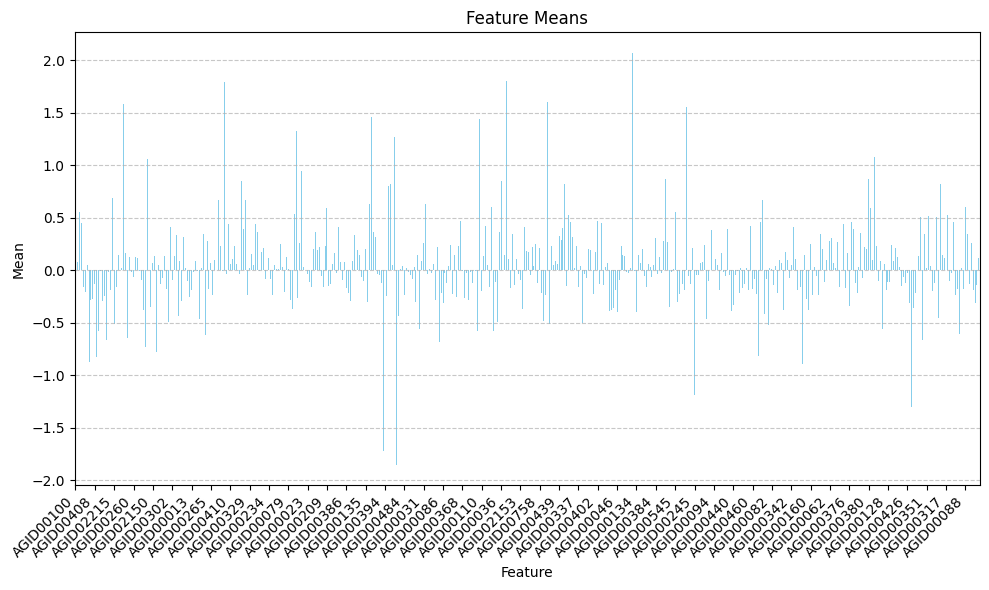

In [43]:
describe_df = merged_df[protein_columns].describe()
row_means = describe_df.loc['mean']

# Plot row means
plt.figure(figsize=(10, 6))
row_means.plot(kind='bar', color='skyblue')
plt.title('Feature Means')
plt.xlabel('Feature')
plt.ylabel('Mean')

plt.xticks(range(0, len(row_means), 10), row_means.index[::10], rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()


plt.show()

In [44]:
merged_df = merged_df.drop(["ajcc_pathologic_stage","vital_status","days_to_last_follow_up","case_submitter_id"], axis=1)
other = merged_df.columns.drop("days_to_death")

scaler = MinMaxScaler()
merged_df[other] = scaler.fit_transform(merged_df[other])

X_train, X_test, y_train, y_test = train_test_split(merged_df[other], merged_df["days_to_death"],
                                                    train_size=0.8,
                                                    random_state=1)

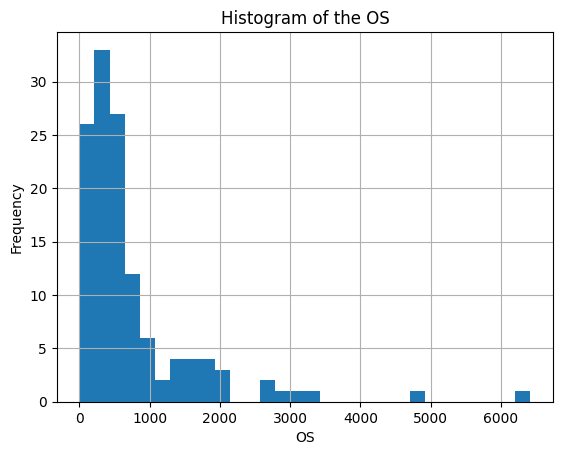

In [45]:
y_train.hist(bins=30) 
plt.xlabel('OS')
plt.ylabel('Frequency')
plt.title('Histogram of the OS')
plt.show()

# AE

In [46]:
class AE():
    def __init__(self,X_train,X_test,y_train,y_test,bottleneck,size,type):
        self.X_train = X_train
        self.X_test = X_test        
        self.y_train = y_train
        self.y_test = y_test
        self.bottleneck = bottleneck
        self.history = None
        self.encoder = None
        self.autoencoder = None
        self.size = size
        self.classifer = None
        self.cv_scores = {}
        self.type = type

    def train(self):
    # Number of features in your dataset
        n_features = len(self.X_train.columns) 


        input_layer = Input(shape=(n_features,))
        encoder = Dense(64, activation='relu')(input_layer)
        encoder = Dense(32, activation='relu')(encoder)


        bottleneck = Dense(self.bottleneck, activation='relu')(encoder)  

        # Define the decoder (mirror the encoder)
        decoder = Dense(32, activation='relu')(bottleneck)
        decoder = Dense(64, activation='relu')(decoder)
        self.encoder= Model(inputs=input_layer, outputs=bottleneck)

        # Output layer
        output_layer = Dense(n_features, activation='sigmoid')(decoder) 

        # Define the autoencoder model
        self.autoencoder = Model(inputs=input_layer, outputs=output_layer)

        # Compile the autoencoder
        self.autoencoder.compile(optimizer='adam', loss='mse')

        self.checkpoint = ModelCheckpoint(f'model/{self.type}_{self.size}_best_model.keras', 
                             monitor='val_loss', 
                             verbose=1,           
                             save_best_only=True, 
                             mode='min')         

        X_train, X_test= train_test_split(self.X_train,
                                            train_size=0.8,
                                            random_state=1)

        self.history = self.autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=8,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[self.checkpoint])  
        
        self.encode()
        self.map_y()

    def plot(self):
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss '+ self.size)
        plt.legend()
        plt.show()

    def encode(self):
        self.autoencoder.load_weights(f'model/{self.type}_{self.size}_best_model.keras')
        self.encoded_X_train = self.encoder.predict(self.X_train)
        self.encoded_X_test = self.encoder.predict(self.X_test)
    
    def do_PCA(self,n_components):
        if self.bottleneck == 2:
            # pca = PCA(n_components=n_components)
            # reduced_data = pca.fit_transform(self.encoded_X_test)
            x = self.encoded_X_test[:, 0]
            y = self.encoded_X_test[:, 1]
            plt.figure(figsize=(8, 6))
            scatter = plt.scatter(x, y, c=self.y_test_in_bin, cmap='viridis', alpha=0.7)
            plt.title('Encoded Data '+self.size)
            plt.xlabel('Encoded Dim 0')
            plt.ylabel('Encoded Dim 1')
            plt.colorbar(scatter, label='OS')
            plt.grid(True)
            plt.show()
            return
        if n_components ==2:
            pca = PCA(n_components=n_components)
            reduced_data = pca.fit_transform(self.encoded_X_test)
            x = reduced_data[:, 0]
            y = reduced_data[:, 1]
            plt.figure(figsize=(8, 6))
            scatter = plt.scatter(x, y, c=self.y_test_in_bin, cmap='viridis', alpha=0.7)
            plt.title('PCA of Encoded Data '+self.size)
            plt.xlabel('Principal Component 1')
            plt.ylabel('Principal Component 2')
            plt.colorbar(scatter, label='OS')
            plt.grid(True)
            plt.show()
        elif n_components ==3:
            pca = PCA(n_components=3)  # Reduce to 3 dimensions
            reduced_data = pca.fit_transform(self.encoded_X_test)
            x = reduced_data[:, 0]
            y = reduced_data[:, 1]
            z = reduced_data[:, 2]
            fig =plt.figure(figsize=(8, 6))
            ax = fig.add_subplot(111, projection='3d')
            scatter = ax.scatter(x, y, z, c=self.y_test_in_bin, cmap='viridis', depthshade=True)
            ax.set_title('3D PCA of Encoded Data '+self.size)
            ax.set_xlabel('Principal Component 1')
            ax.set_ylabel('Principal Component 2')
            ax.set_zlabel('Principal Component 3')
            plt.colorbar(scatter, label='OS')
            plt.show()

    @staticmethod
    def map_years_to_group(value):
        years = value / 365
        if years <= 1:
            return 0
        elif 1 < years <= 3:
            return 1
        elif 3 < years <= 5:
            return 2
        elif 5 < years <= 10:
            return 3
        elif 10 < years <= 20:
            return 4
        else:  
            return 5
        
    @staticmethod        
    def map_to_binary(category):
        if category >= 4:
            return 1
        else:  
            return 0
        
    def map_y(self):
        self.y_trian_in_category = self.y_train.map(AE.map_years_to_group)
        self.y_test_in_category = self.y_test.map(AE.map_years_to_group)        
        
        self.y_trian_in_bin = self.y_trian_in_category.map(AE.map_to_binary)
        self.y_test_in_bin = self.y_test_in_category.map(AE.map_to_binary)

    def cross_validation_model_selection(self,fold=10):
        classifiers = {
            'LogisticRegression': LogisticRegression(),
            'SVM': SVC(),
            'RandomForest': RandomForestClassifier(),
            'KNN': KNeighborsClassifier(),
            'GradientBoosting': GradientBoostingClassifier(),
            'AdaBoost': AdaBoostClassifier(),
            'NaiveBayes': GaussianNB(),
            'DecisionTree': DecisionTreeClassifier(),
            'ExtraTrees': ExtraTreesClassifier(),
            'XGBoost': xgb.XGBClassifier()
        }

        kf = KFold(n_splits=fold)
        best_cv_score = 0


        for name, clf in classifiers.items():
            cv_scores = []
            confusion_matrices = []

            for train_index, test_index in kf.split(self.encoded_X_train):
                X_train, X_test = self.encoded_X_train[train_index], self.encoded_X_train[test_index]
                y_train, y_test = self.y_trian_in_bin.iloc[train_index], self.y_trian_in_bin.iloc[test_index]

                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                
                cv_scores.append(accuracy_score(y_test, y_pred))
                confusion_matrices.append(confusion_matrix(y_test, y_pred))

            mean_cv_score = np.mean(cv_scores)
            mean_conf_matrix = np.mean(confusion_matrices, axis=0)

            self.cv_scores[name] = mean_cv_score
            
            print(f"{name} - Mean CV Score: {mean_cv_score}")
            print(f"{name} - Mean Confusion Matrix:\n{mean_conf_matrix}")

            if mean_cv_score > best_cv_score:
                best_cv_score = mean_cv_score
                best_classifier = name

        print(f"Size: {self.size}, Best classifier: {best_classifier}, CV Score: {best_cv_score}")



    def cross_validation_hyperparameter_optimization(self,fold=5):
        pass


    def do_RF(self,binary):
        clf = RandomForestClassifier(n_estimators=100, random_state=0)

        if binary:
            clf.fit(self.encoded_X_train, self.y_trian_in_bin)
            y_pred = clf.predict(self.encoded_X_test)
            cm = confusion_matrix(self.y_test_in_bin, y_pred)
            print(classification_report(self.y_test_in_bin, y_pred))

        else:
            clf.fit(self.encoded_X_train, self.y_trian_in_category)
            y_pred = clf.predict(self.encoded_X_test)
            cm = confusion_matrix(self.y_test_in_category, y_pred)
            print(classification_report(self.y_test_in_category, y_pred))

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_pred), yticklabels=np.unique(self.y_test_in_bin))
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('RF Confusion Matrix '+self.type)
        plt.show()
        self.classifer = clf

    def do_Kmean(self):
        # Number of clusters - assuming you want as many as your known classes
        num_clusters = 2
        # Perform K-means clustering on the PCA output
        kmeans = KMeans(n_clusters=num_clusters, random_state=0)
        cluster_labels = kmeans.fit_predict(self.encoded_X_test)  # Use your 2D or 3D PCA-reduced data here


        print("Classification Report:")
        print(classification_report(self.y_test_in_bin, cluster_labels))
        conf_mat = confusion_matrix(self.y_test_in_bin, cluster_labels)

        # Plotting the confusion matrix
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_clusters), yticklabels=np.unique(self.y_test_in_bin))
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('K-mean Confusion Matrix '+self.size)
        plt.show()
        self.classifer = kmeans

    def do_SVM(self,binary):
        svm_classifier = SVC(kernel='linear',random_state=0)
        # Load the best weights into the autoencoder model
        if binary:
            svm_classifier.fit(self.encoded_X_train, self.y_trian_in_bin)
            y_pred = svm_classifier.predict(self.encoded_X_test)
            cm = confusion_matrix(self.y_test_in_bin, y_pred)
            print(classification_report(self.y_test_in_bin, y_pred))
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_pred), yticklabels=np.unique(self.y_test_in_bin))
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title('SVM Confusion Matrix '+ self.size)
            plt.show()
        else:
            svm_classifier.fit(self.encoded_X_train, self.y_trian_in_category)
            y_pred = svm_classifier.predict(self.encoded_X_test)
            cm = confusion_matrix(self.y_test_in_category, y_pred)
            print(classification_report(self.y_test_in_category, y_pred))
        
            # Plotting the confusion matrix
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_pred), yticklabels=np.unique(self.y_test_in_category))
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title('SVM Confusion Matrix '+ self.size)
            plt.show()
        self.classifer = svm_classifier





In [47]:
class Wider_AE(AE):
    def train(self):
    # Number of features in your dataset
        n_features = len(self.X_train.columns) 


        input_layer = Input(shape=(n_features,))
        encoder = Dense(256, activation='relu')(input_layer)

        encoder = Dense(128, activation='relu')(input_layer)
        encoder = Dense(64, activation='relu')(encoder)


        bottleneck = Dense(self.bottleneck, activation='relu')(encoder)  

        # Define the decoder (mirror the encoder)
        decoder = Dense(64, activation='relu')(bottleneck)
        decoder = Dense(128, activation='relu')(decoder)
        decoder = Dense(256, activation='relu')(decoder)

        self.encoder= Model(inputs=input_layer, outputs=bottleneck)

        # Output layer
        output_layer = Dense(n_features, activation='sigmoid')(decoder) 

        # Define the autoencoder model
        self.autoencoder = Model(inputs=input_layer, outputs=output_layer)

        # Compile the autoencoder
        self.autoencoder.compile(optimizer='adam', loss='mse')

        self.checkpoint = ModelCheckpoint(f'model/{self.type}_{self.size}_best_model.keras', 
                             monitor='val_loss', 
                             verbose=1,           
                             save_best_only=True, 
                             mode='min')         

        X_train, X_test= train_test_split(self.X_train,
                                            train_size=0.8,
                                            random_state=1)

        self.history = self.autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=8,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[self.checkpoint])  
        
        self.encode()
        self.map_y()       


In [48]:
class SAE(AE):
    def train(self):

        n_features = len(self.X_train.columns)

        # Define the encoder
        input_layer = Input(shape=(n_features,))
        # Add L1 regularization to encourage sparsity
        encoder = Dense(64, activation='relu', 
                        activity_regularizer=regularizers.l1(1e-6))(input_layer)  # Adjust regularization rate as needed
        encoder = Dense(32, activation='relu', 
                        activity_regularizer=regularizers.l1(1e-6))(encoder)  # Adjust regularization rate as needed

        # Define the bottleneck
        bottleneck = Dense(self.bottleneck, activation='relu')(encoder)  

        # Define the decoder (mirror the encoder)
        decoder = Dense(32, activation='relu')(bottleneck)
        decoder = Dense(64, activation='relu')(decoder)
        self.encoder = Model(inputs=input_layer, outputs=bottleneck)

        # Output layer
        output_layer = Dense(n_features, activation='sigmoid')(decoder) 

        # Define the autoencoder model
        self.autoencoder = Model(inputs=input_layer, outputs=output_layer)

        # Compile the autoencoder
        self.autoencoder.compile(optimizer='adam', loss='mse')

        # Callback to save the best model
        self.checkpoint = ModelCheckpoint(f'model/{self.type}_{self.size}_best_model.keras', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

        X_train, X_test= train_test_split(self.X_train,
                                            train_size=0.8,
                                            random_state=1)

        self.history = self.autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=8,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[self.checkpoint])  
        self.encode()
        self.map_y()



In [49]:
class DSAE(AE):
    def train(self):
    # Number of features in your dataset
        n_features = len(self.X_train.columns) 


        input_layer = Input(shape=(n_features,))
        encoder = Dense(256, activation='relu',activity_regularizer=regularizers.l1(1e-4))(input_layer)

        encoder = Dense(128, activation='relu',activity_regularizer=regularizers.l1(1e-4))(input_layer)
        encoder = Dense(64, activation='relu',activity_regularizer=regularizers.l1(1e-4))(encoder)


        bottleneck = Dense(self.bottleneck, activation='relu')(encoder)  

        # Define the decoder (mirror the encoder)
        decoder = Dense(64, activation='relu')(bottleneck)
        decoder = Dense(128, activation='relu')(decoder)
        decoder = Dense(256, activation='relu')(decoder)

        self.encoder= Model(inputs=input_layer, outputs=bottleneck)

        # Output layer
        output_layer = Dense(n_features, activation='sigmoid')(decoder) 

        # Define the autoencoder model
        self.autoencoder = Model(inputs=input_layer, outputs=output_layer)

        # Compile the autoencoder
        self.autoencoder.compile(optimizer='adam', loss='mse')

        self.checkpoint = ModelCheckpoint(f'model/{self.type}_{self.size}_best_model.keras', 
                             monitor='val_loss', 
                             verbose=1,           
                             save_best_only=True, 
                             mode='min')         

        X_train, X_test= train_test_split(self.X_train,
                                            train_size=0.8,
                                            random_state=1)

        self.history = self.autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=8,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[self.checkpoint])  
        
        self.encode()
        self.map_y()



        


# Dispatcher

In [50]:
def dispatcher(model,type,min_bottleneck, max_bottleneck,step =1):
    current_size = min_bottleneck
    AEs = []
    results = []
    while current_size <= max_bottleneck:
        name = f"bottleneck_{current_size}"
        AEs.append(model(X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test,bottleneck = current_size,size = name,type = type))
        current_size += step
    for AE_to_train in AEs:
        AE_to_train.train()
        AE_to_train.cross_validation_model_selection()
        results.append({f"{AE_to_train.type} {AE_to_train.size}": AE_to_train.cv_scores})
    
    output = json.dumps(results)
    with open(f"output/{type}_model_output.json","w") as file:
        file.write(output)
    return
    

In [51]:
dispatcher(AE,"AE",6,48)

Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 436ms/step - loss: 0.0446
Epoch 1: val_loss improved from inf to 0.02703, saving model to model/AE_bottleneck_6_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0418 - val_loss: 0.0270
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0243
Epoch 2: val_loss improved from 0.02703 to 0.02391, saving model to model/AE_bottleneck_6_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0237 - val_loss: 0.0239
Epoch 3/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0265
Epoch 3: val_loss improved from 0.02391 to 0.02219, saving model to model/AE_bottleneck_6_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0228 - val_loss: 0.0222
Epoch 4/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0204
Epoch 4: val_loss improved from 0.02219 to 0.02026, saving model to model/AE_bottleneck_6_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0213 - val_loss: 0.0203
Epoch 5/100
 1/

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5713846153846154
AdaBoost - Mean Confusion Matrix:
[[7.5 5.1]
 [6.  7.3]]
NaiveBayes - Mean CV Score: 0.5676923076923077
NaiveBayes - Mean Confusion Matrix:
[[8.1 4.5]
 [6.7 6.6]]
DecisionTree - Mean CV Score: 0.5492307692307692
DecisionTree - Mean Confusion Matrix:
[[7.  5.6]
 [6.1 7.2]]
ExtraTrees - Mean CV Score: 0.5681538461538461
ExtraTrees - Mean Confusion Matrix:
[[7.  5.6]
 [5.6 7.7]]
XGBoost - Mean CV Score: 0.5404615384615384
XGBoost - Mean Confusion Matrix:
[[6.4 6.2]
 [5.7 7.6]]
Size: bottleneck_6, Best classifier: RandomForest, CV Score: 0.5986153846153845
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - loss: 0.0437
Epoch 1: val_loss improved from inf to 0.02789, saving model to model/AE_bottleneck_7_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0432 - val_loss: 0.0279
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0273
Epoch 2: val_loss improved from 0.02789 to 0.02420, saving model to model/AE_bottleneck

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.6143076923076922
AdaBoost - Mean Confusion Matrix:
[[7.8 4.8]
 [5.2 8.1]]
NaiveBayes - Mean CV Score: 0.5286153846153846
NaiveBayes - Mean Confusion Matrix:
[[12.1  0.5]
 [11.7  1.6]]
DecisionTree - Mean CV Score: 0.5829230769230769
DecisionTree - Mean Confusion Matrix:
[[7.1 5.5]
 [5.3 8. ]]
ExtraTrees - Mean CV Score: 0.6681538461538461
ExtraTrees - Mean Confusion Matrix:
[[8.8 3.8]
 [4.8 8.5]]
XGBoost - Mean CV Score: 0.6681538461538462
XGBoost - Mean Confusion Matrix:
[[8.5 4.1]
 [4.5 8.8]]
Size: bottleneck_7, Best classifier: XGBoost, CV Score: 0.6681538461538462
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 434ms/step - loss: 0.0495
Epoch 1: val_loss improved from inf to 0.02916, saving model to model/AE_bottleneck_8_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0447 - val_loss: 0.0292
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0312
Epoch 2: val_loss improved from 0.02916 to 0.02449, saving model to model/AE_bottlenec

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5447692307692308
AdaBoost - Mean Confusion Matrix:
[[6.4 6.2]
 [5.6 7.7]]
NaiveBayes - Mean CV Score: 0.5369230769230768
NaiveBayes - Mean Confusion Matrix:
[[8.5 4.1]
 [7.9 5.4]]
DecisionTree - Mean CV Score: 0.5907692307692307
DecisionTree - Mean Confusion Matrix:
[[7.8 4.8]
 [5.8 7.5]]
ExtraTrees - Mean CV Score: 0.5947692307692307
ExtraTrees - Mean Confusion Matrix:
[[8.  4.6]
 [5.9 7.4]]
XGBoost - Mean CV Score: 0.5250769230769231
XGBoost - Mean Confusion Matrix:
[[6.2 6.4]
 [5.9 7.4]]
Size: bottleneck_8, Best classifier: RandomForest, CV Score: 0.6103076923076923
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 414ms/step - loss: 0.0425
Epoch 1: val_loss improved from inf to 0.02685, saving model to model/AE_bottleneck_9_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0427 - val_loss: 0.0269
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0324
Epoch 2: val_loss improved from 0.02685 to 0.02410, saving model to model/AE_bottlene

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5716923076923076
AdaBoost - Mean Confusion Matrix:
[[7.3 5.3]
 [5.8 7.5]]
NaiveBayes - Mean CV Score: 0.5599999999999999
NaiveBayes - Mean Confusion Matrix:
[[7.6 5. ]
 [6.4 6.9]]
DecisionTree - Mean CV Score: 0.548
DecisionTree - Mean Confusion Matrix:
[[6.7 5.9]
 [5.8 7.5]]
ExtraTrees - Mean CV Score: 0.5904615384615385
ExtraTrees - Mean Confusion Matrix:
[[7.6 5. ]
 [5.6 7.7]]
XGBoost - Mean CV Score: 0.5676923076923076
XGBoost - Mean Confusion Matrix:
[[6.9 5.7]
 [5.5 7.8]]
Size: bottleneck_9, Best classifier: ExtraTrees, CV Score: 0.5904615384615385
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 408ms/step - loss: 0.0497
Epoch 1: val_loss improved from inf to 0.02833, saving model to model/AE_bottleneck_10_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0433 - val_loss: 0.0283
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0251
Epoch 2: val_loss improved from 0.02833 to 0.02440, saving model to model/AE_bottleneck_10_best_mod

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.47846153846153855
AdaBoost - Mean Confusion Matrix:
[[5.8 6.8]
 [6.7 6.6]]
NaiveBayes - Mean CV Score: 0.5132307692307693
NaiveBayes - Mean Confusion Matrix:
[[12.3  0.3]
 [12.3  1. ]]
DecisionTree - Mean CV Score: 0.5556923076923077
DecisionTree - Mean Confusion Matrix:
[[7.1 5.5]
 [6.  7.3]]
ExtraTrees - Mean CV Score: 0.5832307692307691
ExtraTrees - Mean Confusion Matrix:
[[7.3 5.3]
 [5.5 7.8]]
XGBoost - Mean CV Score: 0.5984615384615386
XGBoost - Mean Confusion Matrix:
[[7.1 5.5]
 [4.9 8.4]]
Size: bottleneck_10, Best classifier: XGBoost, CV Score: 0.5984615384615386
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 413ms/step - loss: 0.0504
Epoch 1: val_loss improved from inf to 0.02741, saving model to model/AE_bottleneck_11_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0439 - val_loss: 0.0274
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0282
Epoch 2: val_loss improved from 0.02741 to 0.02421, saving model to model/AE_bottle

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5603076923076923
AdaBoost - Mean Confusion Matrix:
[[6.6 6. ]
 [5.4 7.9]]
NaiveBayes - Mean CV Score: 0.5946153846153847
NaiveBayes - Mean Confusion Matrix:
[[8.3 4.3]
 [6.2 7.1]]
DecisionTree - Mean CV Score: 0.5595384615384615
DecisionTree - Mean Confusion Matrix:
[[6.3 6.3]
 [5.1 8.2]]
ExtraTrees - Mean CV Score: 0.6067692307692307
ExtraTrees - Mean Confusion Matrix:
[[7.3 5.3]
 [4.9 8.4]]
XGBoost - Mean CV Score: 0.5983076923076924
XGBoost - Mean Confusion Matrix:
[[7.2 5.4]
 [5.  8.3]]
Size: bottleneck_11, Best classifier: RandomForest, CV Score: 0.6330769230769231
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 416ms/step - loss: 0.0473
Epoch 1: val_loss improved from inf to 0.02736, saving model to model/AE_bottleneck_12_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0423 - val_loss: 0.0274
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0210
Epoch 2: val_loss improved from 0.02736 to 0.02423, saving model to model/AE_bottle

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5372307692307692
AdaBoost - Mean Confusion Matrix:
[[6.3 6.3]
 [5.7 7.6]]
NaiveBayes - Mean CV Score: 0.5558461538461538
NaiveBayes - Mean Confusion Matrix:
[[7.5 5.1]
 [6.4 6.9]]
DecisionTree - Mean CV Score: 0.5796923076923076
DecisionTree - Mean Confusion Matrix:
[[7.3 5.3]
 [5.6 7.7]]
ExtraTrees - Mean CV Score: 0.583076923076923
ExtraTrees - Mean Confusion Matrix:
[[7.1 5.5]
 [5.3 8. ]]
XGBoost - Mean CV Score: 0.5596923076923076
XGBoost - Mean Confusion Matrix:
[[6.7 5.9]
 [5.5 7.8]]
Size: bottleneck_12, Best classifier: RandomForest, CV Score: 0.5949230769230769
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 413ms/step - loss: 0.0463
Epoch 1: val_loss improved from inf to 0.02820, saving model to model/AE_bottleneck_13_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0437 - val_loss: 0.0282
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0238
Epoch 2: val_loss improved from 0.02820 to 0.02406, saving model to model/AE_bottlen

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5481538461538461
AdaBoost - Mean Confusion Matrix:
[[7.1 5.5]
 [6.2 7.1]]
NaiveBayes - Mean CV Score: 0.5635384615384617
NaiveBayes - Mean Confusion Matrix:
[[7.8 4.8]
 [6.5 6.8]]
DecisionTree - Mean CV Score: 0.5136923076923077
DecisionTree - Mean Confusion Matrix:
[[6.7 5.9]
 [6.7 6.6]]
ExtraTrees - Mean CV Score: 0.6100000000000001
ExtraTrees - Mean Confusion Matrix:
[[7.9 4.7]
 [5.4 7.9]]
XGBoost - Mean CV Score: 0.5327692307692308
XGBoost - Mean Confusion Matrix:
[[6.3 6.3]
 [5.8 7.5]]
Size: bottleneck_13, Best classifier: ExtraTrees, CV Score: 0.6100000000000001
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 412ms/step - loss: 0.0518
Epoch 1: val_loss improved from inf to 0.02773, saving model to model/AE_bottleneck_14_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0437 - val_loss: 0.0277
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0246
Epoch 2: val_loss improved from 0.02773 to 0.02441, saving model to model/AE_bottlene

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5407692307692307
AdaBoost - Mean Confusion Matrix:
[[6.5 6.1]
 [5.8 7.5]]
NaiveBayes - Mean CV Score: 0.5055384615384615
NaiveBayes - Mean Confusion Matrix:
[[12.   0.6]
 [12.2  1.1]]
DecisionTree - Mean CV Score: 0.48692307692307696
DecisionTree - Mean Confusion Matrix:
[[6.1 6.5]
 [6.8 6.5]]
ExtraTrees - Mean CV Score: 0.5635384615384614
ExtraTrees - Mean Confusion Matrix:
[[7.4 5.2]
 [6.1 7.2]]
XGBoost - Mean CV Score: 0.5750769230769232
XGBoost - Mean Confusion Matrix:
[[7.2 5.4]
 [5.6 7.7]]
Size: bottleneck_14, Best classifier: XGBoost, CV Score: 0.5750769230769232
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 414ms/step - loss: 0.0499
Epoch 1: val_loss improved from inf to 0.02644, saving model to model/AE_bottleneck_15_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0424 - val_loss: 0.0264
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0212
Epoch 2: val_loss improved from 0.02644 to 0.02414, saving model to model/AE_bottle

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5366153846153846
AdaBoost - Mean Confusion Matrix:
[[6.8 5.8]
 [6.2 7.1]]
NaiveBayes - Mean CV Score: 0.6023076923076923
NaiveBayes - Mean Confusion Matrix:
[[8.4 4.2]
 [6.1 7.2]]
DecisionTree - Mean CV Score: 0.5323076923076924
DecisionTree - Mean Confusion Matrix:
[[6.9 5.7]
 [6.4 6.9]]
ExtraTrees - Mean CV Score: 0.5676923076923076
ExtraTrees - Mean Confusion Matrix:
[[7.  5.6]
 [5.6 7.7]]
XGBoost - Mean CV Score: 0.5292307692307692
XGBoost - Mean Confusion Matrix:
[[6.4 6.2]
 [6.  7.3]]
Size: bottleneck_15, Best classifier: SVM, CV Score: 0.6064615384615385
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 416ms/step - loss: 0.0478
Epoch 1: val_loss improved from inf to 0.02640, saving model to model/AE_bottleneck_16_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0416 - val_loss: 0.0264
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0254
Epoch 2: val_loss improved from 0.02640 to 0.02431, saving model to model/AE_bottleneck_16_b

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5829230769230769
AdaBoost - Mean Confusion Matrix:
[[7.1 5.5]
 [5.3 8. ]]
NaiveBayes - Mean CV Score: 0.5907692307692308
NaiveBayes - Mean Confusion Matrix:
[[8.6 4. ]
 [6.6 6.7]]
DecisionTree - Mean CV Score: 0.529076923076923
DecisionTree - Mean Confusion Matrix:
[[6.8 5.8]
 [6.4 6.9]]
ExtraTrees - Mean CV Score: 0.6175384615384616
ExtraTrees - Mean Confusion Matrix:
[[7.8 4.8]
 [5.1 8.2]]
XGBoost - Mean CV Score: 0.6023076923076923
XGBoost - Mean Confusion Matrix:
[[7.3 5.3]
 [5.  8.3]]
Size: bottleneck_16, Best classifier: RandomForest, CV Score: 0.6601538461538461
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 415ms/step - loss: 0.0519
Epoch 1: val_loss improved from inf to 0.02671, saving model to model/AE_bottleneck_17_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0426 - val_loss: 0.0267
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0247
Epoch 2: val_loss improved from 0.02671 to 0.02408, saving model to model/AE_bottlen

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.5870769230769232
RandomForest - Mean Confusion Matrix:
[[6.5 6.1]
 [4.6 8.7]]
KNN - Mean CV Score: 0.6407692307692308
KNN - Mean Confusion Matrix:
[[8.2 4.4]
 [4.9 8.4]]
GradientBoosting - Mean CV Score: 0.6300000000000001
GradientBoosting - Mean Confusion Matrix:
[[7.1 5.5]
 [4.1 9.2]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5830769230769229
AdaBoost - Mean Confusion Matrix:
[[7.4 5.2]
 [5.6 7.7]]
NaiveBayes - Mean CV Score: 0.5986153846153845
NaiveBayes - Mean Confusion Matrix:
[[8.6 4. ]
 [6.4 6.9]]
DecisionTree - Mean CV Score: 0.5449230769230768
DecisionTree - Mean Confusion Matrix:
[[6.9 5.7]
 [6.1 7.2]]
ExtraTrees - Mean CV Score: 0.6523076923076923
ExtraTrees - Mean Confusion Matrix:
[[7.7 4.9]
 [4.1 9.2]]
XGBoost - Mean CV Score: 0.6258461538461538
XGBoost - Mean Confusion Matrix:
[[7.1 5.5]
 [4.2 9.1]]
Size: bottleneck_17, Best classifier: ExtraTrees, CV Score: 0.6523076923076923
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 412ms/step - loss: 0.0474
Epoch 1: val_loss improved from inf to 0.02752, saving model to model/AE_bottleneck_18_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0436 - val_loss: 0.0275
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0249
Epoch 2: val_loss improved from 0.02752 to 0.02431, saving model to model/AE_bottlene

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.5716923076923076
RandomForest - Mean Confusion Matrix:
[[6.9 5.7]
 [5.4 7.9]]
KNN - Mean CV Score: 0.5596923076923076
KNN - Mean Confusion Matrix:
[[7.6 5. ]
 [6.4 6.9]]
GradientBoosting - Mean CV Score: 0.521076923076923
GradientBoosting - Mean Confusion Matrix:
[[6.4 6.2]
 [6.2 7.1]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5287692307692307
AdaBoost - Mean Confusion Matrix:
[[6.4 6.2]
 [6.  7.3]]
NaiveBayes - Mean CV Score: 0.5207692307692309
NaiveBayes - Mean Confusion Matrix:
[[10.7  1.9]
 [10.5  2.8]]
DecisionTree - Mean CV Score: 0.5676923076923076
DecisionTree - Mean Confusion Matrix:
[[7.  5.6]
 [5.6 7.7]]
ExtraTrees - Mean CV Score: 0.5829230769230771
ExtraTrees - Mean Confusion Matrix:
[[7.2 5.4]
 [5.4 7.9]]
XGBoost - Mean CV Score: 0.5676923076923076
XGBoost - Mean Confusion Matrix:
[[6.9 5.7]
 [5.5 7.8]]
Size: bottleneck_18, Best classifier: ExtraTrees, CV Score: 0.5829230769230771
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 413ms/step - loss: 0.0445
Epoch 1: val_loss improved from inf to 0.02861, saving model to model/AE_bottleneck_19_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0429 - val_loss: 0.0286
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0229
Epoch 2: val_loss improved from 0.02861 to 0.02402, saving model to model/AE_bott

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.6564615384615384
RandomForest - Mean Confusion Matrix:
[[7.4 5.2]
 [3.7 9.6]]
KNN - Mean CV Score: 0.6256923076923077
KNN - Mean Confusion Matrix:
[[8.  4.6]
 [5.1 8.2]]
GradientBoosting - Mean CV Score: 0.6798461538461538
GradientBoosting - Mean Confusion Matrix:
[[8.5 4.1]
 [4.2 9.1]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.6524615384615384
AdaBoost - Mean Confusion Matrix:
[[8.2 4.4]
 [4.6 8.7]]
NaiveBayes - Mean CV Score: 0.5950769230769231
NaiveBayes - Mean Confusion Matrix:
[[6.  6.6]
 [3.9 9.4]]
DecisionTree - Mean CV Score: 0.5709230769230769
DecisionTree - Mean Confusion Matrix:
[[7.7 4.9]
 [6.2 7.1]]
ExtraTrees - Mean CV Score: 0.6563076923076923
ExtraTrees - Mean Confusion Matrix:
[[7.7 4.9]
 [4.  9.3]]
XGBoost - Mean CV Score: 0.6178461538461539
XGBoost - Mean Confusion Matrix:
[[7.2 5.4]
 [4.5 8.8]]
Size: bottleneck_19, Best classifier: GradientBoosting, CV Score: 0.6798461538461538
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 413ms/step - loss: 0.0479
Epoch 1: val_loss improved from inf to 0.02716, saving model to model/AE_bottleneck_20_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0438 - val_loss: 0.0272
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0224
Epoch 2: val_loss improved from 0.02716 to 0.02429, saving model to model/AE_bo

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.5752307692307692
RandomForest - Mean Confusion Matrix:
[[6.9 5.7]
 [5.3 8. ]]
KNN - Mean CV Score: 0.602
KNN - Mean Confusion Matrix:
[[8.2 4.4]
 [5.9 7.4]]
GradientBoosting - Mean CV Score: 0.566923076923077
GradientBoosting - Mean Confusion Matrix:
[[6.8 5.8]
 [5.4 7.9]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5556923076923077
AdaBoost - Mean Confusion Matrix:
[[6.7 5.9]
 [5.6 7.7]]
NaiveBayes - Mean CV Score: 0.5401538461538462
NaiveBayes - Mean Confusion Matrix:
[[12.3  0.3]
 [11.6  1.7]]
DecisionTree - Mean CV Score: 0.5361538461538462
DecisionTree - Mean Confusion Matrix:
[[6.  6.6]
 [5.4 7.9]]
ExtraTrees - Mean CV Score: 0.633076923076923
ExtraTrees - Mean Confusion Matrix:
[[8.  4.6]
 [4.9 8.4]]
XGBoost - Mean CV Score: 0.5866153846153846
XGBoost - Mean Confusion Matrix:
[[6.9 5.7]
 [5.  8.3]]
Size: bottleneck_20, Best classifier: ExtraTrees, CV Score: 0.633076923076923
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 413ms/step - loss: 0.0450
Epoch 1: val_loss improved from inf to 0.02740, saving model to model/AE_bottleneck_21_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0421 - val_loss: 0.0274
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0253
Epoch 2: val_loss improved from 0.02740 to 0.02423, saving model to model/AE_bottle

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.614
RandomForest - Mean Confusion Matrix:
[[7.3 5.3]
 [4.7 8.6]]
KNN - Mean CV Score: 0.5636923076923077
KNN - Mean Confusion Matrix:
[[7.6 5. ]
 [6.3 7. ]]
GradientBoosting - Mean CV Score: 0.6027692307692307
GradientBoosting - Mean Confusion Matrix:
[[7.2 5.4]
 [4.9 8.4]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.6064615384615385
AdaBoost - Mean Confusion Matrix:
[[7.2 5.4]
 [4.8 8.5]]
NaiveBayes - Mean CV Score: 0.579076923076923
NaiveBayes - Mean Confusion Matrix:
[[9.2 3.4]
 [7.5 5.8]]
DecisionTree - Mean CV Score: 0.5212307692307692
DecisionTree - Mean Confusion Matrix:
[[6.4 6.2]
 [6.2 7.1]]
ExtraTrees - Mean CV Score: 0.579076923076923
ExtraTrees - Mean Confusion Matrix:
[[7.7 4.9]
 [6.  7.3]]
XGBoost - Mean CV Score: 0.6176923076923077
XGBoost - Mean Confusion Matrix:
[[7.5 5.1]
 [4.8 8.5]]
Size: bottleneck_21, Best classifier: XGBoost, CV Score: 0.6176923076923077
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 415ms/step - loss: 0.0459
Epoch 1: val_loss improved from inf to 0.02685, saving model to model/AE_bottleneck_22_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0427 - val_loss: 0.0269
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0227
Epoch 2: val_loss improved from 0.02685 to 0.02427, saving model to model/AE_bottleneck_22

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.6024615384615384
RandomForest - Mean Confusion Matrix:
[[6.7 5.9]
 [4.4 8.9]]
KNN - Mean CV Score: 0.6372307692307693
KNN - Mean Confusion Matrix:
[[8.4 4.2]
 [5.2 8.1]]
GradientBoosting - Mean CV Score: 0.6370769230769231
GradientBoosting - Mean Confusion Matrix:
[[7.8 4.8]
 [4.6 8.7]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.6332307692307693
AdaBoost - Mean Confusion Matrix:
[[8.1 4.5]
 [5.  8.3]]
NaiveBayes - Mean CV Score: 0.583076923076923
NaiveBayes - Mean Confusion Matrix:
[[9.9 2.7]
 [8.1 5.2]]
DecisionTree - Mean CV Score: 0.5250769230769231
DecisionTree - Mean Confusion Matrix:
[[6.1 6.5]
 [5.8 7.5]]
ExtraTrees - Mean CV Score: 0.637076923076923
ExtraTrees - Mean Confusion Matrix:
[[7.9 4.7]
 [4.7 8.6]]
XGBoost - Mean CV Score: 0.5872307692307692
XGBoost - Mean Confusion Matrix:
[[6.9 5.7]
 [5.  8.3]]
Size: bottleneck_22, Best classifier: KNN, CV Score: 0.6372307692307693
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 415ms/step - loss: 0.0526
Epoch 1: val_loss improved from inf to 0.02750, saving model to model/AE_bottleneck_23_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0430 - val_loss: 0.0275
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0236
Epoch 2: val_loss improved from 0.02750 to 0.02393, saving model to model/AE_bottleneck_23_bes

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.5946153846153847
RandomForest - Mean Confusion Matrix:
[[6.7 5.9]
 [4.6 8.7]]
KNN - Mean CV Score: 0.5559999999999998
KNN - Mean Confusion Matrix:
[[7.9 4.7]
 [6.8 6.5]]
GradientBoosting - Mean CV Score: 0.5906153846153848
GradientBoosting - Mean Confusion Matrix:
[[6.9 5.7]
 [4.9 8.4]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5366153846153846
AdaBoost - Mean Confusion Matrix:
[[6.4 6.2]
 [5.8 7.5]]
NaiveBayes - Mean CV Score: 0.5747692307692308
NaiveBayes - Mean Confusion Matrix:
[[10.5  2.1]
 [ 8.9  4.4]]
DecisionTree - Mean CV Score: 0.6180000000000001
DecisionTree - Mean Confusion Matrix:
[[7.2 5.4]
 [4.5 8.8]]
ExtraTrees - Mean CV Score: 0.6404615384615384
ExtraTrees - Mean Confusion Matrix:
[[8.1 4.5]
 [4.8 8.5]]
XGBoost - Mean CV Score: 0.6256923076923077
XGBoost - Mean Confusion Matrix:
[[7.6 5. ]
 [4.7 8.6]]
Size: bottleneck_23, Best classifier: ExtraTrees, CV Score: 0.6404615384615384
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 414ms/step - loss: 0.0437
Epoch 1: val_loss improved from inf to 0.02703, saving model to model/AE_bottleneck_24_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0429 - val_loss: 0.0270
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0234
Epoch 2: val_loss improved from 0.02703 to 0.02415, saving model to model/AE_bott

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.5678461538461538
RandomForest - Mean Confusion Matrix:
[[7.  5.6]
 [5.6 7.7]]
KNN - Mean CV Score: 0.5907692307692307
KNN - Mean Confusion Matrix:
[[7.8 4.8]
 [5.8 7.5]]
GradientBoosting - Mean CV Score: 0.614
GradientBoosting - Mean Confusion Matrix:
[[8.1 4.5]
 [5.5 7.8]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.6060000000000001
AdaBoost - Mean Confusion Matrix:
[[7.4 5.2]
 [5.  8.3]]
NaiveBayes - Mean CV Score: 0.5247692307692308
NaiveBayes - Mean Confusion Matrix:
[[10.2  2.4]
 [ 9.9  3.4]]
DecisionTree - Mean CV Score: 0.5592307692307692
DecisionTree - Mean Confusion Matrix:
[[7.2 5.4]
 [6.  7.3]]
ExtraTrees - Mean CV Score: 0.5523076923076923
ExtraTrees - Mean Confusion Matrix:
[[7.  5.6]
 [6.  7.3]]
XGBoost - Mean CV Score: 0.6063076923076923
XGBoost - Mean Confusion Matrix:
[[7.6 5. ]
 [5.2 8.1]]
Size: bottleneck_24, Best classifier: GradientBoosting, CV Score: 0.614
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 414ms/step - loss: 0.0442
Epoch 1: val_loss improved from inf to 0.02786, saving model to model/AE_bottleneck_25_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0423 - val_loss: 0.0279
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0236
Epoch 2: val_loss improved from 0.02786 to 0.02417, saving model to model/AE_bottleneck_

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.6101538461538462
RandomForest - Mean Confusion Matrix:
[[7.5 5.1]
 [5.  8.3]]
KNN - Mean CV Score: 0.5864615384615384
KNN - Mean Confusion Matrix:
[[7.9 4.7]
 [6.  7.3]]
GradientBoosting - Mean CV Score: 0.6173846153846154
GradientBoosting - Mean Confusion Matrix:
[[7.8 4.8]
 [5.1 8.2]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5673846153846153
AdaBoost - Mean Confusion Matrix:
[[7.  5.6]
 [5.6 7.7]]
NaiveBayes - Mean CV Score: 0.5715384615384614
NaiveBayes - Mean Confusion Matrix:
[[8.2 4.4]
 [6.7 6.6]]
DecisionTree - Mean CV Score: 0.5826153846153845
DecisionTree - Mean Confusion Matrix:
[[7.1 5.5]
 [5.3 8. ]]
ExtraTrees - Mean CV Score: 0.6023076923076923
ExtraTrees - Mean Confusion Matrix:
[[7.7 4.9]
 [5.4 7.9]]
XGBoost - Mean CV Score: 0.5867692307692309
XGBoost - Mean Confusion Matrix:
[[7.  5.6]
 [5.1 8.2]]
Size: bottleneck_25, Best classifier: GradientBoosting, CV Score: 0.6173846153846154
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 414ms/step - loss: 0.0477
Epoch 1: val_loss improved from inf to 0.02636, saving model to model/AE_bottleneck_26_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0417 - val_loss: 0.0264
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0267
Epoch 2: val_loss improved from 0.02636 to 0.02406, saving model to model/AE_bo

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.6098461538461539
RandomForest - Mean Confusion Matrix:
[[7.2 5.4]
 [4.7 8.6]]
KNN - Mean CV Score: 0.614
KNN - Mean Confusion Matrix:
[[8.  4.6]
 [5.4 7.9]]
GradientBoosting - Mean CV Score: 0.5596923076923078
GradientBoosting - Mean Confusion Matrix:
[[7.2 5.4]
 [6.  7.3]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5716923076923076
AdaBoost - Mean Confusion Matrix:
[[7.2 5.4]
 [5.7 7.6]]
NaiveBayes - Mean CV Score: 0.5518461538461539
NaiveBayes - Mean Confusion Matrix:
[[9.7 2.9]
 [8.7 4.6]]
DecisionTree - Mean CV Score: 0.5907692307692306
DecisionTree - Mean Confusion Matrix:
[[7.3 5.3]
 [5.3 8. ]]
ExtraTrees - Mean CV Score: 0.6173846153846154
ExtraTrees - Mean Confusion Matrix:
[[7.6 5. ]
 [4.9 8.4]]
XGBoost - Mean CV Score: 0.61
XGBoost - Mean Confusion Matrix:
[[7.6 5. ]
 [5.1 8.2]]
Size: bottleneck_26, Best classifier: ExtraTrees, CV Score: 0.6173846153846154
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 414ms/step - loss: 0.0497
Epoch 1: val_loss improved from inf to 0.02843, saving model to model/AE_bottleneck_27_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0438 - val_loss: 0.0284
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0285
Epoch 2: val_loss improved from 0.02843 to 0.02436, saving model to model/AE_bottleneck_27_best_mod

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.6021538461538463
RandomForest - Mean Confusion Matrix:
[[7.2 5.4]
 [4.9 8.4]]
KNN - Mean CV Score: 0.6175384615384616
KNN - Mean Confusion Matrix:
[[8.7 3.9]
 [6.  7.3]]
GradientBoosting - Mean CV Score: 0.6252307692307693
GradientBoosting - Mean Confusion Matrix:
[[7.9 4.7]
 [5.  8.3]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5676923076923076
AdaBoost - Mean Confusion Matrix:
[[7.2 5.4]
 [5.8 7.5]]
NaiveBayes - Mean CV Score: 0.556
NaiveBayes - Mean Confusion Matrix:
[[9.1 3.5]
 [8.  5.3]]
DecisionTree - Mean CV Score: 0.5526153846153846
DecisionTree - Mean Confusion Matrix:
[[7.5 5.1]
 [6.5 6.8]]
ExtraTrees - Mean CV Score: 0.5944615384615384
ExtraTrees - Mean Confusion Matrix:
[[7.5 5.1]
 [5.4 7.9]]
XGBoost - Mean CV Score: 0.6444615384615384
XGBoost - Mean Confusion Matrix:
[[7.9 4.7]
 [4.5 8.8]]
Size: bottleneck_27, Best classifier: XGBoost, CV Score: 0.6444615384615384
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 412ms/step - loss: 0.0502
Epoch 1: val_loss improved from inf to 0.02671, saving model to model/AE_bottleneck_28_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0421 - val_loss: 0.0267
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0239
Epoch 2: val_loss improved from 0.02671 to 0.02347, saving model to model/AE_bottleneck_28_best_model

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.6136923076923078
RandomForest - Mean Confusion Matrix:
[[7.5 5.1]
 [4.9 8.4]]
KNN - Mean CV Score: 0.5870769230769229
KNN - Mean Confusion Matrix:
[[7.9 4.7]
 [6.  7.3]]
GradientBoosting - Mean CV Score: 0.6064615384615384
GradientBoosting - Mean Confusion Matrix:
[[7.5 5.1]
 [5.1 8.2]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.572
AdaBoost - Mean Confusion Matrix:
[[7.2 5.4]
 [5.7 7.6]]
NaiveBayes - Mean CV Score: 0.5904615384615385
NaiveBayes - Mean Confusion Matrix:
[[9.3 3.3]
 [7.3 6. ]]
DecisionTree - Mean CV Score: 0.5526153846153845
DecisionTree - Mean Confusion Matrix:
[[6.3 6.3]
 [5.3 8. ]]
ExtraTrees - Mean CV Score: 0.6215384615384616
ExtraTrees - Mean Confusion Matrix:
[[7.7 4.9]
 [4.9 8.4]]
XGBoost - Mean CV Score: 0.6138461538461538
XGBoost - Mean Confusion Matrix:
[[7.6 5. ]
 [5.  8.3]]
Size: bottleneck_28, Best classifier: ExtraTrees, CV Score: 0.6215384615384616
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 413ms/step - loss: 0.0427
Epoch 1: val_loss improved from inf to 0.02807, saving model to model/AE_bottleneck_29_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0427 - val_loss: 0.0281
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0280
Epoch 2: val_loss improved from 0.02807 to 0.02455, saving model to model/AE_bottleneck_29_best_mo

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.5904615384615385
RandomForest - Mean Confusion Matrix:
[[7.  5.6]
 [5.  8.3]]
KNN - Mean CV Score: 0.5906153846153848
KNN - Mean Confusion Matrix:
[[8.1 4.5]
 [6.1 7.2]]
GradientBoosting - Mean CV Score: 0.5829230769230769
GradientBoosting - Mean Confusion Matrix:
[[8.1 4.5]
 [6.3 7. ]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5172307692307692
AdaBoost - Mean Confusion Matrix:
[[7.1 5.5]
 [7.  6.3]]
NaiveBayes - Mean CV Score: 0.5673846153846153
NaiveBayes - Mean Confusion Matrix:
[[9.7 2.9]
 [8.3 5. ]]
DecisionTree - Mean CV Score: 0.5755384615384614
DecisionTree - Mean Confusion Matrix:
[[6.9 5.7]
 [5.3 8. ]]
ExtraTrees - Mean CV Score: 0.6058461538461539
ExtraTrees - Mean Confusion Matrix:
[[7.6 5. ]
 [5.2 8.1]]
XGBoost - Mean CV Score: 0.5793846153846153
XGBoost - Mean Confusion Matrix:
[[7.3 5.3]
 [5.6 7.7]]
Size: bottleneck_29, Best classifier: ExtraTrees, CV Score: 0.6058461538461539
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 412ms/step - loss: 0.0513
Epoch 1: val_loss improved from inf to 0.02808, saving model to model/AE_bottleneck_30_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0436 - val_loss: 0.0281
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0251
Epoch 2: val_loss improved from 0.02808 to 0.02425, saving model to model/AE_bottlene

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.5673846153846153
RandomForest - Mean Confusion Matrix:
[[6.6 6. ]
 [5.2 8.1]]
KNN - Mean CV Score: 0.5713846153846154
KNN - Mean Confusion Matrix:
[[8.1 4.5]
 [6.6 6.7]]
GradientBoosting - Mean CV Score: 0.6060000000000001
GradientBoosting - Mean Confusion Matrix:
[[7.8 4.8]
 [5.4 7.9]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5673846153846153
AdaBoost - Mean Confusion Matrix:
[[7.1 5.5]
 [5.7 7.6]]
NaiveBayes - Mean CV Score: 0.5170769230769231
NaiveBayes - Mean Confusion Matrix:
[[12.3  0.3]
 [12.2  1.1]]
DecisionTree - Mean CV Score: 0.5326153846153847
DecisionTree - Mean Confusion Matrix:
[[7.3 5.3]
 [6.8 6.5]]
ExtraTrees - Mean CV Score: 0.5943076923076923
ExtraTrees - Mean Confusion Matrix:
[[7.3 5.3]
 [5.2 8.1]]
XGBoost - Mean CV Score: 0.6061538461538462
XGBoost - Mean Confusion Matrix:
[[7.3 5.3]
 [4.9 8.4]]
Size: bottleneck_30, Best classifier: LogisticRegression, CV Score: 0.6253846153846154
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 413ms/step - loss: 0.0482
Epoch 1: val_loss improved from inf to 0.02698, saving model to model/AE_bottleneck_31_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0428 - val_loss: 0.0270
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0233
Epoch 2: val_loss improved from 0.02698 to 0.02406, saving model to model

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.6333846153846154
RandomForest - Mean Confusion Matrix:
[[7.6 5. ]
 [4.5 8.8]]
KNN - Mean CV Score: 0.5636923076923077
KNN - Mean Confusion Matrix:
[[7.9 4.7]
 [6.6 6.7]]
GradientBoosting - Mean CV Score: 0.5873846153846153
GradientBoosting - Mean Confusion Matrix:
[[7.4 5.2]
 [5.5 7.8]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.61
AdaBoost - Mean Confusion Matrix:
[[7.4 5.2]
 [4.9 8.4]]
NaiveBayes - Mean CV Score: 0.5324615384615384
NaiveBayes - Mean Confusion Matrix:
[[11.5  1.1]
 [11.   2.3]]
DecisionTree - Mean CV Score: 0.571076923076923
DecisionTree - Mean Confusion Matrix:
[[7.2 5.4]
 [5.7 7.6]]
ExtraTrees - Mean CV Score: 0.6103076923076923
ExtraTrees - Mean Confusion Matrix:
[[7.5 5.1]
 [5.  8.3]]
XGBoost - Mean CV Score: 0.618
XGBoost - Mean Confusion Matrix:
[[7.5 5.1]
 [4.8 8.5]]
Size: bottleneck_31, Best classifier: LogisticRegression, CV Score: 0.6523076923076923
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 415ms/step - loss: 0.0494
Epoch 1: val_loss improved from inf to 0.02572, saving model to model/AE_bottleneck_32_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0410 - val_loss: 0.0257
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0238
Epoch 2: val_loss improved from 0.02572 to 0.02366, saving model to model/AE_bottleneck_32_best_model

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.5904615384615385
RandomForest - Mean Confusion Matrix:
[[6.9 5.7]
 [4.9 8.4]]
KNN - Mean CV Score: 0.5864615384615386
KNN - Mean Confusion Matrix:
[[7.1 5.5]
 [5.2 8.1]]
GradientBoosting - Mean CV Score: 0.5633846153846154
GradientBoosting - Mean Confusion Matrix:
[[7.  5.6]
 [5.7 7.6]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5672307692307692
AdaBoost - Mean Confusion Matrix:
[[6.8 5.8]
 [5.4 7.9]]
NaiveBayes - Mean CV Score: 0.548
NaiveBayes - Mean Confusion Matrix:
[[8.4 4.2]
 [7.5 5.8]]
DecisionTree - Mean CV Score: 0.5752307692307692
DecisionTree - Mean Confusion Matrix:
[[7.1 5.5]
 [5.5 7.8]]
ExtraTrees - Mean CV Score: 0.6218461538461539
ExtraTrees - Mean Confusion Matrix:
[[7.6 5. ]
 [4.8 8.5]]
XGBoost - Mean CV Score: 0.6056923076923078
XGBoost - Mean Confusion Matrix:
[[7.1 5.5]
 [4.7 8.6]]
Size: bottleneck_32, Best classifier: ExtraTrees, CV Score: 0.6218461538461539
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 417ms/step - loss: 0.0450
Epoch 1: val_loss improved from inf to 0.02719, saving model to model/AE_bottleneck_33_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0438 - val_loss: 0.0272
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0238
Epoch 2: val_loss improved from 0.02719 to 0.02443, saving model to model/AE_bottleneck_33_best_mo

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.6064615384615384
RandomForest - Mean Confusion Matrix:
[[7.3 5.3]
 [4.9 8.4]]
KNN - Mean CV Score: 0.5986153846153847
KNN - Mean Confusion Matrix:
[[8.4 4.2]
 [6.2 7.1]]
GradientBoosting - Mean CV Score: 0.5910769230769229
GradientBoosting - Mean Confusion Matrix:
[[7.6 5. ]
 [5.6 7.7]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5527692307692307
AdaBoost - Mean Confusion Matrix:
[[6.6 6. ]
 [5.6 7.7]]
NaiveBayes - Mean CV Score: 0.6024615384615384
NaiveBayes - Mean Confusion Matrix:
[[8.2 4.4]
 [5.9 7.4]]
DecisionTree - Mean CV Score: 0.5564615384615385
DecisionTree - Mean Confusion Matrix:
[[6.9 5.7]
 [5.8 7.5]]
ExtraTrees - Mean CV Score: 0.6103076923076923
ExtraTrees - Mean Confusion Matrix:
[[7.4 5.2]
 [4.9 8.4]]
XGBoost - Mean CV Score: 0.5872307692307691
XGBoost - Mean Confusion Matrix:
[[7.5 5.1]
 [5.6 7.7]]
Size: bottleneck_33, Best classifier: ExtraTrees, CV Score: 0.6103076923076923
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 416ms/step - loss: 0.0473
Epoch 1: val_loss improved from inf to 0.02683, saving model to model/AE_bottleneck_34_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0423 - val_loss: 0.0268
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0235
Epoch 2: val_loss improved from 0.02683 to 0.02411, saving model to model/AE_bottlene

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.6098461538461539
RandomForest - Mean Confusion Matrix:
[[7.3 5.3]
 [4.8 8.5]]
KNN - Mean CV Score: 0.5869230769230768
KNN - Mean Confusion Matrix:
[[7.9 4.7]
 [6.  7.3]]
GradientBoosting - Mean CV Score: 0.5638461538461539
GradientBoosting - Mean Confusion Matrix:
[[6.8 5.8]
 [5.5 7.8]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5866153846153846
AdaBoost - Mean Confusion Matrix:
[[7.  5.6]
 [5.1 8.2]]
NaiveBayes - Mean CV Score: 0.5369230769230768
NaiveBayes - Mean Confusion Matrix:
[[ 2.9  9.7]
 [ 2.3 11. ]]
DecisionTree - Mean CV Score: 0.5675384615384615
DecisionTree - Mean Confusion Matrix:
[[7.2 5.4]
 [5.8 7.5]]
ExtraTrees - Mean CV Score: 0.6173846153846154
ExtraTrees - Mean Confusion Matrix:
[[7.4 5.2]
 [4.7 8.6]]
XGBoost - Mean CV Score: 0.5792307692307691
XGBoost - Mean Confusion Matrix:
[[6.9 5.7]
 [5.2 8.1]]
Size: bottleneck_34, Best classifier: ExtraTrees, CV Score: 0.6173846153846154
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - loss: 0.0421
Epoch 1: val_loss improved from inf to 0.02925, saving model to model/AE_bottleneck_35_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0434 - val_loss: 0.0292
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0262
Epoch 2: val_loss improved from 0.02925 to 0.02423, saving model to model/AE_bottlen

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.6104615384615384
RandomForest - Mean Confusion Matrix:
[[7.1 5.5]
 [4.6 8.7]]
KNN - Mean CV Score: 0.6178461538461539
KNN - Mean Confusion Matrix:
[[8.2 4.4]
 [5.5 7.8]]
GradientBoosting - Mean CV Score: 0.5909230769230769
GradientBoosting - Mean Confusion Matrix:
[[7.1 5.5]
 [5.1 8.2]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.6135384615384616
AdaBoost - Mean Confusion Matrix:
[[7.1 5.5]
 [4.5 8.8]]
NaiveBayes - Mean CV Score: 0.5673846153846155
NaiveBayes - Mean Confusion Matrix:
[[10.1  2.5]
 [ 8.7  4.6]]
DecisionTree - Mean CV Score: 0.564
DecisionTree - Mean Confusion Matrix:
[[7.5 5.1]
 [6.2 7.1]]
ExtraTrees - Mean CV Score: 0.6333846153846154
ExtraTrees - Mean Confusion Matrix:
[[7.7 4.9]
 [4.6 8.7]]
XGBoost - Mean CV Score: 0.6218461538461538
XGBoost - Mean Confusion Matrix:
[[7.8 4.8]
 [5.  8.3]]
Size: bottleneck_35, Best classifier: ExtraTrees, CV Score: 0.6333846153846154
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 421ms/step - loss: 0.0506
Epoch 1: val_loss improved from inf to 0.02719, saving model to model/AE_bottleneck_36_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0434 - val_loss: 0.0272
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0220
Epoch 2: val_loss improved from 0.02719 to 0.02382, saving model to model/AE_bottleneck_36_bes

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.6293846153846154
RandomForest - Mean Confusion Matrix:
[[7.3 5.3]
 [4.3 9. ]]
KNN - Mean CV Score: 0.5752307692307692
KNN - Mean Confusion Matrix:
[[8.1 4.5]
 [6.5 6.8]]
GradientBoosting - Mean CV Score: 0.6406153846153846
GradientBoosting - Mean Confusion Matrix:
[[8.  4.6]
 [4.7 8.6]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.6178461538461538
AdaBoost - Mean Confusion Matrix:
[[8.4 4.2]
 [5.7 7.6]]
NaiveBayes - Mean CV Score: 0.5293846153846153
NaiveBayes - Mean Confusion Matrix:
[[ 2.2 10.4]
 [ 1.8 11.5]]
DecisionTree - Mean CV Score: 0.5556923076923077
DecisionTree - Mean Confusion Matrix:
[[6.9 5.7]
 [5.8 7.5]]
ExtraTrees - Mean CV Score: 0.6486153846153846
ExtraTrees - Mean Confusion Matrix:
[[8.  4.6]
 [4.5 8.8]]
XGBoost - Mean CV Score: 0.5981538461538461
XGBoost - Mean Confusion Matrix:
[[7.  5.6]
 [4.8 8.5]]
Size: bottleneck_36, Best classifier: ExtraTrees, CV Score: 0.6486153846153846
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 427ms/step - loss: 0.0518
Epoch 1: val_loss improved from inf to 0.02661, saving model to model/AE_bottleneck_37_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0434 - val_loss: 0.0266
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0232
Epoch 2: val_loss improved from 0.02661 to 0.02428, saving model to model/AE_bott

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.5903076923076924
RandomForest - Mean Confusion Matrix:
[[7.  5.6]
 [5.  8.3]]
KNN - Mean CV Score: 0.602153846153846
KNN - Mean Confusion Matrix:
[[8.4 4.2]
 [6.1 7.2]]
GradientBoosting - Mean CV Score: 0.6135384615384616
GradientBoosting - Mean Confusion Matrix:
[[7.8 4.8]
 [5.2 8.1]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5946153846153845
AdaBoost - Mean Confusion Matrix:
[[7.6 5. ]
 [5.5 7.8]]
NaiveBayes - Mean CV Score: 0.5940000000000001
NaiveBayes - Mean Confusion Matrix:
[[10.   2.6]
 [ 7.9  5.4]]
DecisionTree - Mean CV Score: 0.5827692307692308
DecisionTree - Mean Confusion Matrix:
[[6.3 6.3]
 [4.5 8.8]]
ExtraTrees - Mean CV Score: 0.6021538461538463
ExtraTrees - Mean Confusion Matrix:
[[8.  4.6]
 [5.7 7.6]]
XGBoost - Mean CV Score: 0.61
XGBoost - Mean Confusion Matrix:
[[7.7 4.9]
 [5.2 8.1]]
Size: bottleneck_37, Best classifier: GradientBoosting, CV Score: 0.6135384615384616
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 415ms/step - loss: 0.0482
Epoch 1: val_loss improved from inf to 0.02679, saving model to model/AE_bottleneck_38_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0423 - val_loss: 0.0268
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0275
Epoch 2: val_loss improved from 0.02679 to 0.02405, saving model to model/AE_bottleneck_

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.6147692307692308
RandomForest - Mean Confusion Matrix:
[[7.5 5.1]
 [4.9 8.4]]
KNN - Mean CV Score: 0.5827692307692308
KNN - Mean Confusion Matrix:
[[7.9 4.7]
 [6.1 7.2]]
GradientBoosting - Mean CV Score: 0.6141538461538462
GradientBoosting - Mean Confusion Matrix:
[[7.1 5.5]
 [4.5 8.8]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.6098461538461539
AdaBoost - Mean Confusion Matrix:
[[7.3 5.3]
 [4.8 8.5]]
NaiveBayes - Mean CV Score: 0.5753846153846154
NaiveBayes - Mean Confusion Matrix:
[[9.9 2.7]
 [8.3 5. ]]
DecisionTree - Mean CV Score: 0.564153846153846
DecisionTree - Mean Confusion Matrix:
[[6.9 5.7]
 [5.6 7.7]]
ExtraTrees - Mean CV Score: 0.6410769230769231
ExtraTrees - Mean Confusion Matrix:
[[7.5 5.1]
 [4.2 9.1]]
XGBoost - Mean CV Score: 0.6143076923076923
XGBoost - Mean Confusion Matrix:
[[7.3 5.3]
 [4.7 8.6]]
Size: bottleneck_38, Best classifier: ExtraTrees, CV Score: 0.6410769230769231
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 414ms/step - loss: 0.0487
Epoch 1: val_loss improved from inf to 0.02797, saving model to model/AE_bottleneck_39_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0438 - val_loss: 0.0280
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0253
Epoch 2: val_loss improved from 0.02797 to 0.02403, saving model to model/AE_bottlenec

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.6021538461538463
RandomForest - Mean Confusion Matrix:
[[7.3 5.3]
 [5.  8.3]]
KNN - Mean CV Score: 0.5986153846153847
KNN - Mean Confusion Matrix:
[[7.7 4.9]
 [5.5 7.8]]
GradientBoosting - Mean CV Score: 0.578923076923077
GradientBoosting - Mean Confusion Matrix:
[[7.3 5.3]
 [5.6 7.7]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5675384615384615
AdaBoost - Mean Confusion Matrix:
[[6.9 5.7]
 [5.5 7.8]]
NaiveBayes - Mean CV Score: 0.5869230769230769
NaiveBayes - Mean Confusion Matrix:
[[8.8 3.8]
 [6.9 6.4]]
DecisionTree - Mean CV Score: 0.556
DecisionTree - Mean Confusion Matrix:
[[6.8 5.8]
 [5.7 7.6]]
ExtraTrees - Mean CV Score: 0.6024615384615385
ExtraTrees - Mean Confusion Matrix:
[[7.2 5.4]
 [4.9 8.4]]
XGBoost - Mean CV Score: 0.6255384615384616
XGBoost - Mean Confusion Matrix:
[[7.2 5.4]
 [4.3 9. ]]
Size: bottleneck_39, Best classifier: XGBoost, CV Score: 0.6255384615384616
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 417ms/step - loss: 0.0493
Epoch 1: val_loss improved from inf to 0.02775, saving model to model/AE_bottleneck_40_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0426 - val_loss: 0.0277
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0264
Epoch 2: val_loss improved from 0.02775 to 0.02449, saving model to model/AE_bottleneck_40_best_model

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.6136923076923078
RandomForest - Mean Confusion Matrix:
[[7.5 5.1]
 [4.9 8.4]]
KNN - Mean CV Score: 0.6369230769230769
KNN - Mean Confusion Matrix:
[[8.7 3.9]
 [5.5 7.8]]
GradientBoosting - Mean CV Score: 0.6055384615384616
GradientBoosting - Mean Confusion Matrix:
[[7.3 5.3]
 [4.9 8.4]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5707692307692308
AdaBoost - Mean Confusion Matrix:
[[7.3 5.3]
 [5.8 7.5]]
NaiveBayes - Mean CV Score: 0.5747692307692308
NaiveBayes - Mean Confusion Matrix:
[[7.6 5. ]
 [6.  7.3]]
DecisionTree - Mean CV Score: 0.5752307692307692
DecisionTree - Mean Confusion Matrix:
[[6.8 5.8]
 [5.2 8.1]]
ExtraTrees - Mean CV Score: 0.6175384615384616
ExtraTrees - Mean Confusion Matrix:
[[7.8 4.8]
 [5.1 8.2]]
XGBoost - Mean CV Score: 0.5672307692307692
XGBoost - Mean Confusion Matrix:
[[6.7 5.9]
 [5.3 8. ]]
Size: bottleneck_40, Best classifier: KNN, CV Score: 0.6369230769230769
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 416ms/step - loss: 0.0443
Epoch 1: val_loss improved from inf to 0.02859, saving model to model/AE_bottleneck_41_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0441 - val_loss: 0.0286
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0270
Epoch 2: val_loss improved from 0.02859 to 0.02433, saving model to model/AE_bottleneck_41_b

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.5987692307692307
RandomForest - Mean Confusion Matrix:
[[7.1 5.5]
 [4.9 8.4]]
KNN - Mean CV Score: 0.5946153846153845
KNN - Mean Confusion Matrix:
[[7.7 4.9]
 [5.6 7.7]]
GradientBoosting - Mean CV Score: 0.6290769230769231
GradientBoosting - Mean Confusion Matrix:
[[7.9 4.7]
 [4.9 8.4]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.6023076923076923
AdaBoost - Mean Confusion Matrix:
[[7.1 5.5]
 [4.8 8.5]]
NaiveBayes - Mean CV Score: 0.5323076923076924
NaiveBayes - Mean Confusion Matrix:
[[12.   0.6]
 [11.5  1.8]]
DecisionTree - Mean CV Score: 0.5056923076923077
DecisionTree - Mean Confusion Matrix:
[[6.4 6.2]
 [6.6 6.7]]
ExtraTrees - Mean CV Score: 0.602
ExtraTrees - Mean Confusion Matrix:
[[7.1 5.5]
 [4.8 8.5]]
XGBoost - Mean CV Score: 0.6335384615384615
XGBoost - Mean Confusion Matrix:
[[7.5 5.1]
 [4.4 8.9]]
Size: bottleneck_41, Best classifier: XGBoost, CV Score: 0.6335384615384615
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 416ms/step - loss: 0.0491
Epoch 1: val_loss improved from inf to 0.02812, saving model to model/AE_bottleneck_42_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0442 - val_loss: 0.0281
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0227
Epoch 2: val_loss improved from 0.02812 to 0.02456, saving model to model/AE_bottleneck_42_best_m

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.6027692307692308
RandomForest - Mean Confusion Matrix:
[[6.8 5.8]
 [4.5 8.8]]
KNN - Mean CV Score: 0.587076923076923
KNN - Mean Confusion Matrix:
[[8.  4.6]
 [6.1 7.2]]
GradientBoosting - Mean CV Score: 0.5869230769230769
GradientBoosting - Mean Confusion Matrix:
[[6.9 5.7]
 [5.  8.3]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.564
AdaBoost - Mean Confusion Matrix:
[[7.1 5.5]
 [5.8 7.5]]
NaiveBayes - Mean CV Score: 0.5643076923076923
NaiveBayes - Mean Confusion Matrix:
[[7.6 5. ]
 [6.3 7. ]]
DecisionTree - Mean CV Score: 0.5681538461538461
DecisionTree - Mean Confusion Matrix:
[[7.  5.6]
 [5.6 7.7]]
ExtraTrees - Mean CV Score: 0.587076923076923
ExtraTrees - Mean Confusion Matrix:
[[7.1 5.5]
 [5.2 8.1]]
XGBoost - Mean CV Score: 0.5833846153846153
XGBoost - Mean Confusion Matrix:
[[6.7 5.9]
 [4.9 8.4]]
Size: bottleneck_42, Best classifier: RandomForest, CV Score: 0.6027692307692308
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 416ms/step - loss: 0.0488
Epoch 1: val_loss improved from inf to 0.02756, saving model to model/AE_bottleneck_43_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0429 - val_loss: 0.0276
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0204
Epoch 2: val_loss improved from 0.02756 to 0.02441, saving model to model/AE_bottleneck_43_best_m

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.548
RandomForest - Mean Confusion Matrix:
[[6.2 6.4]
 [5.3 8. ]]
KNN - Mean CV Score: 0.5907692307692307
KNN - Mean Confusion Matrix:
[[7.4 5.2]
 [5.4 7.9]]
GradientBoosting - Mean CV Score: 0.5484615384615384
GradientBoosting - Mean Confusion Matrix:
[[6.3 6.3]
 [5.4 7.9]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5595384615384615
AdaBoost - Mean Confusion Matrix:
[[7.3 5.3]
 [6.1 7.2]]
NaiveBayes - Mean CV Score: 0.5713846153846154
NaiveBayes - Mean Confusion Matrix:
[[8.8 3.8]
 [7.3 6. ]]
DecisionTree - Mean CV Score: 0.5481538461538461
DecisionTree - Mean Confusion Matrix:
[[6.3 6.3]
 [5.4 7.9]]
ExtraTrees - Mean CV Score: 0.5792307692307691
ExtraTrees - Mean Confusion Matrix:
[[7.1 5.5]
 [5.4 7.9]]
XGBoost - Mean CV Score: 0.5792307692307692
XGBoost - Mean Confusion Matrix:
[[6.6 6. ]
 [4.9 8.4]]
Size: bottleneck_43, Best classifier: KNN, CV Score: 0.5907692307692307
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 410ms/step - loss: 0.0526
Epoch 1: val_loss improved from inf to 0.02713, saving model to model/AE_bottleneck_44_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0426 - val_loss: 0.0271
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0230
Epoch 2: val_loss improved from 0.02713 to 0.02422, saving model to model/AE_bottleneck_44_b

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.5832307692307692
RandomForest - Mean Confusion Matrix:
[[6.6 6. ]
 [4.8 8.5]]
KNN - Mean CV Score: 0.5909230769230769
KNN - Mean Confusion Matrix:
[[8.3 4.3]
 [6.3 7. ]]
GradientBoosting - Mean CV Score: 0.6335384615384616
GradientBoosting - Mean Confusion Matrix:
[[8.  4.6]
 [4.9 8.4]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.564
AdaBoost - Mean Confusion Matrix:
[[6.8 5.8]
 [5.5 7.8]]
NaiveBayes - Mean CV Score: 0.5707692307692308
NaiveBayes - Mean Confusion Matrix:
[[10.8  1.8]
 [ 9.3  4. ]]
DecisionTree - Mean CV Score: 0.5872307692307691
DecisionTree - Mean Confusion Matrix:
[[7.7 4.9]
 [5.8 7.5]]
ExtraTrees - Mean CV Score: 0.6029230769230769
ExtraTrees - Mean Confusion Matrix:
[[7.  5.6]
 [4.7 8.6]]
XGBoost - Mean CV Score: 0.5646153846153846
XGBoost - Mean Confusion Matrix:
[[7.1 5.5]
 [5.8 7.5]]
Size: bottleneck_44, Best classifier: GradientBoosting, CV Score: 0.6335384615384616
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 415ms/step - loss: 0.0469
Epoch 1: val_loss improved from inf to 0.02747, saving model to model/AE_bottleneck_45_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0431 - val_loss: 0.0275
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0330
Epoch 2: val_loss improved from 0.02747 to 0.02405, saving model to model/AE_bottleneck_

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.6064615384615384
RandomForest - Mean Confusion Matrix:
[[6.8 5.8]
 [4.4 8.9]]
KNN - Mean CV Score: 0.5793846153846154
KNN - Mean Confusion Matrix:
[[6.8 5.8]
 [5.1 8.2]]
GradientBoosting - Mean CV Score: 0.5673846153846155
GradientBoosting - Mean Confusion Matrix:
[[6.9 5.7]
 [5.5 7.8]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5753846153846154
AdaBoost - Mean Confusion Matrix:
[[6.8 5.8]
 [5.2 8.1]]
NaiveBayes - Mean CV Score: 0.5323076923076924
NaiveBayes - Mean Confusion Matrix:
[[11.4  1.2]
 [10.9  2.4]]
DecisionTree - Mean CV Score: 0.5749230769230769
DecisionTree - Mean Confusion Matrix:
[[7.  5.6]
 [5.4 7.9]]
ExtraTrees - Mean CV Score: 0.6023076923076922
ExtraTrees - Mean Confusion Matrix:
[[7.3 5.3]
 [5.  8.3]]
XGBoost - Mean CV Score: 0.5750769230769229
XGBoost - Mean Confusion Matrix:
[[6.7 5.9]
 [5.1 8.2]]
Size: bottleneck_45, Best classifier: RandomForest, CV Score: 0.6064615384615384
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 419ms/step - loss: 0.0459
Epoch 1: val_loss improved from inf to 0.02668, saving model to model/AE_bottleneck_46_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0429 - val_loss: 0.0267
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0279
Epoch 2: val_loss improved from 0.02668 to 0.02408, saving model to model/AE_bo

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.6255384615384616
RandomForest - Mean Confusion Matrix:
[[7.3 5.3]
 [4.4 8.9]]
KNN - Mean CV Score: 0.6446153846153846
KNN - Mean Confusion Matrix:
[[8.7 3.9]
 [5.3 8. ]]
GradientBoosting - Mean CV Score: 0.6409230769230769
GradientBoosting - Mean Confusion Matrix:
[[7.8 4.8]
 [4.5 8.8]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.6178461538461539
AdaBoost - Mean Confusion Matrix:
[[7.9 4.7]
 [5.2 8.1]]
NaiveBayes - Mean CV Score: 0.5286153846153846
NaiveBayes - Mean Confusion Matrix:
[[11.2  1.4]
 [10.8  2.5]]
DecisionTree - Mean CV Score: 0.5981538461538461
DecisionTree - Mean Confusion Matrix:
[[7.7 4.9]
 [5.5 7.8]]
ExtraTrees - Mean CV Score: 0.6643076923076923
ExtraTrees - Mean Confusion Matrix:
[[8.4 4.2]
 [4.5 8.8]]
XGBoost - Mean CV Score: 0.6719999999999999
XGBoost - Mean Confusion Matrix:
[[8.1 4.5]
 [4.  9.3]]
Size: bottleneck_46, Best classifier: XGBoost, CV Score: 0.6719999999999999
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 416ms/step - loss: 0.0475
Epoch 1: val_loss improved from inf to 0.02690, saving model to model/AE_bottleneck_47_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0429 - val_loss: 0.0269
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0233
Epoch 2: val_loss improved from 0.02690 to 0.02433, saving model to model/AE_bottlen

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.5944615384615386
RandomForest - Mean Confusion Matrix:
[[7.3 5.3]
 [5.2 8.1]]
KNN - Mean CV Score: 0.618
KNN - Mean Confusion Matrix:
[[8.4 4.2]
 [5.7 7.6]]
GradientBoosting - Mean CV Score: 0.579076923076923
GradientBoosting - Mean Confusion Matrix:
[[7.1 5.5]
 [5.4 7.9]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5676923076923076
AdaBoost - Mean Confusion Matrix:
[[6.8 5.8]
 [5.4 7.9]]
NaiveBayes - Mean CV Score: 0.5556923076923077
NaiveBayes - Mean Confusion Matrix:
[[10.   2.6]
 [ 8.9  4.4]]
DecisionTree - Mean CV Score: 0.5093846153846153
DecisionTree - Mean Confusion Matrix:
[[5.9 6.7]
 [6.  7.3]]
ExtraTrees - Mean CV Score: 0.6449230769230768
ExtraTrees - Mean Confusion Matrix:
[[8.3 4.3]
 [4.9 8.4]]
XGBoost - Mean CV Score: 0.6295384615384616
XGBoost - Mean Confusion Matrix:
[[7.7 4.9]
 [4.7 8.6]]
Size: bottleneck_47, Best classifier: ExtraTrees, CV Score: 0.6449230769230768
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 415ms/step - loss: 0.0435
Epoch 1: val_loss improved from inf to 0.02698, saving model to model/AE_bottleneck_48_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0416 - val_loss: 0.0270
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0292
Epoch 2: val_loss improved from 0.02698 to 0.02395, saving model to model/AE_bott

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.6215384615384616
RandomForest - Mean Confusion Matrix:
[[7.1 5.5]
 [4.3 9. ]]
KNN - Mean CV Score: 0.6106153846153847
KNN - Mean Confusion Matrix:
[[7.3 5.3]
 [4.8 8.5]]
GradientBoosting - Mean CV Score: 0.6256923076923078
GradientBoosting - Mean Confusion Matrix:
[[7.2 5.4]
 [4.3 9. ]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.6215384615384616
AdaBoost - Mean Confusion Matrix:
[[7.8 4.8]
 [5.  8.3]]
NaiveBayes - Mean CV Score: 0.48676923076923073
NaiveBayes - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.5 11.8]]
DecisionTree - Mean CV Score: 0.5401538461538462
DecisionTree - Mean Confusion Matrix:
[[7.2 5.4]
 [6.5 6.8]]
ExtraTrees - Mean CV Score: 0.6330769230769231
ExtraTrees - Mean Confusion Matrix:
[[7.7 4.9]
 [4.6 8.7]]
XGBoost - Mean CV Score: 0.6024615384615384
XGBoost - Mean Confusion Matrix:
[[7.2 5.4]
 [4.9 8.4]]
Size: bottleneck_48, Best classifier: ExtraTrees, CV Score: 0.6330769230769231


In [58]:
dispatcher(Wider_AE,"WAE",6,48)

Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - loss: 0.0536
Epoch 1: val_loss improved from inf to 0.02507, saving model to model/WAE_bottleneck_6_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0379 - val_loss: 0.0251
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0288
Epoch 2: val_loss improved from 0.02507 to 0.02380, saving model to model/WAE_bottleneck_6_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0237 - val_loss: 0.0238
Epoch 3/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0244
Epoch 3: val_loss improved from 0.02380 to 0.02213, saving model to model/WAE_bottleneck_6_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0227 - val_loss: 0.0221
Epoch 4/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0278
Epoch 4: val_loss improved from 0.02213 to 0.01941, saving model to model/WAE_bottleneck_6_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0212 - val_loss: 0.0194
Epoch 5/100
 

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.4750769230769231
AdaBoost - Mean Confusion Matrix:
[[6.1 6.5]
 [7.1 6.2]]
NaiveBayes - Mean CV Score: 0.5443076923076923
NaiveBayes - Mean Confusion Matrix:
[[7.3 5.3]
 [6.5 6.8]]
DecisionTree - Mean CV Score: 0.5246153846153847
DecisionTree - Mean Confusion Matrix:
[[6.3 6.3]
 [6.  7.3]]
ExtraTrees - Mean CV Score: 0.5792307692307692
ExtraTrees - Mean Confusion Matrix:
[[6.7 5.9]
 [5.  8.3]]
XGBoost - Mean CV Score: 0.5324615384615385
XGBoost - Mean Confusion Matrix:
[[6.  6.6]
 [5.5 7.8]]
Size: bottleneck_6, Best classifier: SVM, CV Score: 0.6104615384615384
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 516ms/step - loss: 0.0463
Epoch 1: val_loss improved from inf to 0.02515, saving model to model/WAE_bottleneck_7_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0390 - val_loss: 0.0252
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0196
Epoch 2: val_loss improved from 0.02515 to 0.02393, saving model to model/WAE_bottleneck_7_b

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5595384615384615
AdaBoost - Mean Confusion Matrix:
[[7.2 5.4]
 [6.  7.3]]
NaiveBayes - Mean CV Score: 0.5829230769230769
NaiveBayes - Mean Confusion Matrix:
[[8.3 4.3]
 [6.5 6.8]]
DecisionTree - Mean CV Score: 0.5287692307692309
DecisionTree - Mean Confusion Matrix:
[[6.4 6.2]
 [6.  7.3]]
ExtraTrees - Mean CV Score: 0.5830769230769229
ExtraTrees - Mean Confusion Matrix:
[[7.8 4.8]
 [6.  7.3]]
XGBoost - Mean CV Score: 0.5793846153846154
XGBoost - Mean Confusion Matrix:
[[7.2 5.4]
 [5.5 7.8]]
Size: bottleneck_7, Best classifier: SVM, CV Score: 0.6564615384615384
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 488ms/step - loss: 0.0450
Epoch 1: val_loss improved from inf to 0.02551, saving model to model/WAE_bottleneck_8_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0404 - val_loss: 0.0255
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0225
Epoch 2: val_loss improved from 0.02551 to 0.02435, saving model to model/WAE_bottleneck_8_b

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.521076923076923
AdaBoost - Mean Confusion Matrix:
[[6.7 5.9]
 [6.5 6.8]]
NaiveBayes - Mean CV Score: 0.5327692307692308
NaiveBayes - Mean Confusion Matrix:
[[10.9  1.7]
 [10.4  2.9]]
DecisionTree - Mean CV Score: 0.5252307692307692
DecisionTree - Mean Confusion Matrix:
[[6.5 6.1]
 [6.2 7.1]]
ExtraTrees - Mean CV Score: 0.6138461538461539
ExtraTrees - Mean Confusion Matrix:
[[7.7 4.9]
 [5.1 8.2]]
XGBoost - Mean CV Score: 0.539846153846154
XGBoost - Mean Confusion Matrix:
[[6.8 5.8]
 [6.1 7.2]]
Size: bottleneck_8, Best classifier: ExtraTrees, CV Score: 0.6138461538461539
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 490ms/step - loss: 0.0448
Epoch 1: val_loss improved from inf to 0.02504, saving model to model/WAE_bottleneck_9_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0376 - val_loss: 0.0250
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0231
Epoch 2: val_loss improved from 0.02504 to 0.02393, saving model to model/WAE_bottl

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5638461538461538
AdaBoost - Mean Confusion Matrix:
[[6.4 6.2]
 [5.1 8.2]]
NaiveBayes - Mean CV Score: 0.4978461538461539
NaiveBayes - Mean Confusion Matrix:
[[12.6  0. ]
 [13.   0.3]]
DecisionTree - Mean CV Score: 0.502
DecisionTree - Mean Confusion Matrix:
[[6.8 5.8]
 [7.1 6.2]]
ExtraTrees - Mean CV Score: 0.61
ExtraTrees - Mean Confusion Matrix:
[[7.6 5. ]
 [5.1 8.2]]
XGBoost - Mean CV Score: 0.567076923076923
XGBoost - Mean Confusion Matrix:
[[6.9 5.7]
 [5.5 7.8]]
Size: bottleneck_9, Best classifier: ExtraTrees, CV Score: 0.61
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 515ms/step - loss: 0.0448
Epoch 1: val_loss improved from inf to 0.02579, saving model to model/WAE_bottleneck_10_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0387 - val_loss: 0.0258
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0248
Epoch 2: val_loss improved from 0.02579 to 0.02429, saving model to model/WAE_bottleneck_10_best_model.keras
26/26 ━━━━━━━

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.6249230769230769
AdaBoost - Mean Confusion Matrix:
[[7.6 5. ]
 [4.7 8.6]]
NaiveBayes - Mean CV Score: 0.5016923076923077
NaiveBayes - Mean Confusion Matrix:
[[12.1  0.5]
 [12.4  0.9]]
DecisionTree - Mean CV Score: 0.5207692307692309
DecisionTree - Mean Confusion Matrix:
[[6.7 5.9]
 [6.5 6.8]]
ExtraTrees - Mean CV Score: 0.6446153846153846
ExtraTrees - Mean Confusion Matrix:
[[8.  4.6]
 [4.6 8.7]]
XGBoost - Mean CV Score: 0.6287692307692307
XGBoost - Mean Confusion Matrix:
[[7.5 5.1]
 [4.5 8.8]]
Size: bottleneck_10, Best classifier: ExtraTrees, CV Score: 0.6446153846153846
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 502ms/step - loss: 0.0454
Epoch 1: val_loss improved from inf to 0.02637, saving model to model/WAE_bottleneck_11_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0395 - val_loss: 0.0264
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0276
Epoch 2: val_loss improved from 0.02637 to 0.02402, saving model to model/WAE_bo

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.568
AdaBoost - Mean Confusion Matrix:
[[7.5 5.1]
 [6.1 7.2]]
NaiveBayes - Mean CV Score: 0.5713846153846154
NaiveBayes - Mean Confusion Matrix:
[[9.8 2.8]
 [8.3 5. ]]
DecisionTree - Mean CV Score: 0.5672307692307692
DecisionTree - Mean Confusion Matrix:
[[7.  5.6]
 [5.6 7.7]]
ExtraTrees - Mean CV Score: 0.6060000000000001
ExtraTrees - Mean Confusion Matrix:
[[7.5 5.1]
 [5.1 8.2]]
XGBoost - Mean CV Score: 0.5678461538461538
XGBoost - Mean Confusion Matrix:
[[7.  5.6]
 [5.6 7.7]]
Size: bottleneck_11, Best classifier: ExtraTrees, CV Score: 0.6060000000000001
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 485ms/step - loss: 0.0482
Epoch 1: val_loss improved from inf to 0.02496, saving model to model/WAE_bottleneck_12_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0371 - val_loss: 0.0250
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0260
Epoch 2: val_loss improved from 0.02496 to 0.02361, saving model to model/WAE_bottleneck_12_best

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5398461538461539
AdaBoost - Mean Confusion Matrix:
[[7.  5.6]
 [6.3 7. ]]
NaiveBayes - Mean CV Score: 0.4901538461538462
NaiveBayes - Mean Confusion Matrix:
[[10.6  2. ]
 [11.2  2.1]]
DecisionTree - Mean CV Score: 0.5013846153846153
DecisionTree - Mean Confusion Matrix:
[[6.1 6.5]
 [6.4 6.9]]
ExtraTrees - Mean CV Score: 0.6176923076923078
ExtraTrees - Mean Confusion Matrix:
[[7.7 4.9]
 [5.  8.3]]
XGBoost - Mean CV Score: 0.5598461538461539
XGBoost - Mean Confusion Matrix:
[[6.8 5.8]
 [5.6 7.7]]
Size: bottleneck_12, Best classifier: KNN, CV Score: 0.6215384615384615
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 487ms/step - loss: 0.0494
Epoch 1: val_loss improved from inf to 0.02479, saving model to model/WAE_bottleneck_13_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0381 - val_loss: 0.0248
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0269
Epoch 2: val_loss improved from 0.02479 to 0.02352, saving model to model/WAE_bottlene

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5907692307692307
AdaBoost - Mean Confusion Matrix:
[[7.6 5. ]
 [5.6 7.7]]
NaiveBayes - Mean CV Score: 0.5136923076923077
NaiveBayes - Mean Confusion Matrix:
[[ 0.6 12. ]
 [ 0.6 12.7]]
DecisionTree - Mean CV Score: 0.5795384615384614
DecisionTree - Mean Confusion Matrix:
[[7.2 5.4]
 [5.5 7.8]]
ExtraTrees - Mean CV Score: 0.6176923076923078
ExtraTrees - Mean Confusion Matrix:
[[7.6 5. ]
 [4.9 8.4]]
XGBoost - Mean CV Score: 0.5792307692307692
XGBoost - Mean Confusion Matrix:
[[7.2 5.4]
 [5.5 7.8]]
Size: bottleneck_13, Best classifier: SVM, CV Score: 0.6413846153846154
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 484ms/step - loss: 0.0456
Epoch 1: val_loss improved from inf to 0.02515, saving model to model/WAE_bottleneck_14_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0374 - val_loss: 0.0251
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0244
Epoch 2: val_loss improved from 0.02515 to 0.02371, saving model to model/WAE_bottlene

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5252307692307692
AdaBoost - Mean Confusion Matrix:
[[6.5 6.1]
 [6.2 7.1]]
NaiveBayes - Mean CV Score: 0.5403076923076924
NaiveBayes - Mean Confusion Matrix:
[[7.5 5.1]
 [6.8 6.5]]
DecisionTree - Mean CV Score: 0.5212307692307693
DecisionTree - Mean Confusion Matrix:
[[6.6 6. ]
 [6.4 6.9]]
ExtraTrees - Mean CV Score: 0.5598461538461539
ExtraTrees - Mean Confusion Matrix:
[[6.8 5.8]
 [5.6 7.7]]
XGBoost - Mean CV Score: 0.5483076923076924
XGBoost - Mean Confusion Matrix:
[[6.2 6.4]
 [5.3 8. ]]
Size: bottleneck_14, Best classifier: KNN, CV Score: 0.5756923076923076
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 486ms/step - loss: 0.0439
Epoch 1: val_loss improved from inf to 0.02504, saving model to model/WAE_bottleneck_15_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0376 - val_loss: 0.0250
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0237
Epoch 2: val_loss improved from 0.02504 to 0.02337, saving model to model/WAE_bottleneck_1

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.6289230769230768
AdaBoost - Mean Confusion Matrix:
[[7.3 5.3]
 [4.3 9. ]]
NaiveBayes - Mean CV Score: 0.5403076923076924
NaiveBayes - Mean Confusion Matrix:
[[11.6  1. ]
 [10.9  2.4]]
DecisionTree - Mean CV Score: 0.5055384615384615
DecisionTree - Mean Confusion Matrix:
[[6.6 6. ]
 [6.8 6.5]]
ExtraTrees - Mean CV Score: 0.5944615384615386
ExtraTrees - Mean Confusion Matrix:
[[7.4 5.2]
 [5.3 8. ]]
XGBoost - Mean CV Score: 0.5519999999999999
XGBoost - Mean Confusion Matrix:
[[6.5 6.1]
 [5.5 7.8]]
Size: bottleneck_15, Best classifier: AdaBoost, CV Score: 0.6289230769230768
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 509ms/step - loss: 0.0476
Epoch 1: val_loss improved from inf to 0.02490, saving model to model/WAE_bottleneck_16_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0373 - val_loss: 0.0249
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0197
Epoch 2: val_loss improved from 0.02490 to 0.02382, saving model to model/WAE_bot

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5326153846153847
AdaBoost - Mean Confusion Matrix:
[[6.9 5.7]
 [6.4 6.9]]
NaiveBayes - Mean CV Score: 0.5053846153846153
NaiveBayes - Mean Confusion Matrix:
[[11.7  0.9]
 [11.9  1.4]]
DecisionTree - Mean CV Score: 0.5452307692307692
DecisionTree - Mean Confusion Matrix:
[[6.7 5.9]
 [5.9 7.4]]
ExtraTrees - Mean CV Score: 0.5984615384615384
ExtraTrees - Mean Confusion Matrix:
[[7.8 4.8]
 [5.6 7.7]]
XGBoost - Mean CV Score: 0.5404615384615384
XGBoost - Mean Confusion Matrix:
[[6.7 5.9]
 [6.  7.3]]
Size: bottleneck_16, Best classifier: RandomForest, CV Score: 0.6103076923076923
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 488ms/step - loss: 0.0467
Epoch 1: val_loss improved from inf to 0.02497, saving model to model/WAE_bottleneck_17_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0366 - val_loss: 0.0250
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0223
Epoch 2: val_loss improved from 0.02497 to 0.02382, saving model to model/WAE_

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5173846153846153
AdaBoost - Mean Confusion Matrix:
[[6.2 6.4]
 [6.1 7.2]]
NaiveBayes - Mean CV Score: 0.5247692307692308
NaiveBayes - Mean Confusion Matrix:
[[12.4  0.2]
 [12.1  1.2]]
DecisionTree - Mean CV Score: 0.5138461538461538
DecisionTree - Mean Confusion Matrix:
[[6.4 6.2]
 [6.4 6.9]]
ExtraTrees - Mean CV Score: 0.5604615384615383
ExtraTrees - Mean Confusion Matrix:
[[7.  5.6]
 [5.8 7.5]]
XGBoost - Mean CV Score: 0.5404615384615384
XGBoost - Mean Confusion Matrix:
[[6.5 6.1]
 [5.8 7.5]]
Size: bottleneck_17, Best classifier: KNN, CV Score: 0.5833846153846153
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 492ms/step - loss: 0.0514
Epoch 1: val_loss improved from inf to 0.02498, saving model to model/WAE_bottleneck_18_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0395 - val_loss: 0.0250
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0236
Epoch 2: val_loss improved from 0.02498 to 0.02388, saving model to model/WAE_bottlene

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RandomForest - Mean CV Score: 0.579076923076923
RandomForest - Mean Confusion Matrix:
[[6.5 6.1]
 [4.8 8.5]]
KNN - Mean CV Score: 0.5795384615384614
KNN - Mean Confusion Matrix:
[[7.6 5. ]
 [5.9 7.4]]
GradientBoosting - Mean CV Score: 0.5633846153846154
GradientBoosting - Mean Confusion Matrix:
[[6.8 5.8]
 [5.5 7.8]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5447692307692307
AdaBoost - Mean Confusion Matrix:
[[6.8 5.8]
 [6.  7.3]]
NaiveBayes - Mean CV Score: 0.5253846153846153
NaiveBayes - Mean Confusion Matrix:
[[ 2.5 10.1]
 [ 2.2 11.1]]
DecisionTree - Mean CV Score: 0.5556923076923077
DecisionTree - Mean Confusion Matrix:
[[6.9 5.7]
 [5.8 7.5]]
ExtraTrees - Mean CV Score: 0.5826153846153848
ExtraTrees - Mean Confusion Matrix:
[[7.3 5.3]
 [5.5 7.8]]
XGBoost - Mean CV Score: 0.5636923076923077
XGBoost - Mean Confusion Matrix:
[[6.9 5.7]
 [5.6 7.7]]
Size: bottleneck_18, Best classifier: LogisticRegression, CV Score: 0.5946153846153847
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 487ms/step - loss: 0.0434
Epoch 1: val_loss improved from inf to 0.02505, saving model to model/WAE_bottleneck_19_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0378 - val_loss: 0.0250
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0206
Epoch 2: val_loss improved from 0.02505 to 0.02281, saving model to mod

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.5909230769230769
RandomForest - Mean Confusion Matrix:
[[6.7 5.9]
 [4.7 8.6]]
KNN - Mean CV Score: 0.5749230769230769
KNN - Mean Confusion Matrix:
[[7.9 4.7]
 [6.3 7. ]]
GradientBoosting - Mean CV Score: 0.5367692307692307
GradientBoosting - Mean Confusion Matrix:
[[6.8 5.8]
 [6.2 7.1]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5481538461538461
AdaBoost - Mean Confusion Matrix:
[[7.  5.6]
 [6.1 7.2]]
NaiveBayes - Mean CV Score: 0.5096923076923077
NaiveBayes - Mean Confusion Matrix:
[[8.8 3.8]
 [8.9 4.4]]
DecisionTree - Mean CV Score: 0.5473846153846154
DecisionTree - Mean Confusion Matrix:
[[6.8 5.8]
 [5.9 7.4]]
ExtraTrees - Mean CV Score: 0.6138461538461538
ExtraTrees - Mean Confusion Matrix:
[[7.2 5.4]
 [4.6 8.7]]
XGBoost - Mean CV Score: 0.587076923076923
XGBoost - Mean Confusion Matrix:
[[7.  5.6]
 [5.1 8.2]]
Size: bottleneck_19, Best classifier: ExtraTrees, CV Score: 0.6138461538461538
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 485ms/step - loss: 0.0466
Epoch 1: val_loss improved from inf to 0.02482, saving model to model/WAE_bottleneck_20_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0370 - val_loss: 0.0248
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0205
Epoch 2: val_loss improved from 0.02482 to 0.02313, saving model to model/WAE_bottle

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.6526153846153846
RandomForest - Mean Confusion Matrix:
[[7.8 4.8]
 [4.2 9.1]]
KNN - Mean CV Score: 0.5750769230769232
KNN - Mean Confusion Matrix:
[[7.9 4.7]
 [6.3 7. ]]
GradientBoosting - Mean CV Score: 0.6181538461538462
GradientBoosting - Mean Confusion Matrix:
[[7.4 5.2]
 [4.7 8.6]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.6063076923076923
AdaBoost - Mean Confusion Matrix:
[[7.3 5.3]
 [4.9 8.4]]
NaiveBayes - Mean CV Score: 0.6024615384615384
NaiveBayes - Mean Confusion Matrix:
[[8.  4.6]
 [5.7 7.6]]
DecisionTree - Mean CV Score: 0.5835384615384615
DecisionTree - Mean Confusion Matrix:
[[7.3 5.3]
 [5.5 7.8]]
ExtraTrees - Mean CV Score: 0.6373846153846153
ExtraTrees - Mean Confusion Matrix:
[[7.8 4.8]
 [4.6 8.7]]
XGBoost - Mean CV Score: 0.6369230769230769
XGBoost - Mean Confusion Matrix:
[[7.8 4.8]
 [4.6 8.7]]
Size: bottleneck_20, Best classifier: RandomForest, CV Score: 0.6526153846153846
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 487ms/step - loss: 0.0441
Epoch 1: val_loss improved from inf to 0.02477, saving model to model/WAE_bottleneck_21_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0372 - val_loss: 0.0248
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0192
Epoch 2: val_loss improved from 0.02477 to 0.02395, saving model to model/WAE_bot

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.6101538461538462
RandomForest - Mean Confusion Matrix:
[[7.  5.6]
 [4.5 8.8]]
KNN - Mean CV Score: 0.614
KNN - Mean Confusion Matrix:
[[8.1 4.5]
 [5.5 7.8]]
GradientBoosting - Mean CV Score: 0.6063076923076922
GradientBoosting - Mean Confusion Matrix:
[[7.4 5.2]
 [5.  8.3]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.6029230769230769
AdaBoost - Mean Confusion Matrix:
[[7.  5.6]
 [4.7 8.6]]
NaiveBayes - Mean CV Score: 0.5478461538461539
NaiveBayes - Mean Confusion Matrix:
[[11.1  1.5]
 [10.2  3.1]]
DecisionTree - Mean CV Score: 0.5758461538461538
DecisionTree - Mean Confusion Matrix:
[[6.9 5.7]
 [5.3 8. ]]
ExtraTrees - Mean CV Score: 0.6449230769230769
ExtraTrees - Mean Confusion Matrix:
[[7.5 5.1]
 [4.1 9.2]]
XGBoost - Mean CV Score: 0.6024615384615384
XGBoost - Mean Confusion Matrix:
[[7.1 5.5]
 [4.8 8.5]]
Size: bottleneck_21, Best classifier: ExtraTrees, CV Score: 0.6449230769230769
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 487ms/step - loss: 0.0479
Epoch 1: val_loss improved from inf to 0.02499, saving model to model/WAE_bottleneck_22_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0376 - val_loss: 0.0250
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0241
Epoch 2: val_loss improved from 0.02499 to 0.02368, saving model to model/WAE_b

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RandomForest - Mean CV Score: 0.6141538461538463
RandomForest - Mean Confusion Matrix:
[[7.1 5.5]
 [4.5 8.8]]
KNN - Mean CV Score: 0.5904615384615385
KNN - Mean Confusion Matrix:
[[8.4 4.2]
 [6.4 6.9]]
GradientBoosting - Mean CV Score: 0.6098461538461539
GradientBoosting - Mean Confusion Matrix:
[[7.9 4.7]
 [5.4 7.9]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5678461538461538
AdaBoost - Mean Confusion Matrix:
[[7.1 5.5]
 [5.7 7.6]]
NaiveBayes - Mean CV Score: 0.5750769230769229
NaiveBayes - Mean Confusion Matrix:
[[9.5 3.1]
 [7.9 5.4]]
DecisionTree - Mean CV Score: 0.5635384615384614
DecisionTree - Mean Confusion Matrix:
[[7.4 5.2]
 [6.1 7.2]]
ExtraTrees - Mean CV Score: 0.6253846153846154
ExtraTrees - Mean Confusion Matrix:
[[7.9 4.7]
 [5.  8.3]]
XGBoost - Mean CV Score: 0.6027692307692307
XGBoost - Mean Confusion Matrix:
[[7.2 5.4]
 [4.9 8.4]]
Size: bottleneck_22, Best classifier: ExtraTrees, CV Score: 0.6253846153846154
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 487ms/step - loss: 0.0494
Epoch 1: val_loss improved from inf to 0.02502, saving model to model/WAE_bottleneck_23_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0375 - val_loss: 0.0250
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0182
Epoch 2: val_loss improved from 0.02502 to 0.02279, saving model to model/WAE_bottle

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5641538461538461
AdaBoost - Mean Confusion Matrix:
[[7.4 5.2]
 [6.1 7.2]]
NaiveBayes - Mean CV Score: 0.5483076923076924
NaiveBayes - Mean Confusion Matrix:
[[7.7 4.9]
 [6.8 6.5]]
DecisionTree - Mean CV Score: 0.5013846153846153
DecisionTree - Mean Confusion Matrix:
[[6.4 6.2]
 [6.7 6.6]]
ExtraTrees - Mean CV Score: 0.6449230769230769
ExtraTrees - Mean Confusion Matrix:
[[8.4 4.2]
 [5.  8.3]]
XGBoost - Mean CV Score: 0.6103076923076923
XGBoost - Mean Confusion Matrix:
[[7.2 5.4]
 [4.7 8.6]]
Size: bottleneck_23, Best classifier: ExtraTrees, CV Score: 0.6449230769230769
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 484ms/step - loss: 0.0460
Epoch 1: val_loss improved from inf to 0.02517, saving model to model/WAE_bottleneck_24_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0380 - val_loss: 0.0252
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0270
Epoch 2: val_loss improved from 0.02517 to 0.02393, saving model to model/WAE_bottl

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.6216923076923078
RandomForest - Mean Confusion Matrix:
[[7.6 5. ]
 [4.8 8.5]]
KNN - Mean CV Score: 0.6141538461538463
KNN - Mean Confusion Matrix:
[[8.4 4.2]
 [5.8 7.5]]
GradientBoosting - Mean CV Score: 0.6292307692307693
GradientBoosting - Mean Confusion Matrix:
[[7.7 4.9]
 [4.7 8.6]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5949230769230769
AdaBoost - Mean Confusion Matrix:
[[7.3 5.3]
 [5.2 8.1]]
NaiveBayes - Mean CV Score: 0.5787692307692307
NaiveBayes - Mean Confusion Matrix:
[[8.9 3.7]
 [7.2 6.1]]
DecisionTree - Mean CV Score: 0.5635384615384617
DecisionTree - Mean Confusion Matrix:
[[7.1 5.5]
 [5.8 7.5]]
ExtraTrees - Mean CV Score: 0.6333846153846154
ExtraTrees - Mean Confusion Matrix:
[[7.5 5.1]
 [4.4 8.9]]
XGBoost - Mean CV Score: 0.6215384615384615
XGBoost - Mean Confusion Matrix:
[[7.8 4.8]
 [5.  8.3]]
Size: bottleneck_24, Best classifier: ExtraTrees, CV Score: 0.6333846153846154
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 487ms/step - loss: 0.0463
Epoch 1: val_loss improved from inf to 0.02492, saving model to model/WAE_bottleneck_25_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0388 - val_loss: 0.0249
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0250
Epoch 2: val_loss improved from 0.02492 to 0.02364, saving model to model/WAE_bottl

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.586923076923077
RandomForest - Mean Confusion Matrix:
[[7.2 5.4]
 [5.3 8. ]]
KNN - Mean CV Score: 0.6136923076923078
KNN - Mean Confusion Matrix:
[[8.1 4.5]
 [5.5 7.8]]
GradientBoosting - Mean CV Score: 0.5407692307692307
GradientBoosting - Mean Confusion Matrix:
[[7.  5.6]
 [6.3 7. ]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5403076923076924
AdaBoost - Mean Confusion Matrix:
[[7.6 5. ]
 [6.9 6.4]]
NaiveBayes - Mean CV Score: 0.5364615384615385
NaiveBayes - Mean Confusion Matrix:
[[11.5  1.1]
 [10.9  2.4]]
DecisionTree - Mean CV Score: 0.521076923076923
DecisionTree - Mean Confusion Matrix:
[[6.4 6.2]
 [6.2 7.1]]
ExtraTrees - Mean CV Score: 0.5944615384615386
ExtraTrees - Mean Confusion Matrix:
[[7.5 5.1]
 [5.4 7.9]]
XGBoost - Mean CV Score: 0.5755384615384616
XGBoost - Mean Confusion Matrix:
[[6.6 6. ]
 [5.  8.3]]
Size: bottleneck_25, Best classifier: KNN, CV Score: 0.6136923076923078
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 485ms/step - loss: 0.0454
Epoch 1: val_loss improved from inf to 0.02493, saving model to model/WAE_bottleneck_26_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0380 - val_loss: 0.0249
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0189
Epoch 2: val_loss improved from 0.02493 to 0.02386, saving model to model/WAE_bottleneck

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5366153846153846
AdaBoost - Mean Confusion Matrix:
[[6.8 5.8]
 [6.2 7.1]]
NaiveBayes - Mean CV Score: 0.49400000000000005
NaiveBayes - Mean Confusion Matrix:
[[11.9  0.7]
 [12.4  0.9]]
DecisionTree - Mean CV Score: 0.5486153846153846
DecisionTree - Mean Confusion Matrix:
[[6.4 6.2]
 [5.5 7.8]]
ExtraTrees - Mean CV Score: 0.5909230769230769
ExtraTrees - Mean Confusion Matrix:
[[7.8 4.8]
 [5.8 7.5]]
XGBoost - Mean CV Score: 0.6136923076923078
XGBoost - Mean Confusion Matrix:
[[7.4 5.2]
 [4.8 8.5]]
Size: bottleneck_26, Best classifier: SVM, CV Score: 0.6141538461538462
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 486ms/step - loss: 0.0446
Epoch 1: val_loss improved from inf to 0.02538, saving model to model/WAE_bottleneck_27_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0389 - val_loss: 0.0254
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0202
Epoch 2: val_loss improved from 0.02538 to 0.02328, saving model to model/WAE_bottlene

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.6369230769230769
RandomForest - Mean Confusion Matrix:
[[7.5 5.1]
 [4.3 9. ]]
KNN - Mean CV Score: 0.5906153846153848
KNN - Mean Confusion Matrix:
[[7.7 4.9]
 [5.7 7.6]]
GradientBoosting - Mean CV Score: 0.6407692307692308
GradientBoosting - Mean Confusion Matrix:
[[8.1 4.5]
 [4.8 8.5]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5944615384615386
AdaBoost - Mean Confusion Matrix:
[[7.1 5.5]
 [5.  8.3]]
NaiveBayes - Mean CV Score: 0.5170769230769231
NaiveBayes - Mean Confusion Matrix:
[[12.1  0.5]
 [12.   1.3]]
DecisionTree - Mean CV Score: 0.5755384615384614
DecisionTree - Mean Confusion Matrix:
[[6.6 6. ]
 [5.  8.3]]
ExtraTrees - Mean CV Score: 0.6795384615384615
ExtraTrees - Mean Confusion Matrix:
[[8.4 4.2]
 [4.1 9.2]]
XGBoost - Mean CV Score: 0.6681538461538461
XGBoost - Mean Confusion Matrix:
[[8.1 4.5]
 [4.1 9.2]]
Size: bottleneck_27, Best classifier: ExtraTrees, CV Score: 0.6795384615384615
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 488ms/step - loss: 0.0452
Epoch 1: val_loss improved from inf to 0.02518, saving model to model/WAE_bottleneck_28_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0375 - val_loss: 0.0252
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0293
Epoch 2: val_loss improved from 0.02518 to 0.02370, saving model to model/WAE_b

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.6410769230769231
RandomForest - Mean Confusion Matrix:
[[7.3 5.3]
 [4.  9.3]]
KNN - Mean CV Score: 0.61
KNN - Mean Confusion Matrix:
[[8.  4.6]
 [5.5 7.8]]
GradientBoosting - Mean CV Score: 0.6253846153846153
GradientBoosting - Mean Confusion Matrix:
[[7.7 4.9]
 [4.8 8.5]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.6290769230769231
AdaBoost - Mean Confusion Matrix:
[[8.1 4.5]
 [5.1 8.2]]
NaiveBayes - Mean CV Score: 0.5712307692307693
NaiveBayes - Mean Confusion Matrix:
[[10.6  2. ]
 [ 9.1  4.2]]
DecisionTree - Mean CV Score: 0.5976923076923077
DecisionTree - Mean Confusion Matrix:
[[8.1 4.5]
 [5.9 7.4]]
ExtraTrees - Mean CV Score: 0.6061538461538462
ExtraTrees - Mean Confusion Matrix:
[[7.6 5. ]
 [5.2 8.1]]
XGBoost - Mean CV Score: 0.6792307692307692
XGBoost - Mean Confusion Matrix:
[[8.1 4.5]
 [3.8 9.5]]
Size: bottleneck_28, Best classifier: XGBoost, CV Score: 0.6792307692307692
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 487ms/step - loss: 0.0519
Epoch 1: val_loss improved from inf to 0.02506, saving model to model/WAE_bottleneck_29_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0385 - val_loss: 0.0251
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0239
Epoch 2: val_loss improved from 0.02506 to 0.02368, saving model to model/WAE_bott

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RandomForest - Mean CV Score: 0.5944615384615386
RandomForest - Mean Confusion Matrix:
[[7.  5.6]
 [4.9 8.4]]
KNN - Mean CV Score: 0.5595384615384615
KNN - Mean Confusion Matrix:
[[7.6 5. ]
 [6.4 6.9]]
GradientBoosting - Mean CV Score: 0.5523076923076922
GradientBoosting - Mean Confusion Matrix:
[[6.8 5.8]
 [5.8 7.5]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5524615384615384
AdaBoost - Mean Confusion Matrix:
[[6.1 6.5]
 [5.1 8.2]]
NaiveBayes - Mean CV Score: 0.5829230769230769
NaiveBayes - Mean Confusion Matrix:
[[9.5 3.1]
 [7.7 5.6]]
DecisionTree - Mean CV Score: 0.544153846153846
DecisionTree - Mean Confusion Matrix:
[[6.4 6.2]
 [5.6 7.7]]
ExtraTrees - Mean CV Score: 0.5946153846153847
ExtraTrees - Mean Confusion Matrix:
[[7.5 5.1]
 [5.4 7.9]]
XGBoost - Mean CV Score: 0.5364615384615385
XGBoost - Mean Confusion Matrix:
[[6.3 6.3]
 [5.7 7.6]]
Size: bottleneck_29, Best classifier: ExtraTrees, CV Score: 0.5946153846153847
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 489ms/step - loss: 0.0476
Epoch 1: val_loss improved from inf to 0.02479, saving model to model/WAE_bottleneck_30_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0390 - val_loss: 0.0248
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0236
Epoch 2: val_loss improved from 0.02479 to 0.02313, saving model to model/WAE_bottle

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.6138461538461538
RandomForest - Mean Confusion Matrix:
[[7.2 5.4]
 [4.6 8.7]]
KNN - Mean CV Score: 0.556
KNN - Mean Confusion Matrix:
[[7.7 4.9]
 [6.6 6.7]]
GradientBoosting - Mean CV Score: 0.5864615384615386
GradientBoosting - Mean Confusion Matrix:
[[7.5 5.1]
 [5.6 7.7]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5555384615384616
AdaBoost - Mean Confusion Matrix:
[[7.1 5.5]
 [6.  7.3]]
NaiveBayes - Mean CV Score: 0.5944615384615384
NaiveBayes - Mean Confusion Matrix:
[[10.5  2.1]
 [ 8.4  4.9]]
DecisionTree - Mean CV Score: 0.5747692307692307
DecisionTree - Mean Confusion Matrix:
[[6.7 5.9]
 [5.1 8.2]]
ExtraTrees - Mean CV Score: 0.6133846153846154
ExtraTrees - Mean Confusion Matrix:
[[7.3 5.3]
 [4.7 8.6]]
XGBoost - Mean CV Score: 0.6213846153846154
XGBoost - Mean Confusion Matrix:
[[7.7 4.9]
 [4.9 8.4]]
Size: bottleneck_30, Best classifier: SVM, CV Score: 0.6216923076923078
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 489ms/step - loss: 0.0430
Epoch 1: val_loss improved from inf to 0.02541, saving model to model/WAE_bottleneck_31_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0384 - val_loss: 0.0254
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0200
Epoch 2: val_loss improved from 0.02541 to 0.02355, saving model to model/WAE_bottlene

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.6178461538461539
RandomForest - Mean Confusion Matrix:
[[7.1 5.5]
 [4.4 8.9]]
KNN - Mean CV Score: 0.6060000000000001
KNN - Mean Confusion Matrix:
[[8.  4.6]
 [5.6 7.7]]
GradientBoosting - Mean CV Score: 0.6641538461538461
GradientBoosting - Mean Confusion Matrix:
[[8.3 4.3]
 [4.4 8.9]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.6141538461538462
AdaBoost - Mean Confusion Matrix:
[[7.5 5.1]
 [4.9 8.4]]
NaiveBayes - Mean CV Score: 0.54
NaiveBayes - Mean Confusion Matrix:
[[10.8  1.8]
 [10.1  3.2]]
DecisionTree - Mean CV Score: 0.5638461538461539
DecisionTree - Mean Confusion Matrix:
[[6.8 5.8]
 [5.5 7.8]]
ExtraTrees - Mean CV Score: 0.6447692307692308
ExtraTrees - Mean Confusion Matrix:
[[7.9 4.7]
 [4.5 8.8]]
XGBoost - Mean CV Score: 0.614
XGBoost - Mean Confusion Matrix:
[[7.2 5.4]
 [4.6 8.7]]
Size: bottleneck_31, Best classifier: GradientBoosting, CV Score: 0.6641538461538461
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 1:52 4s/step - loss: 0.0459
Epoch 1: val_loss improved from inf to 0.02521, saving model to model/WAE_bottleneck_32_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0383 - val_loss: 0.0252
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0257
Epoch 2: val_loss improved from 0.02521 to 0.02384, saving model to model/WAE_bottleneck_32_best_model

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.6178461538461539
RandomForest - Mean Confusion Matrix:
[[6.8 5.8]
 [4.1 9.2]]
KNN - Mean CV Score: 0.5633846153846154
KNN - Mean Confusion Matrix:
[[7.3 5.3]
 [6.  7.3]]
GradientBoosting - Mean CV Score: 0.5716923076923076
GradientBoosting - Mean Confusion Matrix:
[[6.9 5.7]
 [5.4 7.9]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.556
AdaBoost - Mean Confusion Matrix:
[[6.9 5.7]
 [5.8 7.5]]
NaiveBayes - Mean CV Score: 0.5943076923076923
NaiveBayes - Mean Confusion Matrix:
[[8.5 4.1]
 [6.4 6.9]]
DecisionTree - Mean CV Score: 0.5666153846153846
DecisionTree - Mean Confusion Matrix:
[[8.  4.6]
 [6.6 6.7]]
ExtraTrees - Mean CV Score: 0.637076923076923
ExtraTrees - Mean Confusion Matrix:
[[7.7 4.9]
 [4.5 8.8]]
XGBoost - Mean CV Score: 0.6295384615384616
XGBoost - Mean Confusion Matrix:
[[7.4 5.2]
 [4.4 8.9]]
Size: bottleneck_32, Best classifier: ExtraTrees, CV Score: 0.637076923076923
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 13s 532ms/step - loss: 0.0432
Epoch 1: val_loss improved from inf to 0.02501, saving model to model/WAE_bottleneck_33_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0373 - val_loss: 0.0250
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0284
Epoch 2: val_loss improved from 0.02501 to 0.02337, saving model to model/WAE_bottleneck_33_best_m

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.6252307692307693
RandomForest - Mean Confusion Matrix:
[[7.2 5.4]
 [4.3 9. ]]
KNN - Mean CV Score: 0.6216923076923078
KNN - Mean Confusion Matrix:
[[8.3 4.3]
 [5.5 7.8]]
GradientBoosting - Mean CV Score: 0.5867692307692307
GradientBoosting - Mean Confusion Matrix:
[[7.4 5.2]
 [5.5 7.8]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5706153846153847
AdaBoost - Mean Confusion Matrix:
[[7.4 5.2]
 [5.9 7.4]]
NaiveBayes - Mean CV Score: 0.54
NaiveBayes - Mean Confusion Matrix:
[[11.1  1.5]
 [10.4  2.9]]
DecisionTree - Mean CV Score: 0.5906153846153848
DecisionTree - Mean Confusion Matrix:
[[7.2 5.4]
 [5.2 8.1]]
ExtraTrees - Mean CV Score: 0.6326153846153846
ExtraTrees - Mean Confusion Matrix:
[[7.8 4.8]
 [4.7 8.6]]
XGBoost - Mean CV Score: 0.5712307692307691
XGBoost - Mean Confusion Matrix:
[[7.1 5.5]
 [5.6 7.7]]
Size: bottleneck_33, Best classifier: ExtraTrees, CV Score: 0.6326153846153846
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 13s 525ms/step - loss: 0.0436
Epoch 1: val_loss improved from inf to 0.02491, saving model to model/WAE_bottleneck_34_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0377 - val_loss: 0.0249
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0226
Epoch 2: val_loss improved from 0.02491 to 0.02362, saving model to model/WAE_bottleneck_34_b

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.5946153846153845
RandomForest - Mean Confusion Matrix:
[[6.9 5.7]
 [4.8 8.5]]
KNN - Mean CV Score: 0.5944615384615384
KNN - Mean Confusion Matrix:
[[7.9 4.7]
 [5.8 7.5]]
GradientBoosting - Mean CV Score: 0.6255384615384615
GradientBoosting - Mean Confusion Matrix:
[[7.9 4.7]
 [5.  8.3]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5635384615384614
AdaBoost - Mean Confusion Matrix:
[[7.6 5. ]
 [6.3 7. ]]
NaiveBayes - Mean CV Score: 0.5521538461538462
NaiveBayes - Mean Confusion Matrix:
[[8.3 4.3]
 [7.3 6. ]]
DecisionTree - Mean CV Score: 0.5521538461538462
DecisionTree - Mean Confusion Matrix:
[[6.7 5.9]
 [5.7 7.6]]
ExtraTrees - Mean CV Score: 0.5984615384615385
ExtraTrees - Mean Confusion Matrix:
[[7.  5.6]
 [4.8 8.5]]
XGBoost - Mean CV Score: 0.5866153846153846
XGBoost - Mean Confusion Matrix:
[[6.9 5.7]
 [5.  8.3]]
Size: bottleneck_34, Best classifier: GradientBoosting, CV Score: 0.6255384615384615
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 13s 536ms/step - loss: 0.0460
Epoch 1: val_loss improved from inf to 0.02568, saving model to model/WAE_bottleneck_35_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0376 - val_loss: 0.0257
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0242
Epoch 2: val_loss improved from 0.02568 to 0.02396, saving model to model/WAE

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.614
RandomForest - Mean Confusion Matrix:
[[6.7 5.9]
 [4.1 9.2]]
KNN - Mean CV Score: 0.5712307692307693
KNN - Mean Confusion Matrix:
[[7.8 4.8]
 [6.3 7. ]]
GradientBoosting - Mean CV Score: 0.5984615384615384
GradientBoosting - Mean Confusion Matrix:
[[7.  5.6]
 [4.8 8.5]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.6103076923076923
AdaBoost - Mean Confusion Matrix:
[[7.8 4.8]
 [5.3 8. ]]
NaiveBayes - Mean CV Score: 0.5481538461538461
NaiveBayes - Mean Confusion Matrix:
[[9.2 3.4]
 [8.3 5. ]]
DecisionTree - Mean CV Score: 0.514
DecisionTree - Mean Confusion Matrix:
[[6.5 6.1]
 [6.5 6.8]]
ExtraTrees - Mean CV Score: 0.618
ExtraTrees - Mean Confusion Matrix:
[[7.4 5.2]
 [4.7 8.6]]
XGBoost - Mean CV Score: 0.6023076923076923
XGBoost - Mean Confusion Matrix:
[[6.9 5.7]
 [4.6 8.7]]
Size: bottleneck_35, Best classifier: ExtraTrees, CV Score: 0.618
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 518ms/step - loss: 0.0427
Epoch 1: val_loss improved from inf to 0.02485, saving model to model/WAE_bottleneck_36_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0379 - val_loss: 0.0248
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0228
Epoch 2: val_loss improved from 0.02485 to 0.02345, saving model to model/WAE_bottleneck_36_best_model.keras
26/26 ━━━━━━━

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.6290769230769231
RandomForest - Mean Confusion Matrix:
[[7.3 5.3]
 [4.3 9. ]]
KNN - Mean CV Score: 0.6176923076923077
KNN - Mean Confusion Matrix:
[[8.1 4.5]
 [5.4 7.9]]
GradientBoosting - Mean CV Score: 0.6213846153846154
GradientBoosting - Mean Confusion Matrix:
[[6.9 5.7]
 [4.1 9.2]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5595384615384615
AdaBoost - Mean Confusion Matrix:
[[7.4 5.2]
 [6.2 7.1]]
NaiveBayes - Mean CV Score: 0.5406153846153847
NaiveBayes - Mean Confusion Matrix:
[[ 2.5 10.1]
 [ 1.8 11.5]]
DecisionTree - Mean CV Score: 0.5755384615384614
DecisionTree - Mean Confusion Matrix:
[[6.8 5.8]
 [5.2 8.1]]
ExtraTrees - Mean CV Score: 0.6289230769230769
ExtraTrees - Mean Confusion Matrix:
[[7.8 4.8]
 [4.8 8.5]]
XGBoost - Mean CV Score: 0.6210769230769231
XGBoost - Mean Confusion Matrix:
[[7.3 5.3]
 [4.5 8.8]]
Size: bottleneck_36, Best classifier: RandomForest, CV Score: 0.6290769230769231
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 504ms/step - loss: 0.0475
Epoch 1: val_loss improved from inf to 0.02505, saving model to model/WAE_bottleneck_37_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0381 - val_loss: 0.0250
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0239
Epoch 2: val_loss improved from 0.02505 to 0.02375, saving model to model/WAE

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.6178461538461538
RandomForest - Mean Confusion Matrix:
[[7.2 5.4]
 [4.5 8.8]]
KNN - Mean CV Score: 0.6063076923076922
KNN - Mean Confusion Matrix:
[[7.6 5. ]
 [5.2 8.1]]
GradientBoosting - Mean CV Score: 0.6178461538461538
GradientBoosting - Mean Confusion Matrix:
[[7.5 5.1]
 [4.8 8.5]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.579076923076923
AdaBoost - Mean Confusion Matrix:
[[7.2 5.4]
 [5.5 7.8]]
NaiveBayes - Mean CV Score: 0.5944615384615386
NaiveBayes - Mean Confusion Matrix:
[[9.4 3.2]
 [7.3 6. ]]
DecisionTree - Mean CV Score: 0.5173846153846153
DecisionTree - Mean Confusion Matrix:
[[6.  6.6]
 [5.9 7.4]]
ExtraTrees - Mean CV Score: 0.5673846153846153
ExtraTrees - Mean Confusion Matrix:
[[6.7 5.9]
 [5.3 8. ]]
XGBoost - Mean CV Score: 0.6173846153846154
XGBoost - Mean Confusion Matrix:
[[7.4 5.2]
 [4.7 8.6]]
Size: bottleneck_37, Best classifier: RandomForest, CV Score: 0.6178461538461538
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 503ms/step - loss: 0.0460
Epoch 1: val_loss improved from inf to 0.02516, saving model to model/WAE_bottleneck_38_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0373 - val_loss: 0.0252
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0290
Epoch 2: val_loss improved from 0.02516 to 0.02378, saving model to model/WAE_bott

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.5863076923076923
RandomForest - Mean Confusion Matrix:
[[7.3 5.3]
 [5.4 7.9]]
KNN - Mean CV Score: 0.5752307692307692
KNN - Mean Confusion Matrix:
[[8.2 4.4]
 [6.6 6.7]]
GradientBoosting - Mean CV Score: 0.571076923076923
GradientBoosting - Mean Confusion Matrix:
[[7.2 5.4]
 [5.7 7.6]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5558461538461538
AdaBoost - Mean Confusion Matrix:
[[7.  5.6]
 [5.9 7.4]]
NaiveBayes - Mean CV Score: 0.578923076923077
NaiveBayes - Mean Confusion Matrix:
[[9.1 3.5]
 [7.4 5.9]]
DecisionTree - Mean CV Score: 0.5364615384615383
DecisionTree - Mean Confusion Matrix:
[[6.3 6.3]
 [5.7 7.6]]
ExtraTrees - Mean CV Score: 0.5947692307692307
ExtraTrees - Mean Confusion Matrix:
[[7.  5.6]
 [4.9 8.4]]
XGBoost - Mean CV Score: 0.5521538461538462
XGBoost - Mean Confusion Matrix:
[[6.7 5.9]
 [5.7 7.6]]
Size: bottleneck_38, Best classifier: SVM, CV Score: 0.6024615384615385
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 499ms/step - loss: 0.0464
Epoch 1: val_loss improved from inf to 0.02531, saving model to model/WAE_bottleneck_39_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0382 - val_loss: 0.0253
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0213
Epoch 2: val_loss improved from 0.02531 to 0.02366, saving model to model/WAE_bottleneck_39

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.6295384615384616
RandomForest - Mean Confusion Matrix:
[[7.6 5. ]
 [4.6 8.7]]
KNN - Mean CV Score: 0.6218461538461538
KNN - Mean Confusion Matrix:
[[8.6 4. ]
 [5.8 7.5]]
GradientBoosting - Mean CV Score: 0.5912307692307691
GradientBoosting - Mean Confusion Matrix:
[[7.5 5.1]
 [5.5 7.8]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5715384615384614
AdaBoost - Mean Confusion Matrix:
[[6.7 5.9]
 [5.2 8.1]]
NaiveBayes - Mean CV Score: 0.5016923076923077
NaiveBayes - Mean Confusion Matrix:
[[12.3  0.3]
 [12.6  0.7]]
DecisionTree - Mean CV Score: 0.5444615384615383
DecisionTree - Mean Confusion Matrix:
[[6.3 6.3]
 [5.5 7.8]]
ExtraTrees - Mean CV Score: 0.6258461538461538
ExtraTrees - Mean Confusion Matrix:
[[7.8 4.8]
 [4.9 8.4]]
XGBoost - Mean CV Score: 0.5716923076923076
XGBoost - Mean Confusion Matrix:
[[6.9 5.7]
 [5.4 7.9]]
Size: bottleneck_39, Best classifier: LogisticRegression, CV Score: 0.6601538461538461
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 496ms/step - loss: 0.0434
Epoch 1: val_loss improved from inf to 0.02485, saving model to model/WAE_bottleneck_40_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0394 - val_loss: 0.0248
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0195
Epoch 2: val_loss improved from 0.02485 to 0.02184, saving model to mode

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.6215384615384616
RandomForest - Mean Confusion Matrix:
[[7.9 4.7]
 [5.1 8.2]]
KNN - Mean CV Score: 0.5478461538461538
KNN - Mean Confusion Matrix:
[[7.3 5.3]
 [6.4 6.9]]
GradientBoosting - Mean CV Score: 0.5867692307692307
GradientBoosting - Mean Confusion Matrix:
[[7.5 5.1]
 [5.6 7.7]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5641538461538461
AdaBoost - Mean Confusion Matrix:
[[7.  5.6]
 [5.7 7.6]]
NaiveBayes - Mean CV Score: 0.5289230769230769
NaiveBayes - Mean Confusion Matrix:
[[9.4 3.2]
 [9.  4.3]]
DecisionTree - Mean CV Score: 0.5593846153846154
DecisionTree - Mean Confusion Matrix:
[[6.3 6.3]
 [5.1 8.2]]
ExtraTrees - Mean CV Score: 0.5909230769230769
ExtraTrees - Mean Confusion Matrix:
[[7.3 5.3]
 [5.3 8. ]]
XGBoost - Mean CV Score: 0.6023076923076923
XGBoost - Mean Confusion Matrix:
[[7.5 5.1]
 [5.2 8.1]]
Size: bottleneck_40, Best classifier: RandomForest, CV Score: 0.6215384615384616
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 520ms/step - loss: 0.0434
Epoch 1: val_loss improved from inf to 0.02490, saving model to model/WAE_bottleneck_41_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0372 - val_loss: 0.0249
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0212
Epoch 2: val_loss improved from 0.02490 to 0.02325, saving model to model/WAE_bot

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.6136923076923078
RandomForest - Mean Confusion Matrix:
[[7.5 5.1]
 [4.9 8.4]]
KNN - Mean CV Score: 0.5750769230769232
KNN - Mean Confusion Matrix:
[[7.9 4.7]
 [6.3 7. ]]
GradientBoosting - Mean CV Score: 0.6250769230769231
GradientBoosting - Mean Confusion Matrix:
[[7.7 4.9]
 [4.8 8.5]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5598461538461539
AdaBoost - Mean Confusion Matrix:
[[7.3 5.3]
 [6.1 7.2]]
NaiveBayes - Mean CV Score: 0.5058461538461538
NaiveBayes - Mean Confusion Matrix:
[[8.9 3.7]
 [9.1 4.2]]
DecisionTree - Mean CV Score: 0.5832307692307692
DecisionTree - Mean Confusion Matrix:
[[7.3 5.3]
 [5.5 7.8]]
ExtraTrees - Mean CV Score: 0.6175384615384616
ExtraTrees - Mean Confusion Matrix:
[[7.3 5.3]
 [4.6 8.7]]
XGBoost - Mean CV Score: 0.5901538461538463
XGBoost - Mean Confusion Matrix:
[[7.  5.6]
 [5.  8.3]]
Size: bottleneck_41, Best classifier: GradientBoosting, CV Score: 0.6250769230769231
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 497ms/step - loss: 0.0421
Epoch 1: val_loss improved from inf to 0.02525, saving model to model/WAE_bottleneck_42_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0369 - val_loss: 0.0253
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0145
Epoch 2: val_loss improved from 0.02525 to 0.02403, saving model to model/WAE_

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.6136923076923078
RandomForest - Mean Confusion Matrix:
[[7.2 5.4]
 [4.6 8.7]]
KNN - Mean CV Score: 0.6329230769230769
KNN - Mean Confusion Matrix:
[[8.8 3.8]
 [5.7 7.6]]
GradientBoosting - Mean CV Score: 0.6215384615384616
GradientBoosting - Mean Confusion Matrix:
[[7.4 5.2]
 [4.6 8.7]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.570923076923077
AdaBoost - Mean Confusion Matrix:
[[7.  5.6]
 [5.5 7.8]]
NaiveBayes - Mean CV Score: 0.5286153846153847
NaiveBayes - Mean Confusion Matrix:
[[11.5  1.1]
 [11.1  2.2]]
DecisionTree - Mean CV Score: 0.5324615384615385
DecisionTree - Mean Confusion Matrix:
[[6.6 6. ]
 [6.1 7.2]]
ExtraTrees - Mean CV Score: 0.6295384615384615
ExtraTrees - Mean Confusion Matrix:
[[7.5 5.1]
 [4.5 8.8]]
XGBoost - Mean CV Score: 0.6096923076923078
XGBoost - Mean Confusion Matrix:
[[7.3 5.3]
 [4.8 8.5]]
Size: bottleneck_42, Best classifier: KNN, CV Score: 0.6329230769230769
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 494ms/step - loss: 0.0456
Epoch 1: val_loss improved from inf to 0.02495, saving model to model/WAE_bottleneck_43_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0380 - val_loss: 0.0249
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0236
Epoch 2: val_loss improved from 0.02495 to 0.02383, saving model to model/WAE_bottlenec

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.6481538461538461
RandomForest - Mean Confusion Matrix:
[[8.  4.6]
 [4.5 8.8]]
KNN - Mean CV Score: 0.5787692307692307
KNN - Mean Confusion Matrix:
[[7.5 5.1]
 [5.8 7.5]]
GradientBoosting - Mean CV Score: 0.578923076923077
GradientBoosting - Mean Confusion Matrix:
[[6.8 5.8]
 [5.1 8.2]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5440000000000002
AdaBoost - Mean Confusion Matrix:
[[6.7 5.9]
 [5.9 7.4]]
NaiveBayes - Mean CV Score: 0.5170769230769231
NaiveBayes - Mean Confusion Matrix:
[[11.3  1.3]
 [11.2  2.1]]
DecisionTree - Mean CV Score: 0.5441538461538462
DecisionTree - Mean Confusion Matrix:
[[6.4 6.2]
 [5.6 7.7]]
ExtraTrees - Mean CV Score: 0.6332307692307692
ExtraTrees - Mean Confusion Matrix:
[[7.9 4.7]
 [4.8 8.5]]
XGBoost - Mean CV Score: 0.6253846153846154
XGBoost - Mean Confusion Matrix:
[[7.4 5.2]
 [4.5 8.8]]
Size: bottleneck_43, Best classifier: RandomForest, CV Score: 0.6481538461538461
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 488ms/step - loss: 0.0510
Epoch 1: val_loss improved from inf to 0.02492, saving model to model/WAE_bottleneck_44_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0377 - val_loss: 0.0249
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0263
Epoch 2: val_loss improved from 0.02492 to 0.02376, saving model to model/WAE

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.6450769230769231
RandomForest - Mean Confusion Matrix:
[[7.8 4.8]
 [4.4 8.9]]
KNN - Mean CV Score: 0.5755384615384616
KNN - Mean Confusion Matrix:
[[8.1 4.5]
 [6.5 6.8]]
GradientBoosting - Mean CV Score: 0.6218461538461538
GradientBoosting - Mean Confusion Matrix:
[[7.6 5. ]
 [4.8 8.5]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5872307692307692
AdaBoost - Mean Confusion Matrix:
[[7.8 4.8]
 [5.9 7.4]]
NaiveBayes - Mean CV Score: 0.4863076923076924
NaiveBayes - Mean Confusion Matrix:
[[10.4  2.2]
 [11.1  2.2]]
DecisionTree - Mean CV Score: 0.5561538461538461
DecisionTree - Mean Confusion Matrix:
[[6.7 5.9]
 [5.6 7.7]]
ExtraTrees - Mean CV Score: 0.6293846153846153
ExtraTrees - Mean Confusion Matrix:
[[8.  4.6]
 [5.  8.3]]
XGBoost - Mean CV Score: 0.6023076923076923
XGBoost - Mean Confusion Matrix:
[[6.9 5.7]
 [4.6 8.7]]
Size: bottleneck_44, Best classifier: RandomForest, CV Score: 0.6450769230769231
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 13s 531ms/step - loss: 0.0465
Epoch 1: val_loss improved from inf to 0.02506, saving model to model/WAE_bottleneck_45_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0365 - val_loss: 0.0251
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0183
Epoch 2: val_loss improved from 0.02506 to 0.02347, saving model to model/WAE

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.5986153846153845
RandomForest - Mean Confusion Matrix:
[[7.2 5.4]
 [5.  8.3]]
KNN - Mean CV Score: 0.5752307692307692
KNN - Mean Confusion Matrix:
[[8.  4.6]
 [6.4 6.9]]
GradientBoosting - Mean CV Score: 0.5752307692307692
GradientBoosting - Mean Confusion Matrix:
[[6.8 5.8]
 [5.2 8.1]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.556
AdaBoost - Mean Confusion Matrix:
[[6.7 5.9]
 [5.6 7.7]]
NaiveBayes - Mean CV Score: 0.5672307692307692
NaiveBayes - Mean Confusion Matrix:
[[11.2  1.4]
 [ 9.8  3.5]]
DecisionTree - Mean CV Score: 0.5403076923076924
DecisionTree - Mean Confusion Matrix:
[[6.3 6.3]
 [5.6 7.7]]
ExtraTrees - Mean CV Score: 0.61
ExtraTrees - Mean Confusion Matrix:
[[7.7 4.9]
 [5.2 8.1]]
XGBoost - Mean CV Score: 0.5983076923076922
XGBoost - Mean Confusion Matrix:
[[7.3 5.3]
 [5.1 8.2]]
Size: bottleneck_45, Best classifier: ExtraTrees, CV Score: 0.61
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 508ms/step - loss: 0.0462
Epoch 1: val_loss improved from inf to 0.02570, saving model to model/WAE_bottleneck_46_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0380 - val_loss: 0.0257
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0220
Epoch 2: val_loss improved from 0.02570 to 0.02328, saving model to model/WAE_bottleneck_46_best_model.keras
26/26 ━━━━━━

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.6215384615384616
RandomForest - Mean Confusion Matrix:
[[7.3 5.3]
 [4.5 8.8]]
KNN - Mean CV Score: 0.6138461538461539
KNN - Mean Confusion Matrix:
[[8.3 4.3]
 [5.7 7.6]]
GradientBoosting - Mean CV Score: 0.6250769230769231
GradientBoosting - Mean Confusion Matrix:
[[7.8 4.8]
 [4.9 8.4]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.6404615384615384
AdaBoost - Mean Confusion Matrix:
[[8.4 4.2]
 [5.1 8.2]]
NaiveBayes - Mean CV Score: 0.5678461538461538
NaiveBayes - Mean Confusion Matrix:
[[8.4 4.2]
 [7.  6.3]]
DecisionTree - Mean CV Score: 0.6060000000000001
DecisionTree - Mean Confusion Matrix:
[[6.7 5.9]
 [4.3 9. ]]
ExtraTrees - Mean CV Score: 0.6758461538461538
ExtraTrees - Mean Confusion Matrix:
[[8.6 4. ]
 [4.4 8.9]]
XGBoost - Mean CV Score: 0.6132307692307692
XGBoost - Mean Confusion Matrix:
[[7.5 5.1]
 [4.9 8.4]]
Size: bottleneck_46, Best classifier: ExtraTrees, CV Score: 0.6758461538461538
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 487ms/step - loss: 0.0427
Epoch 1: val_loss improved from inf to 0.02483, saving model to model/WAE_bottleneck_47_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0353 - val_loss: 0.0248
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0206
Epoch 2: val_loss improved from 0.02483 to 0.02366, saving model to model/WAE_bottl

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.6061538461538463
RandomForest - Mean Confusion Matrix:
[[7.  5.6]
 [4.6 8.7]]
KNN - Mean CV Score: 0.6252307692307693
KNN - Mean Confusion Matrix:
[[8.4 4.2]
 [5.5 7.8]]
GradientBoosting - Mean CV Score: 0.5870769230769229
GradientBoosting - Mean Confusion Matrix:
[[7.4 5.2]
 [5.5 7.8]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5519999999999999
AdaBoost - Mean Confusion Matrix:
[[7.  5.6]
 [6.  7.3]]
NaiveBayes - Mean CV Score: 0.5867692307692307
NaiveBayes - Mean Confusion Matrix:
[[7.8 4.8]
 [5.9 7.4]]
DecisionTree - Mean CV Score: 0.513076923076923
DecisionTree - Mean Confusion Matrix:
[[6.7 5.9]
 [6.7 6.6]]
ExtraTrees - Mean CV Score: 0.5869230769230769
ExtraTrees - Mean Confusion Matrix:
[[7.1 5.5]
 [5.2 8.1]]
XGBoost - Mean CV Score: 0.5521538461538462
XGBoost - Mean Confusion Matrix:
[[6.5 6.1]
 [5.5 7.8]]
Size: bottleneck_47, Best classifier: KNN, CV Score: 0.6252307692307693
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 491ms/step - loss: 0.0480
Epoch 1: val_loss improved from inf to 0.02521, saving model to model/WAE_bottleneck_48_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0380 - val_loss: 0.0252
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0240
Epoch 2: val_loss improved from 0.02521 to 0.02335, saving model to model/WAE_bottleneck_48

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

RandomForest - Mean CV Score: 0.5949230769230769
RandomForest - Mean Confusion Matrix:
[[6.5 6.1]
 [4.4 8.9]]
KNN - Mean CV Score: 0.579076923076923
KNN - Mean Confusion Matrix:
[[8.  4.6]
 [6.3 7. ]]
GradientBoosting - Mean CV Score: 0.6101538461538462
GradientBoosting - Mean Confusion Matrix:
[[6.8 5.8]
 [4.3 9. ]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5596923076923076
AdaBoost - Mean Confusion Matrix:
[[7.3 5.3]
 [6.1 7.2]]
NaiveBayes - Mean CV Score: 0.5092307692307692
NaiveBayes - Mean Confusion Matrix:
[[11.   1.6]
 [11.1  2.2]]
DecisionTree - Mean CV Score: 0.5523076923076923
DecisionTree - Mean Confusion Matrix:
[[6.4 6.2]
 [5.4 7.9]]
ExtraTrees - Mean CV Score: 0.5907692307692308
ExtraTrees - Mean Confusion Matrix:
[[7.3 5.3]
 [5.3 8. ]]
XGBoost - Mean CV Score: 0.5901538461538463
XGBoost - Mean Confusion Matrix:
[[7.1 5.5]
 [5.1 8.2]]
Size: bottleneck_48, Best classifier: GradientBoosting, CV Score: 0.6101538461538462


In [53]:
dispatcher(SAE,"SAE",6,48)

Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 438ms/step - loss: 0.0471
Epoch 1: val_loss improved from inf to 0.02774, saving model to model/SAE_bottleneck_6_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0434 - val_loss: 0.0277
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0308
Epoch 2: val_loss improved from 0.02774 to 0.02413, saving model to model/SAE_bottleneck_6_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0255 - val_loss: 0.0241
Epoch 3/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0259
Epoch 3: val_loss improved from 0.02413 to 0.02289, saving model to model/SAE_bottleneck_6_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0221 - val_loss: 0.0229
Epoch 4/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0228
Epoch 4: val_loss improved from 0.02289 to 0.02083, saving model to model/SAE_bottleneck_6_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0221 - val_loss: 0.0208
Epoch 5/100
 

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5252307692307692
AdaBoost - Mean Confusion Matrix:
[[6.8 5.8]
 [6.5 6.8]]
NaiveBayes - Mean CV Score: 0.6063076923076923
NaiveBayes - Mean Confusion Matrix:
[[8.2 4.4]
 [5.8 7.5]]
DecisionTree - Mean CV Score: 0.49753846153846154
DecisionTree - Mean Confusion Matrix:
[[5.8 6.8]
 [6.2 7.1]]
ExtraTrees - Mean CV Score: 0.614153846153846
ExtraTrees - Mean Confusion Matrix:
[[7.9 4.7]
 [5.3 8. ]]
XGBoost - Mean CV Score: 0.5713846153846154
XGBoost - Mean Confusion Matrix:
[[7.2 5.4]
 [5.7 7.6]]
Size: bottleneck_6, Best classifier: SVM, CV Score: 0.6216923076923077
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 438ms/step - loss: 0.0453
Epoch 1: val_loss improved from inf to 0.03241, saving model to model/SAE_bottleneck_7_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0448 - val_loss: 0.0324
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0327
Epoch 2: val_loss improved from 0.03241 to 0.02486, saving model to model/SAE_bottleneck_7_be

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5327692307692308
AdaBoost - Mean Confusion Matrix:
[[6.7 5.9]
 [6.2 7.1]]
NaiveBayes - Mean CV Score: 0.5598461538461539
NaiveBayes - Mean Confusion Matrix:
[[7.2 5.4]
 [6.  7.3]]
DecisionTree - Mean CV Score: 0.48676923076923073
DecisionTree - Mean Confusion Matrix:
[[5.3 7.3]
 [6.  7.3]]
ExtraTrees - Mean CV Score: 0.5986153846153845
ExtraTrees - Mean Confusion Matrix:
[[7.3 5.3]
 [5.1 8.2]]
XGBoost - Mean CV Score: 0.5716923076923076
XGBoost - Mean Confusion Matrix:
[[7.1 5.5]
 [5.6 7.7]]
Size: bottleneck_7, Best classifier: KNN, CV Score: 0.618
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 439ms/step - loss: 0.0452
Epoch 1: val_loss improved from inf to 0.02766, saving model to model/SAE_bottleneck_8_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0431 - val_loss: 0.0277
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0372
Epoch 2: val_loss improved from 0.02766 to 0.02487, saving model to model/SAE_bottleneck_8_best_model.ker

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5289230769230769
AdaBoost - Mean Confusion Matrix:
[[6.5 6.1]
 [6.1 7.2]]
NaiveBayes - Mean CV Score: 0.5829230769230769
NaiveBayes - Mean Confusion Matrix:
[[8.8 3.8]
 [7.  6.3]]
DecisionTree - Mean CV Score: 0.49061538461538456
DecisionTree - Mean Confusion Matrix:
[[5.9 6.7]
 [6.5 6.8]]
ExtraTrees - Mean CV Score: 0.579076923076923
ExtraTrees - Mean Confusion Matrix:
[[6.8 5.8]
 [5.1 8.2]]
XGBoost - Mean CV Score: 0.5675384615384615
XGBoost - Mean Confusion Matrix:
[[6.8 5.8]
 [5.4 7.9]]
Size: bottleneck_8, Best classifier: SVM, CV Score: 0.5947692307692307
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 437ms/step - loss: 0.0488
Epoch 1: val_loss improved from inf to 0.02792, saving model to model/SAE_bottleneck_9_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0429 - val_loss: 0.0279
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0238
Epoch 2: val_loss improved from 0.02792 to 0.02452, saving model to model/SAE_bottleneck_9_be

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.6018461538461539
AdaBoost - Mean Confusion Matrix:
[[7.5 5.1]
 [5.2 8.1]]
NaiveBayes - Mean CV Score: 0.5289230769230768
NaiveBayes - Mean Confusion Matrix:
[[7.7 4.9]
 [7.3 6. ]]
DecisionTree - Mean CV Score: 0.5523076923076923
DecisionTree - Mean Confusion Matrix:
[[6.5 6.1]
 [5.5 7.8]]
ExtraTrees - Mean CV Score: 0.6138461538461539
ExtraTrees - Mean Confusion Matrix:
[[7.4 5.2]
 [4.8 8.5]]
XGBoost - Mean CV Score: 0.5404615384615384
XGBoost - Mean Confusion Matrix:
[[7.1 5.5]
 [6.4 6.9]]
Size: bottleneck_9, Best classifier: ExtraTrees, CV Score: 0.6138461538461539
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 439ms/step - loss: 0.0513
Epoch 1: val_loss improved from inf to 0.02662, saving model to model/SAE_bottleneck_10_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0422 - val_loss: 0.0266
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0232
Epoch 2: val_loss improved from 0.02662 to 0.02448, saving model to model/SAE_bottlen

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.4983076923076924
AdaBoost - Mean Confusion Matrix:
[[6.2 6.4]
 [6.6 6.7]]
NaiveBayes - Mean CV Score: 0.5366153846153845
NaiveBayes - Mean Confusion Matrix:
[[8.1 4.5]
 [7.5 5.8]]
DecisionTree - Mean CV Score: 0.5016923076923077
DecisionTree - Mean Confusion Matrix:
[[6.6 6. ]
 [6.9 6.4]]
ExtraTrees - Mean CV Score: 0.5566153846153846
ExtraTrees - Mean Confusion Matrix:
[[6.8 5.8]
 [5.7 7.6]]
XGBoost - Mean CV Score: 0.541076923076923
XGBoost - Mean Confusion Matrix:
[[6.2 6.4]
 [5.5 7.8]]
Size: bottleneck_10, Best classifier: KNN, CV Score: 0.6063076923076923
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 436ms/step - loss: 0.0462
Epoch 1: val_loss improved from inf to 0.02698, saving model to model/SAE_bottleneck_11_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0428 - val_loss: 0.0270
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0242
Epoch 2: val_loss improved from 0.02698 to 0.02434, saving model to model/SAE_bottleneck_11_

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5486153846153845
AdaBoost - Mean Confusion Matrix:
[[7.  5.6]
 [6.1 7.2]]
NaiveBayes - Mean CV Score: 0.5483076923076924
NaiveBayes - Mean Confusion Matrix:
[[9.2 3.4]
 [8.3 5. ]]
DecisionTree - Mean CV Score: 0.5172307692307692
DecisionTree - Mean Confusion Matrix:
[[6.4 6.2]
 [6.3 7. ]]
ExtraTrees - Mean CV Score: 0.5713846153846154
ExtraTrees - Mean Confusion Matrix:
[[7.4 5.2]
 [5.9 7.4]]
XGBoost - Mean CV Score: 0.548
XGBoost - Mean Confusion Matrix:
[[6.6 6. ]
 [5.7 7.6]]
Size: bottleneck_11, Best classifier: SVM, CV Score: 0.6101538461538463
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 437ms/step - loss: 0.0456
Epoch 1: val_loss improved from inf to 0.02863, saving model to model/SAE_bottleneck_12_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0436 - val_loss: 0.0286
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0218
Epoch 2: val_loss improved from 0.02863 to 0.02501, saving model to model/SAE_bottleneck_12_best_model.k

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5946153846153845
AdaBoost - Mean Confusion Matrix:
[[7.8 4.8]
 [5.7 7.6]]
NaiveBayes - Mean CV Score: 0.5286153846153847
NaiveBayes - Mean Confusion Matrix:
[[10.2  2.4]
 [ 9.8  3.5]]
DecisionTree - Mean CV Score: 0.5787692307692309
DecisionTree - Mean Confusion Matrix:
[[7.1 5.5]
 [5.4 7.9]]
ExtraTrees - Mean CV Score: 0.5906153846153845
ExtraTrees - Mean Confusion Matrix:
[[7.4 5.2]
 [5.4 7.9]]
XGBoost - Mean CV Score: 0.6138461538461538
XGBoost - Mean Confusion Matrix:
[[7.4 5.2]
 [4.8 8.5]]
Size: bottleneck_12, Best classifier: KNN, CV Score: 0.6176923076923077
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 437ms/step - loss: 0.0423
Epoch 1: val_loss improved from inf to 0.02772, saving model to model/SAE_bottleneck_13_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0423 - val_loss: 0.0277
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0331
Epoch 2: val_loss improved from 0.02772 to 0.02467, saving model to model/SAE_bottlenec

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5446153846153845
AdaBoost - Mean Confusion Matrix:
[[6.6 6. ]
 [5.8 7.5]]
NaiveBayes - Mean CV Score: 0.5407692307692308
NaiveBayes - Mean Confusion Matrix:
[[9.1 3.5]
 [8.4 4.9]]
DecisionTree - Mean CV Score: 0.5601538461538461
DecisionTree - Mean Confusion Matrix:
[[7.6 5. ]
 [6.4 6.9]]
ExtraTrees - Mean CV Score: 0.6409230769230769
ExtraTrees - Mean Confusion Matrix:
[[7.7 4.9]
 [4.4 8.9]]
XGBoost - Mean CV Score: 0.6066153846153846
XGBoost - Mean Confusion Matrix:
[[7.5 5.1]
 [5.1 8.2]]
Size: bottleneck_13, Best classifier: ExtraTrees, CV Score: 0.6409230769230769
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 438ms/step - loss: 0.0442
Epoch 1: val_loss improved from inf to 0.02757, saving model to model/SAE_bottleneck_14_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0433 - val_loss: 0.0276
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0269
Epoch 2: val_loss improved from 0.02757 to 0.02447, saving model to model/SAE_bottle

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5978461538461539
AdaBoost - Mean Confusion Matrix:
[[7.3 5.3]
 [5.1 8.2]]
NaiveBayes - Mean CV Score: 0.5516923076923077
NaiveBayes - Mean Confusion Matrix:
[[11.4  1.2]
 [10.4  2.9]]
DecisionTree - Mean CV Score: 0.5515384615384615
DecisionTree - Mean Confusion Matrix:
[[6.9 5.7]
 [5.9 7.4]]
ExtraTrees - Mean CV Score: 0.6021538461538463
ExtraTrees - Mean Confusion Matrix:
[[7.7 4.9]
 [5.4 7.9]]
XGBoost - Mean CV Score: 0.5635384615384614
XGBoost - Mean Confusion Matrix:
[[6.8 5.8]
 [5.5 7.8]]
Size: bottleneck_14, Best classifier: KNN, CV Score: 0.6060000000000001
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 437ms/step - loss: 0.0482
Epoch 1: val_loss improved from inf to 0.02938, saving model to model/SAE_bottleneck_15_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0445 - val_loss: 0.0294
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0262
Epoch 2: val_loss improved from 0.02938 to 0.02508, saving model to model/SAE_bottlenec

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5784615384615386
AdaBoost - Mean Confusion Matrix:
[[7.4 5.2]
 [5.7 7.6]]
NaiveBayes - Mean CV Score: 0.5596923076923076
NaiveBayes - Mean Confusion Matrix:
[[8.6 4. ]
 [7.4 5.9]]
DecisionTree - Mean CV Score: 0.5564615384615383
DecisionTree - Mean Confusion Matrix:
[[7.3 5.3]
 [6.2 7.1]]
ExtraTrees - Mean CV Score: 0.6253846153846154
ExtraTrees - Mean Confusion Matrix:
[[7.8 4.8]
 [4.9 8.4]]
XGBoost - Mean CV Score: 0.6175384615384616
XGBoost - Mean Confusion Matrix:
[[8.2 4.4]
 [5.5 7.8]]
Size: bottleneck_15, Best classifier: RandomForest, CV Score: 0.6567692307692308
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 434ms/step - loss: 0.0470
Epoch 1: val_loss improved from inf to 0.02700, saving model to model/SAE_bottleneck_16_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0420 - val_loss: 0.0270
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0246
Epoch 2: val_loss improved from 0.02700 to 0.02469, saving model to model/SAE_bo

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.6216923076923077
AdaBoost - Mean Confusion Matrix:
[[7.6 5. ]
 [4.8 8.5]]
NaiveBayes - Mean CV Score: 0.5558461538461538
NaiveBayes - Mean Confusion Matrix:
[[10.2  2.4]
 [ 9.1  4.2]]
DecisionTree - Mean CV Score: 0.5984615384615385
DecisionTree - Mean Confusion Matrix:
[[6.8 5.8]
 [4.6 8.7]]
ExtraTrees - Mean CV Score: 0.614
ExtraTrees - Mean Confusion Matrix:
[[7.5 5.1]
 [4.9 8.4]]
XGBoost - Mean CV Score: 0.6449230769230769
XGBoost - Mean Confusion Matrix:
[[8.2 4.4]
 [4.8 8.5]]
Size: bottleneck_16, Best classifier: XGBoost, CV Score: 0.6449230769230769
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 11s 465ms/step - loss: 0.0483
Epoch 1: val_loss improved from inf to 0.02691, saving model to model/SAE_bottleneck_17_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0419 - val_loss: 0.0269
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0268
Epoch 2: val_loss improved from 0.02691 to 0.02433, saving model to model/SAE_bottleneck_17_bes

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.49800000000000005
AdaBoost - Mean Confusion Matrix:
[[6.6 6. ]
 [7.  6.3]]
NaiveBayes - Mean CV Score: 0.5521538461538462
NaiveBayes - Mean Confusion Matrix:
[[10.2  2.4]
 [ 9.2  4.1]]
DecisionTree - Mean CV Score: 0.5133846153846153
DecisionTree - Mean Confusion Matrix:
[[6.4 6.2]
 [6.4 6.9]]
ExtraTrees - Mean CV Score: 0.6216923076923077
ExtraTrees - Mean Confusion Matrix:
[[7.8 4.8]
 [5.  8.3]]
XGBoost - Mean CV Score: 0.5867692307692307
XGBoost - Mean Confusion Matrix:
[[6.7 5.9]
 [4.8 8.5]]
Size: bottleneck_17, Best classifier: ExtraTrees, CV Score: 0.6216923076923077
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 11s 450ms/step - loss: 0.0447
Epoch 1: val_loss improved from inf to 0.02822, saving model to model/SAE_bottleneck_18_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0436 - val_loss: 0.0282
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0331
Epoch 2: val_loss improved from 0.02822 to 0.02462, saving model to model/SAE_

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5981538461538461
AdaBoost - Mean Confusion Matrix:
[[7.6 5. ]
 [5.4 7.9]]
NaiveBayes - Mean CV Score: 0.5980000000000001
NaiveBayes - Mean Confusion Matrix:
[[8.7 3.9]
 [6.5 6.8]]
DecisionTree - Mean CV Score: 0.6138461538461538
DecisionTree - Mean Confusion Matrix:
[[8.2 4.4]
 [5.6 7.7]]
ExtraTrees - Mean CV Score: 0.6290769230769231
ExtraTrees - Mean Confusion Matrix:
[[7.7 4.9]
 [4.7 8.6]]
XGBoost - Mean CV Score: 0.5752307692307692
XGBoost - Mean Confusion Matrix:
[[7.1 5.5]
 [5.5 7.8]]
Size: bottleneck_18, Best classifier: RandomForest, CV Score: 0.6330769230769231
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 11s 442ms/step - loss: 0.0477
Epoch 1: val_loss improved from inf to 0.02934, saving model to model/SAE_bottleneck_19_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0429 - val_loss: 0.0293
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0297
Epoch 2: val_loss improved from 0.02934 to 0.02474, saving model to model/SAE_bott

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5523076923076923
AdaBoost - Mean Confusion Matrix:
[[6.4 6.2]
 [5.4 7.9]]
NaiveBayes - Mean CV Score: 0.5827692307692308
NaiveBayes - Mean Confusion Matrix:
[[7.9 4.7]
 [6.1 7.2]]
DecisionTree - Mean CV Score: 0.5284615384615384
DecisionTree - Mean Confusion Matrix:
[[5.6 7. ]
 [5.2 8.1]]
ExtraTrees - Mean CV Score: 0.6566153846153846
ExtraTrees - Mean Confusion Matrix:
[[8.2 4.4]
 [4.5 8.8]]
XGBoost - Mean CV Score: 0.6178461538461539
XGBoost - Mean Confusion Matrix:
[[7.4 5.2]
 [4.7 8.6]]
Size: bottleneck_19, Best classifier: RandomForest, CV Score: 0.6719999999999999
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 11s 447ms/step - loss: 0.0436
Epoch 1: val_loss improved from inf to 0.02736, saving model to model/SAE_bottleneck_20_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0426 - val_loss: 0.0274
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0274
Epoch 2: val_loss improved from 0.02736 to 0.02442, saving model to model/SAE_bott

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.6060000000000001
AdaBoost - Mean Confusion Matrix:
[[7.6 5. ]
 [5.2 8.1]]
NaiveBayes - Mean CV Score: 0.5592307692307692
NaiveBayes - Mean Confusion Matrix:
[[10.   2.6]
 [ 8.8  4.5]]
DecisionTree - Mean CV Score: 0.6295384615384616
DecisionTree - Mean Confusion Matrix:
[[7.8 4.8]
 [4.8 8.5]]
ExtraTrees - Mean CV Score: 0.6256923076923078
ExtraTrees - Mean Confusion Matrix:
[[7.9 4.7]
 [5.  8.3]]
XGBoost - Mean CV Score: 0.6101538461538462
XGBoost - Mean Confusion Matrix:
[[7.5 5.1]
 [5.  8.3]]
Size: bottleneck_20, Best classifier: KNN, CV Score: 0.6372307692307692
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 11s 442ms/step - loss: 0.0485
Epoch 1: val_loss improved from inf to 0.02698, saving model to model/SAE_bottleneck_21_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0424 - val_loss: 0.0270
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0234
Epoch 2: val_loss improved from 0.02698 to 0.02425, saving model to model/SAE_bottlenec

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5403076923076924
AdaBoost - Mean Confusion Matrix:
[[7.2 5.4]
 [6.5 6.8]]
NaiveBayes - Mean CV Score: 0.5519999999999999
NaiveBayes - Mean Confusion Matrix:
[[9.6 3. ]
 [8.6 4.7]]
DecisionTree - Mean CV Score: 0.5327692307692308
DecisionTree - Mean Confusion Matrix:
[[5.7 6.9]
 [5.2 8.1]]
ExtraTrees - Mean CV Score: 0.583076923076923
ExtraTrees - Mean Confusion Matrix:
[[7.4 5.2]
 [5.6 7.7]]
XGBoost - Mean CV Score: 0.5981538461538461
XGBoost - Mean Confusion Matrix:
[[6.8 5.8]
 [4.6 8.7]]
Size: bottleneck_21, Best classifier: XGBoost, CV Score: 0.5981538461538461
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 439ms/step - loss: 0.0435
Epoch 1: val_loss improved from inf to 0.02973, saving model to model/SAE_bottleneck_22_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0439 - val_loss: 0.0297
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0235
Epoch 2: val_loss improved from 0.02973 to 0.02486, saving model to model/SAE_bottleneck

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5713846153846154
AdaBoost - Mean Confusion Matrix:
[[7.3 5.3]
 [5.8 7.5]]
NaiveBayes - Mean CV Score: 0.5401538461538462
NaiveBayes - Mean Confusion Matrix:
[[12.1  0.5]
 [11.4  1.9]]
DecisionTree - Mean CV Score: 0.5636923076923077
DecisionTree - Mean Confusion Matrix:
[[8.  4.6]
 [6.7 6.6]]
ExtraTrees - Mean CV Score: 0.6173846153846154
ExtraTrees - Mean Confusion Matrix:
[[7.9 4.7]
 [5.2 8.1]]
XGBoost - Mean CV Score: 0.5707692307692308
XGBoost - Mean Confusion Matrix:
[[6.9 5.7]
 [5.4 7.9]]
Size: bottleneck_22, Best classifier: ExtraTrees, CV Score: 0.6173846153846154
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 438ms/step - loss: 0.0461
Epoch 1: val_loss improved from inf to 0.02725, saving model to model/SAE_bottleneck_23_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0427 - val_loss: 0.0272
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0244
Epoch 2: val_loss improved from 0.02725 to 0.02442, saving model to model/SAE_bo

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5563076923076922
AdaBoost - Mean Confusion Matrix:
[[7.  5.6]
 [5.9 7.4]]
NaiveBayes - Mean CV Score: 0.5601538461538461
NaiveBayes - Mean Confusion Matrix:
[[7.5 5.1]
 [6.3 7. ]]
DecisionTree - Mean CV Score: 0.6175384615384616
DecisionTree - Mean Confusion Matrix:
[[7.5 5.1]
 [4.8 8.5]]
ExtraTrees - Mean CV Score: 0.6289230769230768
ExtraTrees - Mean Confusion Matrix:
[[7.9 4.7]
 [4.9 8.4]]
XGBoost - Mean CV Score: 0.6016923076923077
XGBoost - Mean Confusion Matrix:
[[7.8 4.8]
 [5.5 7.8]]
Size: bottleneck_23, Best classifier: GradientBoosting, CV Score: 0.633076923076923
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 439ms/step - loss: 0.0472
Epoch 1: val_loss improved from inf to 0.02935, saving model to model/SAE_bottleneck_24_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0445 - val_loss: 0.0293
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0256
Epoch 2: val_loss improved from 0.02935 to 0.02498, saving model to model/SAE_b

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5749230769230769
AdaBoost - Mean Confusion Matrix:
[[6.9 5.7]
 [5.3 8. ]]
NaiveBayes - Mean CV Score: 0.5595384615384615
NaiveBayes - Mean Confusion Matrix:
[[9.6 3. ]
 [8.4 4.9]]
DecisionTree - Mean CV Score: 0.559076923076923
DecisionTree - Mean Confusion Matrix:
[[6.4 6.2]
 [5.2 8.1]]
ExtraTrees - Mean CV Score: 0.6369230769230769
ExtraTrees - Mean Confusion Matrix:
[[7.9 4.7]
 [4.7 8.6]]
XGBoost - Mean CV Score: 0.6176923076923075
XGBoost - Mean Confusion Matrix:
[[7.5 5.1]
 [4.8 8.5]]
Size: bottleneck_24, Best classifier: KNN, CV Score: 0.6373846153846153
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 439ms/step - loss: 0.0483
Epoch 1: val_loss improved from inf to 0.02766, saving model to model/SAE_bottleneck_25_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0437 - val_loss: 0.0277
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0274
Epoch 2: val_loss improved from 0.02766 to 0.02472, saving model to model/SAE_bottleneck_25_

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5829230769230769
AdaBoost - Mean Confusion Matrix:
[[7.  5.6]
 [5.2 8.1]]
NaiveBayes - Mean CV Score: 0.5750769230769229
NaiveBayes - Mean Confusion Matrix:
[[10.3  2.3]
 [ 8.7  4.6]]
DecisionTree - Mean CV Score: 0.5752307692307692
DecisionTree - Mean Confusion Matrix:
[[7.  5.6]
 [5.4 7.9]]
ExtraTrees - Mean CV Score: 0.6212307692307693
ExtraTrees - Mean Confusion Matrix:
[[7.8 4.8]
 [5.  8.3]]
XGBoost - Mean CV Score: 0.6103076923076923
XGBoost - Mean Confusion Matrix:
[[7.3 5.3]
 [4.8 8.5]]
Size: bottleneck_25, Best classifier: ExtraTrees, CV Score: 0.6212307692307693
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 11s 441ms/step - loss: 0.0482
Epoch 1: val_loss improved from inf to 0.02748, saving model to model/SAE_bottleneck_26_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0421 - val_loss: 0.0275
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0202
Epoch 2: val_loss improved from 0.02748 to 0.02449, saving model to model/SAE_bo

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5521538461538462
AdaBoost - Mean Confusion Matrix:
[[7.  5.6]
 [6.  7.3]]
NaiveBayes - Mean CV Score: 0.5284615384615384
NaiveBayes - Mean Confusion Matrix:
[[11.4  1.2]
 [11.   2.3]]
DecisionTree - Mean CV Score: 0.5407692307692308
DecisionTree - Mean Confusion Matrix:
[[6.7 5.9]
 [6.  7.3]]
ExtraTrees - Mean CV Score: 0.6060000000000001
ExtraTrees - Mean Confusion Matrix:
[[7.7 4.9]
 [5.3 8. ]]
XGBoost - Mean CV Score: 0.5980000000000001
XGBoost - Mean Confusion Matrix:
[[7.4 5.2]
 [5.2 8.1]]
Size: bottleneck_26, Best classifier: SVM, CV Score: 0.6258461538461539
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 437ms/step - loss: 0.0451
Epoch 1: val_loss improved from inf to 0.02763, saving model to model/SAE_bottleneck_27_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0424 - val_loss: 0.0276
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0248
Epoch 2: val_loss improved from 0.02763 to 0.02470, saving model to model/SAE_bottlenec

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.6327692307692308
AdaBoost - Mean Confusion Matrix:
[[8.4 4.2]
 [5.3 8. ]]
NaiveBayes - Mean CV Score: 0.5593846153846154
NaiveBayes - Mean Confusion Matrix:
[[10.2  2.4]
 [ 9.   4.3]]
DecisionTree - Mean CV Score: 0.6023076923076923
DecisionTree - Mean Confusion Matrix:
[[6.9 5.7]
 [4.6 8.7]]
ExtraTrees - Mean CV Score: 0.6098461538461539
ExtraTrees - Mean Confusion Matrix:
[[7.5 5.1]
 [5.  8.3]]
XGBoost - Mean CV Score: 0.6407692307692308
XGBoost - Mean Confusion Matrix:
[[7.5 5.1]
 [4.2 9.1]]
Size: bottleneck_27, Best classifier: XGBoost, CV Score: 0.6407692307692308
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 439ms/step - loss: 0.0501
Epoch 1: val_loss improved from inf to 0.02709, saving model to model/SAE_bottleneck_28_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0420 - val_loss: 0.0271
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0207
Epoch 2: val_loss improved from 0.02709 to 0.02442, saving model to model/SAE_bottl

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5404615384615384
AdaBoost - Mean Confusion Matrix:
[[7.  5.6]
 [6.3 7. ]]
NaiveBayes - Mean CV Score: 0.563076923076923
NaiveBayes - Mean Confusion Matrix:
[[11.4  1.2]
 [10.1  3.2]]
DecisionTree - Mean CV Score: 0.555846153846154
DecisionTree - Mean Confusion Matrix:
[[7.9 4.7]
 [6.8 6.5]]
ExtraTrees - Mean CV Score: 0.6292307692307693
ExtraTrees - Mean Confusion Matrix:
[[7.8 4.8]
 [4.8 8.5]]
XGBoost - Mean CV Score: 0.5792307692307692
XGBoost - Mean Confusion Matrix:
[[7.2 5.4]
 [5.5 7.8]]
Size: bottleneck_28, Best classifier: ExtraTrees, CV Score: 0.6292307692307693
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 438ms/step - loss: 0.0437
Epoch 1: val_loss improved from inf to 0.02670, saving model to model/SAE_bottleneck_29_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0418 - val_loss: 0.0267
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0227
Epoch 2: val_loss improved from 0.02670 to 0.02429, saving model to model/SAE_bott

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5712307692307693
AdaBoost - Mean Confusion Matrix:
[[7.3 5.3]
 [5.8 7.5]]
NaiveBayes - Mean CV Score: 0.5361538461538463
NaiveBayes - Mean Confusion Matrix:
[[9.5 3.1]
 [8.9 4.4]]
DecisionTree - Mean CV Score: 0.5409230769230768
DecisionTree - Mean Confusion Matrix:
[[7.1 5.5]
 [6.4 6.9]]
ExtraTrees - Mean CV Score: 0.6252307692307693
ExtraTrees - Mean Confusion Matrix:
[[7.4 5.2]
 [4.5 8.8]]
XGBoost - Mean CV Score: 0.614
XGBoost - Mean Confusion Matrix:
[[7.2 5.4]
 [4.6 8.7]]
Size: bottleneck_29, Best classifier: ExtraTrees, CV Score: 0.6252307692307693
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 434ms/step - loss: 0.0442
Epoch 1: val_loss improved from inf to 0.02751, saving model to model/SAE_bottleneck_30_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0419 - val_loss: 0.0275
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0236
Epoch 2: val_loss improved from 0.02751 to 0.02468, saving model to model/SAE_bottleneck_30_best_

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.4941538461538462
AdaBoost - Mean Confusion Matrix:
[[6.6 6. ]
 [7.1 6.2]]
NaiveBayes - Mean CV Score: 0.5443076923076923
NaiveBayes - Mean Confusion Matrix:
[[9.9 2.7]
 [9.1 4.2]]
DecisionTree - Mean CV Score: 0.5327692307692308
DecisionTree - Mean Confusion Matrix:
[[7.2 5.4]
 [6.7 6.6]]
ExtraTrees - Mean CV Score: 0.5747692307692309
ExtraTrees - Mean Confusion Matrix:
[[6.9 5.7]
 [5.3 8. ]]
XGBoost - Mean CV Score: 0.5401538461538462
XGBoost - Mean Confusion Matrix:
[[6.  6.6]
 [5.3 8. ]]
Size: bottleneck_30, Best classifier: SVM, CV Score: 0.5832307692307692
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 11s 463ms/step - loss: 0.0433
Epoch 1: val_loss improved from inf to 0.02773, saving model to model/SAE_bottleneck_31_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0424 - val_loss: 0.0277
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0292
Epoch 2: val_loss improved from 0.02773 to 0.02456, saving model to model/SAE_bottleneck_31

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.6061538461538462
AdaBoost - Mean Confusion Matrix:
[[8.1 4.5]
 [5.7 7.6]]
NaiveBayes - Mean CV Score: 0.5516923076923077
NaiveBayes - Mean Confusion Matrix:
[[10.4  2.2]
 [ 9.4  3.9]]
DecisionTree - Mean CV Score: 0.5983076923076924
DecisionTree - Mean Confusion Matrix:
[[6.8 5.8]
 [4.6 8.7]]
ExtraTrees - Mean CV Score: 0.6216923076923078
ExtraTrees - Mean Confusion Matrix:
[[8.  4.6]
 [5.2 8.1]]
XGBoost - Mean CV Score: 0.5595384615384615
XGBoost - Mean Confusion Matrix:
[[6.7 5.9]
 [5.5 7.8]]
Size: bottleneck_31, Best classifier: RandomForest, CV Score: 0.6332307692307693
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 11s 440ms/step - loss: 0.0471
Epoch 1: val_loss improved from inf to 0.02659, saving model to model/SAE_bottleneck_32_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0418 - val_loss: 0.0266
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0265
Epoch 2: val_loss improved from 0.02659 to 0.02438, saving model to model/SAE_

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5596923076923076
AdaBoost - Mean Confusion Matrix:
[[7.1 5.5]
 [5.9 7.4]]
NaiveBayes - Mean CV Score: 0.5864615384615384
NaiveBayes - Mean Confusion Matrix:
[[9.7 2.9]
 [7.8 5.5]]
DecisionTree - Mean CV Score: 0.5090769230769231
DecisionTree - Mean Confusion Matrix:
[[6.3 6.3]
 [6.4 6.9]]
ExtraTrees - Mean CV Score: 0.6095384615384616
ExtraTrees - Mean Confusion Matrix:
[[7.5 5.1]
 [5.  8.3]]
XGBoost - Mean CV Score: 0.5946153846153845
XGBoost - Mean Confusion Matrix:
[[7.2 5.4]
 [5.1 8.2]]
Size: bottleneck_32, Best classifier: KNN, CV Score: 0.6366153846153846
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 436ms/step - loss: 0.0471
Epoch 1: val_loss improved from inf to 0.02706, saving model to model/SAE_bottleneck_33_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0430 - val_loss: 0.0271
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0226
Epoch 2: val_loss improved from 0.02706 to 0.02417, saving model to model/SAE_bottleneck_33

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5746153846153847
AdaBoost - Mean Confusion Matrix:
[[7.4 5.2]
 [5.8 7.5]]
NaiveBayes - Mean CV Score: 0.5867692307692307
NaiveBayes - Mean Confusion Matrix:
[[9.  3.6]
 [7.1 6.2]]
DecisionTree - Mean CV Score: 0.5707692307692308
DecisionTree - Mean Confusion Matrix:
[[7.2 5.4]
 [5.7 7.6]]
ExtraTrees - Mean CV Score: 0.6443076923076922
ExtraTrees - Mean Confusion Matrix:
[[7.9 4.7]
 [4.5 8.8]]
XGBoost - Mean CV Score: 0.6056923076923078
XGBoost - Mean Confusion Matrix:
[[7.2 5.4]
 [4.8 8.5]]
Size: bottleneck_33, Best classifier: RandomForest, CV Score: 0.6484615384615384
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 11s 442ms/step - loss: 0.0487
Epoch 1: val_loss improved from inf to 0.02769, saving model to model/SAE_bottleneck_34_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0433 - val_loss: 0.0277
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0286
Epoch 2: val_loss improved from 0.02769 to 0.02464, saving model to model/SAE_bott

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5406153846153845
AdaBoost - Mean Confusion Matrix:
[[6.4 6.2]
 [5.7 7.6]]
NaiveBayes - Mean CV Score: 0.5515384615384615
NaiveBayes - Mean Confusion Matrix:
[[11.5  1.1]
 [10.5  2.8]]
DecisionTree - Mean CV Score: 0.6255384615384616
DecisionTree - Mean Confusion Matrix:
[[7.8 4.8]
 [4.9 8.4]]
ExtraTrees - Mean CV Score: 0.6058461538461538
ExtraTrees - Mean Confusion Matrix:
[[7.9 4.7]
 [5.5 7.8]]
XGBoost - Mean CV Score: 0.5829230769230769
XGBoost - Mean Confusion Matrix:
[[7.1 5.5]
 [5.3 8. ]]
Size: bottleneck_34, Best classifier: GradientBoosting, CV Score: 0.6366153846153846
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 438ms/step - loss: 0.0449
Epoch 1: val_loss improved from inf to 0.02838, saving model to model/SAE_bottleneck_35_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0433 - val_loss: 0.0284
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0316
Epoch 2: val_loss improved from 0.02838 to 0.02500, saving model to model/

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5835384615384615
AdaBoost - Mean Confusion Matrix:
[[8.1 4.5]
 [6.3 7. ]]
NaiveBayes - Mean CV Score: 0.6136923076923078
NaiveBayes - Mean Confusion Matrix:
[[10.   2.6]
 [ 7.4  5.9]]
DecisionTree - Mean CV Score: 0.5792307692307691
DecisionTree - Mean Confusion Matrix:
[[6.8 5.8]
 [5.1 8.2]]
ExtraTrees - Mean CV Score: 0.6213846153846154
ExtraTrees - Mean Confusion Matrix:
[[8.4 4.2]
 [5.6 7.7]]
XGBoost - Mean CV Score: 0.5790769230769233
XGBoost - Mean Confusion Matrix:
[[7.3 5.3]
 [5.6 7.7]]
Size: bottleneck_35, Best classifier: GradientBoosting, CV Score: 0.6447692307692308
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 439ms/step - loss: 0.0478
Epoch 1: val_loss improved from inf to 0.02643, saving model to model/SAE_bottleneck_36_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0424 - val_loss: 0.0264
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0224
Epoch 2: val_loss improved from 0.02643 to 0.02447, saving model to model/

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5332307692307692
AdaBoost - Mean Confusion Matrix:
[[6.4 6.2]
 [5.9 7.4]]
NaiveBayes - Mean CV Score: 0.4978461538461539
NaiveBayes - Mean Confusion Matrix:
[[11.5  1.1]
 [11.9  1.4]]
DecisionTree - Mean CV Score: 0.5481538461538461
DecisionTree - Mean Confusion Matrix:
[[6.2 6.4]
 [5.3 8. ]]
ExtraTrees - Mean CV Score: 0.6295384615384615
ExtraTrees - Mean Confusion Matrix:
[[7.9 4.7]
 [4.9 8.4]]
XGBoost - Mean CV Score: 0.6180000000000001
XGBoost - Mean Confusion Matrix:
[[7.9 4.7]
 [5.2 8.1]]
Size: bottleneck_36, Best classifier: ExtraTrees, CV Score: 0.6295384615384615
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 439ms/step - loss: 0.0490
Epoch 1: val_loss improved from inf to 0.02728, saving model to model/SAE_bottleneck_37_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0424 - val_loss: 0.0273
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0336
Epoch 2: val_loss improved from 0.02728 to 0.02441, saving model to model/SAE_bo

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5755384615384614
AdaBoost - Mean Confusion Matrix:
[[7.8 4.8]
 [6.2 7.1]]
NaiveBayes - Mean CV Score: 0.5946153846153845
NaiveBayes - Mean Confusion Matrix:
[[8.5 4.1]
 [6.4 6.9]]
DecisionTree - Mean CV Score: 0.5296923076923077
DecisionTree - Mean Confusion Matrix:
[[6.8 5.8]
 [6.4 6.9]]
ExtraTrees - Mean CV Score: 0.5986153846153845
ExtraTrees - Mean Confusion Matrix:
[[7.3 5.3]
 [5.1 8.2]]
XGBoost - Mean CV Score: 0.6095384615384616
XGBoost - Mean Confusion Matrix:
[[7.5 5.1]
 [5.  8.3]]
Size: bottleneck_37, Best classifier: GradientBoosting, CV Score: 0.6216923076923077
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 436ms/step - loss: 0.0461
Epoch 1: val_loss improved from inf to 0.02792, saving model to model/SAE_bottleneck_38_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0425 - val_loss: 0.0279
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0197
Epoch 2: val_loss improved from 0.02792 to 0.02380, saving model to model/SAE_

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5483076923076924
AdaBoost - Mean Confusion Matrix:
[[7.1 5.5]
 [6.2 7.1]]
NaiveBayes - Mean CV Score: 0.5672307692307692
NaiveBayes - Mean Confusion Matrix:
[[9.9 2.7]
 [8.5 4.8]]
DecisionTree - Mean CV Score: 0.5758461538461538
DecisionTree - Mean Confusion Matrix:
[[7.4 5.2]
 [5.8 7.5]]
ExtraTrees - Mean CV Score: 0.5904615384615385
ExtraTrees - Mean Confusion Matrix:
[[7.3 5.3]
 [5.3 8. ]]
XGBoost - Mean CV Score: 0.6061538461538463
XGBoost - Mean Confusion Matrix:
[[7.8 4.8]
 [5.4 7.9]]
Size: bottleneck_38, Best classifier: RandomForest, CV Score: 0.6250769230769231
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 435ms/step - loss: 0.0461
Epoch 1: val_loss improved from inf to 0.02775, saving model to model/SAE_bottleneck_39_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0428 - val_loss: 0.0277
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0225
Epoch 2: val_loss improved from 0.02775 to 0.02431, saving model to model/SAE_bott

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.6060000000000001
AdaBoost - Mean Confusion Matrix:
[[7.3 5.3]
 [4.9 8.4]]
NaiveBayes - Mean CV Score: 0.5093846153846153
NaiveBayes - Mean Confusion Matrix:
[[11.7  0.9]
 [11.8  1.5]]
DecisionTree - Mean CV Score: 0.5518461538461539
DecisionTree - Mean Confusion Matrix:
[[7.2 5.4]
 [6.2 7.1]]
ExtraTrees - Mean CV Score: 0.5595384615384615
ExtraTrees - Mean Confusion Matrix:
[[6.8 5.8]
 [5.6 7.7]]
XGBoost - Mean CV Score: 0.5552307692307693
XGBoost - Mean Confusion Matrix:
[[7.1 5.5]
 [6.  7.3]]
Size: bottleneck_39, Best classifier: KNN, CV Score: 0.6175384615384616
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 438ms/step - loss: 0.0484
Epoch 1: val_loss improved from inf to 0.02654, saving model to model/SAE_bottleneck_40_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0423 - val_loss: 0.0265
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0274
Epoch 2: val_loss improved from 0.02654 to 0.02408, saving model to model/SAE_bottlenec

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5938461538461538
AdaBoost - Mean Confusion Matrix:
[[7.8 4.8]
 [5.7 7.6]]
NaiveBayes - Mean CV Score: 0.5515384615384616
NaiveBayes - Mean Confusion Matrix:
[[11.5  1.1]
 [10.5  2.8]]
DecisionTree - Mean CV Score: 0.5136923076923077
DecisionTree - Mean Confusion Matrix:
[[6.  6.6]
 [6.  7.3]]
ExtraTrees - Mean CV Score: 0.6176923076923078
ExtraTrees - Mean Confusion Matrix:
[[7.4 5.2]
 [4.7 8.6]]
XGBoost - Mean CV Score: 0.5866153846153846
XGBoost - Mean Confusion Matrix:
[[7.7 4.9]
 [5.8 7.5]]
Size: bottleneck_40, Best classifier: KNN, CV Score: 0.6250769230769231
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 11s 441ms/step - loss: 0.0503
Epoch 1: val_loss improved from inf to 0.02814, saving model to model/SAE_bottleneck_41_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0440 - val_loss: 0.0281
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0245
Epoch 2: val_loss improved from 0.02814 to 0.02434, saving model to model/SAE_bottlenec

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5947692307692307
AdaBoost - Mean Confusion Matrix:
[[7.5 5.1]
 [5.4 7.9]]
NaiveBayes - Mean CV Score: 0.5286153846153846
NaiveBayes - Mean Confusion Matrix:
[[11.7  0.9]
 [11.3  2. ]]
DecisionTree - Mean CV Score: 0.6104615384615385
DecisionTree - Mean Confusion Matrix:
[[7.5 5.1]
 [5.  8.3]]
ExtraTrees - Mean CV Score: 0.6366153846153846
ExtraTrees - Mean Confusion Matrix:
[[7.9 4.7]
 [4.7 8.6]]
XGBoost - Mean CV Score: 0.5983076923076924
XGBoost - Mean Confusion Matrix:
[[7.2 5.4]
 [5.  8.3]]
Size: bottleneck_41, Best classifier: ExtraTrees, CV Score: 0.6366153846153846
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 440ms/step - loss: 0.0439
Epoch 1: val_loss improved from inf to 0.02678, saving model to model/SAE_bottleneck_42_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0416 - val_loss: 0.0268
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0265
Epoch 2: val_loss improved from 0.02678 to 0.02448, saving model to model/SAE_bo

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.556
AdaBoost - Mean Confusion Matrix:
[[7.  5.6]
 [5.9 7.4]]
NaiveBayes - Mean CV Score: 0.5516923076923077
NaiveBayes - Mean Confusion Matrix:
[[11.4  1.2]
 [10.4  2.9]]
DecisionTree - Mean CV Score: 0.5323076923076924
DecisionTree - Mean Confusion Matrix:
[[7.  5.6]
 [6.5 6.8]]
ExtraTrees - Mean CV Score: 0.5949230769230768
ExtraTrees - Mean Confusion Matrix:
[[7.4 5.2]
 [5.3 8. ]]
XGBoost - Mean CV Score: 0.6060000000000001
XGBoost - Mean Confusion Matrix:
[[7.2 5.4]
 [4.8 8.5]]
Size: bottleneck_42, Best classifier: LogisticRegression, CV Score: 0.6101538461538462
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 437ms/step - loss: 0.0438
Epoch 1: val_loss improved from inf to 0.02772, saving model to model/SAE_bottleneck_43_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0424 - val_loss: 0.0277
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0265
Epoch 2: val_loss improved from 0.02772 to 0.02426, saving model to model/SAE_bottlen

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5829230769230769
AdaBoost - Mean Confusion Matrix:
[[7.4 5.2]
 [5.6 7.7]]
NaiveBayes - Mean CV Score: 0.5667692307692308
NaiveBayes - Mean Confusion Matrix:
[[10.1  2.5]
 [ 8.7  4.6]]
DecisionTree - Mean CV Score: 0.502
DecisionTree - Mean Confusion Matrix:
[[6.5 6.1]
 [6.8 6.5]]
ExtraTrees - Mean CV Score: 0.5864615384615386
ExtraTrees - Mean Confusion Matrix:
[[6.9 5.7]
 [5.  8.3]]
XGBoost - Mean CV Score: 0.5907692307692306
XGBoost - Mean Confusion Matrix:
[[7.2 5.4]
 [5.2 8.1]]
Size: bottleneck_43, Best classifier: RandomForest, CV Score: 0.6178461538461539
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 439ms/step - loss: 0.0524
Epoch 1: val_loss improved from inf to 0.03000, saving model to model/SAE_bottleneck_44_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0453 - val_loss: 0.0300
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0253
Epoch 2: val_loss improved from 0.03000 to 0.02492, saving model to model/SAE_bottleneck_44

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5753846153846153
AdaBoost - Mean Confusion Matrix:
[[7.8 4.8]
 [6.2 7.1]]
NaiveBayes - Mean CV Score: 0.5793846153846154
NaiveBayes - Mean Confusion Matrix:
[[10.1  2.5]
 [ 8.4  4.9]]
DecisionTree - Mean CV Score: 0.5521538461538462
DecisionTree - Mean Confusion Matrix:
[[6.8 5.8]
 [5.8 7.5]]
ExtraTrees - Mean CV Score: 0.6215384615384616
ExtraTrees - Mean Confusion Matrix:
[[8.3 4.3]
 [5.5 7.8]]
XGBoost - Mean CV Score: 0.6176923076923078
XGBoost - Mean Confusion Matrix:
[[7.7 4.9]
 [5.  8.3]]
Size: bottleneck_44, Best classifier: LogisticRegression, CV Score: 0.6370769230769231
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 438ms/step - loss: 0.0535
Epoch 1: val_loss improved from inf to 0.02857, saving model to model/SAE_bottleneck_45_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0448 - val_loss: 0.0286
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0261
Epoch 2: val_loss improved from 0.02857 to 0.02449, saving model to mode

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.6523076923076923
AdaBoost - Mean Confusion Matrix:
[[8.6 4. ]
 [5.  8.3]]
NaiveBayes - Mean CV Score: 0.5596923076923076
NaiveBayes - Mean Confusion Matrix:
[[11.1  1.5]
 [ 9.9  3.4]]
DecisionTree - Mean CV Score: 0.5601538461538461
DecisionTree - Mean Confusion Matrix:
[[7.1 5.5]
 [5.9 7.4]]
ExtraTrees - Mean CV Score: 0.6138461538461538
ExtraTrees - Mean Confusion Matrix:
[[7.7 4.9]
 [5.1 8.2]]
XGBoost - Mean CV Score: 0.6524615384615384
XGBoost - Mean Confusion Matrix:
[[7.9 4.7]
 [4.3 9. ]]
Size: bottleneck_45, Best classifier: XGBoost, CV Score: 0.6524615384615384
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 11s 441ms/step - loss: 0.0421
Epoch 1: val_loss improved from inf to 0.02742, saving model to model/SAE_bottleneck_46_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0427 - val_loss: 0.0274
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0203
Epoch 2: val_loss improved from 0.02742 to 0.02441, saving model to model/SAE_bottl

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5404615384615384
AdaBoost - Mean Confusion Matrix:
[[6.6 6. ]
 [5.9 7.4]]
NaiveBayes - Mean CV Score: 0.579076923076923
NaiveBayes - Mean Confusion Matrix:
[[9.8 2.8]
 [8.1 5.2]]
DecisionTree - Mean CV Score: 0.5907692307692307
DecisionTree - Mean Confusion Matrix:
[[7.5 5.1]
 [5.5 7.8]]
ExtraTrees - Mean CV Score: 0.6101538461538462
ExtraTrees - Mean Confusion Matrix:
[[7.4 5.2]
 [4.9 8.4]]
XGBoost - Mean CV Score: 0.5946153846153845
XGBoost - Mean Confusion Matrix:
[[6.9 5.7]
 [4.8 8.5]]
Size: bottleneck_46, Best classifier: RandomForest, CV Score: 0.6293846153846154
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 11s 446ms/step - loss: 0.0475
Epoch 1: val_loss improved from inf to 0.02724, saving model to model/SAE_bottleneck_47_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0426 - val_loss: 0.0272
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0274
Epoch 2: val_loss improved from 0.02724 to 0.02414, saving model to model/SAE_bottl

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5946153846153845
AdaBoost - Mean Confusion Matrix:
[[7.3 5.3]
 [5.2 8.1]]
NaiveBayes - Mean CV Score: 0.5904615384615385
NaiveBayes - Mean Confusion Matrix:
[[10.6  2. ]
 [ 8.6  4.7]]
DecisionTree - Mean CV Score: 0.49461538461538457
DecisionTree - Mean Confusion Matrix:
[[6.3 6.3]
 [6.8 6.5]]
ExtraTrees - Mean CV Score: 0.5792307692307692
ExtraTrees - Mean Confusion Matrix:
[[7.1 5.5]
 [5.4 7.9]]
XGBoost - Mean CV Score: 0.6138461538461538
XGBoost - Mean Confusion Matrix:
[[7.2 5.4]
 [4.6 8.7]]
Size: bottleneck_47, Best classifier: RandomForest, CV Score: 0.6176923076923077
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 485ms/step - loss: 0.0468
Epoch 1: val_loss improved from inf to 0.02683, saving model to model/SAE_bottleneck_48_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0426 - val_loss: 0.0268
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0340
Epoch 2: val_loss improved from 0.02683 to 0.02425, saving model to model/SAE

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.4903076923076924
AdaBoost - Mean Confusion Matrix:
[[6.  6.6]
 [6.6 6.7]]
NaiveBayes - Mean CV Score: 0.5441538461538462
NaiveBayes - Mean Confusion Matrix:
[[11.5  1.1]
 [10.7  2.6]]
DecisionTree - Mean CV Score: 0.6015384615384616
DecisionTree - Mean Confusion Matrix:
[[7.3 5.3]
 [5.  8.3]]
ExtraTrees - Mean CV Score: 0.6132307692307692
ExtraTrees - Mean Confusion Matrix:
[[7.6 5. ]
 [5.  8.3]]
XGBoost - Mean CV Score: 0.5672307692307692
XGBoost - Mean Confusion Matrix:
[[6.5 6.1]
 [5.1 8.2]]
Size: bottleneck_48, Best classifier: ExtraTrees, CV Score: 0.6132307692307692


In [54]:
DSAEresults = dispatcher(DSAE,"DSAE",6,48)

Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 496ms/step - loss: 0.0800
Epoch 1: val_loss improved from inf to 0.03433, saving model to model/DSAE_bottleneck_6_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0548 - val_loss: 0.0343
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0341
Epoch 2: val_loss improved from 0.03433 to 0.02494, saving model to model/DSAE_bottleneck_6_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0286 - val_loss: 0.0249
Epoch 3/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0231
Epoch 3: val_loss improved from 0.02494 to 0.02471, saving model to model/DSAE_bottleneck_6_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0228 - val_loss: 0.0247
Epoch 4/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0261
Epoch 4: val_loss did not improve from 0.02471
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0234 - val_loss: 0.0248
Epoch 5/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0213
Epo

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.47523076923076923
AdaBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
NaiveBayes - Mean CV Score: 0.5093846153846153
NaiveBayes - Mean Confusion Matrix:
[[11.6  1. ]
 [11.7  1.6]]
DecisionTree - Mean CV Score: 0.47523076923076923
DecisionTree - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
ExtraTrees - Mean CV Score: 0.47523076923076923
ExtraTrees - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
XGBoost - Mean CV Score: 0.47523076923076923
XGBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
Size: bottleneck_6, Best classifier: NaiveBayes, CV Score: 0.5093846153846153
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 14s 570ms/step - loss: 0.0750
Epoch 1: val_loss improved from inf to 0.03344, saving model to model/DSAE_bottleneck_7_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0549 - val_loss: 0.0334
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0305
Epoch 2: val_loss improved from 0.03344 to 0.02506, saving m

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.47523076923076923
AdaBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
NaiveBayes - Mean CV Score: 0.5247692307692309
NaiveBayes - Mean Confusion Matrix:
[[11.8  0.8]
 [11.5  1.8]]
DecisionTree - Mean CV Score: 0.47523076923076923
DecisionTree - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
ExtraTrees - Mean CV Score: 0.47523076923076923
ExtraTrees - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
XGBoost - Mean CV Score: 0.47523076923076923
XGBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
Size: bottleneck_7, Best classifier: NaiveBayes, CV Score: 0.5247692307692309
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 496ms/step - loss: 0.0738
Epoch 1: val_loss improved from inf to 0.03444, saving model to model/DSAE_bottleneck_8_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0536 - val_loss: 0.0344
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0349
Epoch 2: val_loss improved from 0.03444 to 0.02491, saving m

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.47523076923076923
AdaBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
NaiveBayes - Mean CV Score: 0.47523076923076923
NaiveBayes - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
DecisionTree - Mean CV Score: 0.47523076923076923
DecisionTree - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
ExtraTrees - Mean CV Score: 0.47523076923076923
ExtraTrees - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
XGBoost - Mean CV Score: 0.47523076923076923
XGBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
Size: bottleneck_8, Best classifier: KNN, CV Score: 0.4786153846153846
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 506ms/step - loss: 0.0772
Epoch 1: val_loss improved from inf to 0.03099, saving model to model/DSAE_bottleneck_9_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0548 - val_loss: 0.0310
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0348
Epoch 2: val_loss improved from 0.03099 to 0.02522, saving model t

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.4713846153846154
AdaBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.9 11.4]]
NaiveBayes - Mean CV Score: 0.5213846153846153
NaiveBayes - Mean Confusion Matrix:
[[ 1.4 11.2]
 [ 1.2 12.1]]
DecisionTree - Mean CV Score: 0.47523076923076923
DecisionTree - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
ExtraTrees - Mean CV Score: 0.4713846153846154
ExtraTrees - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.9 11.4]]
XGBoost - Mean CV Score: 0.47523076923076923
XGBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
Size: bottleneck_9, Best classifier: NaiveBayes, CV Score: 0.5213846153846153
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 13s 524ms/step - loss: 0.0778
Epoch 1: val_loss improved from inf to 0.02964, saving model to model/DSAE_bottleneck_10_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0541 - val_loss: 0.0296
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0312
Epoch 2: val_loss improved from 0.02964 to 0.02497, saving mo

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.47523076923076923
AdaBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
NaiveBayes - Mean CV Score: 0.5247692307692309
NaiveBayes - Mean Confusion Matrix:
[[11.8  0.8]
 [11.5  1.8]]
DecisionTree - Mean CV Score: 0.47523076923076923
DecisionTree - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
ExtraTrees - Mean CV Score: 0.47523076923076923
ExtraTrees - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
XGBoost - Mean CV Score: 0.47523076923076923
XGBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
Size: bottleneck_10, Best classifier: NaiveBayes, CV Score: 0.5247692307692309
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 500ms/step - loss: 0.0822
Epoch 1: val_loss improved from inf to 0.03437, saving model to model/DSAE_bottleneck_11_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0554 - val_loss: 0.0344
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0339
Epoch 2: val_loss improved from 0.03437 to 0.02488, saving 

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.47523076923076923
AdaBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
NaiveBayes - Mean CV Score: 0.5213846153846153
NaiveBayes - Mean Confusion Matrix:
[[ 1.4 11.2]
 [ 1.2 12.1]]
DecisionTree - Mean CV Score: 0.47523076923076923
DecisionTree - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
ExtraTrees - Mean CV Score: 0.47523076923076923
ExtraTrees - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
XGBoost - Mean CV Score: 0.47523076923076923
XGBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
Size: bottleneck_11, Best classifier: NaiveBayes, CV Score: 0.5213846153846153
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 519ms/step - loss: 0.0789
Epoch 1: val_loss improved from inf to 0.03021, saving model to model/DSAE_bottleneck_12_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0543 - val_loss: 0.0302
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0307
Epoch 2: val_loss improved from 0.03021 to 0.02532, saving

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.47523076923076923
AdaBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
NaiveBayes - Mean CV Score: 0.5252307692307692
NaiveBayes - Mean Confusion Matrix:
[[ 1.4 11.2]
 [ 1.1 12.2]]
DecisionTree - Mean CV Score: 0.47523076923076923
DecisionTree - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
ExtraTrees - Mean CV Score: 0.47523076923076923
ExtraTrees - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
XGBoost - Mean CV Score: 0.47523076923076923
XGBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
Size: bottleneck_12, Best classifier: NaiveBayes, CV Score: 0.5252307692307692
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 1:07 3s/step - loss: 0.0782
Epoch 1: val_loss improved from inf to 0.03344, saving model to model/DSAE_bottleneck_13_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0541 - val_loss: 0.0334
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0331
Epoch 2: val_loss improved from 0.03344 to 0.02500, saving m

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.47523076923076923
AdaBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
NaiveBayes - Mean CV Score: 0.5247692307692309
NaiveBayes - Mean Confusion Matrix:
[[11.8  0.8]
 [11.5  1.8]]
DecisionTree - Mean CV Score: 0.47523076923076923
DecisionTree - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
ExtraTrees - Mean CV Score: 0.47523076923076923
ExtraTrees - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
XGBoost - Mean CV Score: 0.47523076923076923
XGBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
Size: bottleneck_13, Best classifier: NaiveBayes, CV Score: 0.5247692307692309
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 13s 534ms/step - loss: 0.0832
Epoch 1: val_loss improved from inf to 0.03313, saving model to model/DSAE_bottleneck_14_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0555 - val_loss: 0.0331
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0307
Epoch 2: val_loss improved from 0.03313 to 0.02511, saving

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.45215384615384613
AdaBoost - Mean Confusion Matrix:
[[ 1.8 10.8]
 [ 3.4  9.9]]
NaiveBayes - Mean CV Score: 0.4670769230769231
NaiveBayes - Mean Confusion Matrix:
[[11.1  1.5]
 [12.3  1. ]]
DecisionTree - Mean CV Score: 0.45215384615384613
DecisionTree - Mean Confusion Matrix:
[[ 1.8 10.8]
 [ 3.4  9.9]]
ExtraTrees - Mean CV Score: 0.45215384615384613
ExtraTrees - Mean Confusion Matrix:
[[ 1.8 10.8]
 [ 3.4  9.9]]
XGBoost - Mean CV Score: 0.47523076923076923
XGBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
Size: bottleneck_14, Best classifier: KNN, CV Score: 0.4786153846153846
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 13s 530ms/step - loss: 0.0825
Epoch 1: val_loss improved from inf to 0.03174, saving model to model/DSAE_bottleneck_15_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0541 - val_loss: 0.0317
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0312
Epoch 2: val_loss improved from 0.03174 to 0.02506, saving model 

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.47523076923076923
AdaBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
NaiveBayes - Mean CV Score: 0.5521538461538462
NaiveBayes - Mean Confusion Matrix:
[[8.3 4.3]
 [7.3 6. ]]
DecisionTree - Mean CV Score: 0.47523076923076923
DecisionTree - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
ExtraTrees - Mean CV Score: 0.47523076923076923
ExtraTrees - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
XGBoost - Mean CV Score: 0.47523076923076923
XGBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
Size: bottleneck_15, Best classifier: NaiveBayes, CV Score: 0.5521538461538462
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 13s 539ms/step - loss: 0.0808
Epoch 1: val_loss improved from inf to 0.03429, saving model to model/DSAE_bottleneck_16_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0547 - val_loss: 0.0343
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0354
Epoch 2: val_loss improved from 0.03429 to 0.02501, saving mod

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.47523076923076923
AdaBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
NaiveBayes - Mean CV Score: 0.5247692307692309
NaiveBayes - Mean Confusion Matrix:
[[11.8  0.8]
 [11.5  1.8]]
DecisionTree - Mean CV Score: 0.47523076923076923
DecisionTree - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
ExtraTrees - Mean CV Score: 0.47523076923076923
ExtraTrees - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
XGBoost - Mean CV Score: 0.47523076923076923
XGBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
Size: bottleneck_16, Best classifier: NaiveBayes, CV Score: 0.5247692307692309
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 515ms/step - loss: 0.0697
Epoch 1: val_loss improved from inf to 0.03362, saving model to model/DSAE_bottleneck_17_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0523 - val_loss: 0.0336
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0341
Epoch 2: val_loss improved from 0.03362 to 0.02499, saving

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.45215384615384613
AdaBoost - Mean Confusion Matrix:
[[ 1.8 10.8]
 [ 3.4  9.9]]
NaiveBayes - Mean CV Score: 0.4670769230769231
NaiveBayes - Mean Confusion Matrix:
[[11.1  1.5]
 [12.3  1. ]]
DecisionTree - Mean CV Score: 0.45215384615384613
DecisionTree - Mean Confusion Matrix:
[[ 1.8 10.8]
 [ 3.4  9.9]]
ExtraTrees - Mean CV Score: 0.45215384615384613
ExtraTrees - Mean Confusion Matrix:
[[ 1.8 10.8]
 [ 3.4  9.9]]
XGBoost - Mean CV Score: 0.47523076923076923
XGBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
Size: bottleneck_17, Best classifier: KNN, CV Score: 0.4786153846153846
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 511ms/step - loss: 0.0765
Epoch 1: val_loss improved from inf to 0.03284, saving model to model/DSAE_bottleneck_18_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0537 - val_loss: 0.0328
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0350
Epoch 2: val_loss improved from 0.03284 to 0.02509, saving model 

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.4713846153846154
AdaBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.9 11.4]]
NaiveBayes - Mean CV Score: 0.5016923076923077
NaiveBayes - Mean Confusion Matrix:
[[11.5  1.1]
 [11.8  1.5]]
DecisionTree - Mean CV Score: 0.4713846153846154
DecisionTree - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.9 11.4]]
ExtraTrees - Mean CV Score: 0.4713846153846154
ExtraTrees - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.9 11.4]]
XGBoost - Mean CV Score: 0.47523076923076923
XGBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
Size: bottleneck_18, Best classifier: NaiveBayes, CV Score: 0.5016923076923077
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 13s 527ms/step - loss: 0.0766
Epoch 1: val_loss improved from inf to 0.03441, saving model to model/DSAE_bottleneck_19_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0533 - val_loss: 0.0344
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0353
Epoch 2: val_loss improved from 0.03441 to 0.02528, saving mo

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.4713846153846154
AdaBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.9 11.4]]
NaiveBayes - Mean CV Score: 0.5213846153846153
NaiveBayes - Mean Confusion Matrix:
[[ 1.4 11.2]
 [ 1.2 12.1]]
DecisionTree - Mean CV Score: 0.4713846153846154
DecisionTree - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.9 11.4]]
ExtraTrees - Mean CV Score: 0.4713846153846154
ExtraTrees - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.9 11.4]]
XGBoost - Mean CV Score: 0.47523076923076923
XGBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
Size: bottleneck_19, Best classifier: NaiveBayes, CV Score: 0.5213846153846153
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 516ms/step - loss: 0.0824
Epoch 1: val_loss improved from inf to 0.03236, saving model to model/DSAE_bottleneck_20_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0549 - val_loss: 0.0324
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0334
Epoch 2: val_loss improved from 0.03236 to 0.02509, saving mo

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.4713846153846154
AdaBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.9 11.4]]
NaiveBayes - Mean CV Score: 0.5213846153846153
NaiveBayes - Mean Confusion Matrix:
[[ 1.4 11.2]
 [ 1.2 12.1]]
DecisionTree - Mean CV Score: 0.47523076923076923
DecisionTree - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
ExtraTrees - Mean CV Score: 0.47523076923076923
ExtraTrees - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
XGBoost - Mean CV Score: 0.47523076923076923
XGBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
Size: bottleneck_20, Best classifier: NaiveBayes, CV Score: 0.5213846153846153
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 13s 523ms/step - loss: 0.0882
Epoch 1: val_loss improved from inf to 0.03171, saving model to model/DSAE_bottleneck_21_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0562 - val_loss: 0.0317
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0292
Epoch 2: val_loss improved from 0.03171 to 0.02511, saving 

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.47523076923076923
AdaBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
NaiveBayes - Mean CV Score: 0.5247692307692309
NaiveBayes - Mean Confusion Matrix:
[[11.8  0.8]
 [11.5  1.8]]
DecisionTree - Mean CV Score: 0.47523076923076923
DecisionTree - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
ExtraTrees - Mean CV Score: 0.47523076923076923
ExtraTrees - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
XGBoost - Mean CV Score: 0.47523076923076923
XGBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
Size: bottleneck_21, Best classifier: NaiveBayes, CV Score: 0.5247692307692309
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 13s 544ms/step - loss: 0.0866
Epoch 1: val_loss improved from inf to 0.03382, saving model to model/DSAE_bottleneck_22_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0565 - val_loss: 0.0338
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0403
Epoch 2: val_loss improved from 0.03382 to 0.02499, saving

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.47523076923076923
AdaBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
NaiveBayes - Mean CV Score: 0.5247692307692309
NaiveBayes - Mean Confusion Matrix:
[[11.8  0.8]
 [11.5  1.8]]
DecisionTree - Mean CV Score: 0.47523076923076923
DecisionTree - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
ExtraTrees - Mean CV Score: 0.47523076923076923
ExtraTrees - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
XGBoost - Mean CV Score: 0.47523076923076923
XGBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
Size: bottleneck_22, Best classifier: NaiveBayes, CV Score: 0.5247692307692309
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 500ms/step - loss: 0.0764
Epoch 1: val_loss improved from inf to 0.03324, saving model to model/DSAE_bottleneck_23_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0539 - val_loss: 0.0332
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0367
Epoch 2: val_loss improved from 0.03324 to 0.02490, saving

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.47523076923076923
AdaBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
NaiveBayes - Mean CV Score: 0.506
NaiveBayes - Mean Confusion Matrix:
[[ 2.5 10.1]
 [ 2.7 10.6]]
DecisionTree - Mean CV Score: 0.47523076923076923
DecisionTree - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
ExtraTrees - Mean CV Score: 0.47523076923076923
ExtraTrees - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
XGBoost - Mean CV Score: 0.47523076923076923
XGBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
Size: bottleneck_23, Best classifier: NaiveBayes, CV Score: 0.506
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 502ms/step - loss: 0.0845
Epoch 1: val_loss improved from inf to 0.03115, saving model to model/DSAE_bottleneck_24_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0568 - val_loss: 0.0311
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0312
Epoch 2: val_loss improved from 0.03115 to 0.02505, saving model to model/DSAE_bottl

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.47523076923076923
AdaBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
NaiveBayes - Mean CV Score: 0.5247692307692309
NaiveBayes - Mean Confusion Matrix:
[[10.5  2.1]
 [10.2  3.1]]
DecisionTree - Mean CV Score: 0.47523076923076923
DecisionTree - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
ExtraTrees - Mean CV Score: 0.47523076923076923
ExtraTrees - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
XGBoost - Mean CV Score: 0.47523076923076923
XGBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
Size: bottleneck_24, Best classifier: NaiveBayes, CV Score: 0.5247692307692309
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 13s 547ms/step - loss: 0.0734
Epoch 1: val_loss improved from inf to 0.03241, saving model to model/DSAE_bottleneck_25_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0534 - val_loss: 0.0324
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0347
Epoch 2: val_loss improved from 0.03241 to 0.02493, saving 

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.47523076923076923
AdaBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
NaiveBayes - Mean CV Score: 0.5247692307692309
NaiveBayes - Mean Confusion Matrix:
[[11.8  0.8]
 [11.5  1.8]]
DecisionTree - Mean CV Score: 0.47523076923076923
DecisionTree - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
ExtraTrees - Mean CV Score: 0.47523076923076923
ExtraTrees - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
XGBoost - Mean CV Score: 0.47523076923076923
XGBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
Size: bottleneck_25, Best classifier: NaiveBayes, CV Score: 0.5247692307692309
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 504ms/step - loss: 0.0863
Epoch 1: val_loss improved from inf to 0.03086, saving model to model/DSAE_bottleneck_26_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0569 - val_loss: 0.0309
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0323
Epoch 2: val_loss improved from 0.03086 to 0.02483, saving

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.47523076923076923
AdaBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
NaiveBayes - Mean CV Score: 0.5093846153846153
NaiveBayes - Mean Confusion Matrix:
[[10.3  2.3]
 [10.4  2.9]]
DecisionTree - Mean CV Score: 0.47523076923076923
DecisionTree - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
ExtraTrees - Mean CV Score: 0.47523076923076923
ExtraTrees - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
XGBoost - Mean CV Score: 0.47523076923076923
XGBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
Size: bottleneck_26, Best classifier: NaiveBayes, CV Score: 0.5093846153846153
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 501ms/step - loss: 0.0737
Epoch 1: val_loss improved from inf to 0.03034, saving model to model/DSAE_bottleneck_27_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0529 - val_loss: 0.0303
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0300
Epoch 2: val_loss improved from 0.03034 to 0.02507, saving

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.47523076923076923
AdaBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
NaiveBayes - Mean CV Score: 0.5444615384615386
NaiveBayes - Mean Confusion Matrix:
[[ 1.7 10.9]
 [ 0.9 12.4]]
DecisionTree - Mean CV Score: 0.47523076923076923
DecisionTree - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
ExtraTrees - Mean CV Score: 0.47523076923076923
ExtraTrees - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
XGBoost - Mean CV Score: 0.47523076923076923
XGBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
Size: bottleneck_27, Best classifier: NaiveBayes, CV Score: 0.5444615384615386
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 500ms/step - loss: 0.0770
Epoch 1: val_loss improved from inf to 0.02988, saving model to model/DSAE_bottleneck_28_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0535 - val_loss: 0.0299
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0245
Epoch 2: val_loss improved from 0.02988 to 0.02520, saving

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.47523076923076923
AdaBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
NaiveBayes - Mean CV Score: 0.5478461538461539
NaiveBayes - Mean Confusion Matrix:
[[9.5 3.1]
 [8.6 4.7]]
DecisionTree - Mean CV Score: 0.47523076923076923
DecisionTree - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
ExtraTrees - Mean CV Score: 0.47523076923076923
ExtraTrees - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
XGBoost - Mean CV Score: 0.47523076923076923
XGBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
Size: bottleneck_28, Best classifier: NaiveBayes, CV Score: 0.5478461538461539
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 500ms/step - loss: 0.0774
Epoch 1: val_loss improved from inf to 0.03020, saving model to model/DSAE_bottleneck_29_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0545 - val_loss: 0.0302
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0377
Epoch 2: val_loss improved from 0.03020 to 0.02489, saving mod

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.47523076923076923
AdaBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
NaiveBayes - Mean CV Score: 0.5093846153846153
NaiveBayes - Mean Confusion Matrix:
[[11.6  1. ]
 [11.7  1.6]]
DecisionTree - Mean CV Score: 0.47523076923076923
DecisionTree - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
ExtraTrees - Mean CV Score: 0.47523076923076923
ExtraTrees - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
XGBoost - Mean CV Score: 0.47523076923076923
XGBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
Size: bottleneck_29, Best classifier: NaiveBayes, CV Score: 0.5093846153846153
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 496ms/step - loss: 0.0787
Epoch 1: val_loss improved from inf to 0.03165, saving model to model/DSAE_bottleneck_30_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0540 - val_loss: 0.0317
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0334
Epoch 2: val_loss improved from 0.03165 to 0.02507, saving

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.4713846153846154
AdaBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.9 11.4]]
NaiveBayes - Mean CV Score: 0.5213846153846153
NaiveBayes - Mean Confusion Matrix:
[[ 1.4 11.2]
 [ 1.2 12.1]]
DecisionTree - Mean CV Score: 0.47523076923076923
DecisionTree - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
ExtraTrees - Mean CV Score: 0.4713846153846154
ExtraTrees - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.9 11.4]]
XGBoost - Mean CV Score: 0.47523076923076923
XGBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
Size: bottleneck_30, Best classifier: NaiveBayes, CV Score: 0.5213846153846153
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 500ms/step - loss: 0.0790
Epoch 1: val_loss improved from inf to 0.03172, saving model to model/DSAE_bottleneck_31_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0555 - val_loss: 0.0317
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0333
Epoch 2: val_loss improved from 0.03172 to 0.02505, saving m

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.4713846153846154
AdaBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.9 11.4]]
NaiveBayes - Mean CV Score: 0.5016923076923077
NaiveBayes - Mean Confusion Matrix:
[[11.5  1.1]
 [11.8  1.5]]
DecisionTree - Mean CV Score: 0.47523076923076923
DecisionTree - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
ExtraTrees - Mean CV Score: 0.4713846153846154
ExtraTrees - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.9 11.4]]
XGBoost - Mean CV Score: 0.47523076923076923
XGBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
Size: bottleneck_31, Best classifier: NaiveBayes, CV Score: 0.5016923076923077
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 499ms/step - loss: 0.0853
Epoch 1: val_loss improved from inf to 0.03287, saving model to model/DSAE_bottleneck_32_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0584 - val_loss: 0.0329
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0307
Epoch 2: val_loss improved from 0.03287 to 0.02510, saving m

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.47523076923076923
AdaBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
NaiveBayes - Mean CV Score: 0.529076923076923
NaiveBayes - Mean Confusion Matrix:
[[ 1.5 11.1]
 [ 1.1 12.2]]
DecisionTree - Mean CV Score: 0.47523076923076923
DecisionTree - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
ExtraTrees - Mean CV Score: 0.47523076923076923
ExtraTrees - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
XGBoost - Mean CV Score: 0.47523076923076923
XGBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
Size: bottleneck_32, Best classifier: NaiveBayes, CV Score: 0.529076923076923
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 498ms/step - loss: 0.0744
Epoch 1: val_loss improved from inf to 0.03133, saving model to model/DSAE_bottleneck_33_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0532 - val_loss: 0.0313
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0270
Epoch 2: val_loss improved from 0.03133 to 0.02511, saving m

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.47523076923076923
AdaBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
NaiveBayes - Mean CV Score: 0.4829230769230769
NaiveBayes - Mean Confusion Matrix:
[[3.5 9.1]
 [4.3 9. ]]
DecisionTree - Mean CV Score: 0.47523076923076923
DecisionTree - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
ExtraTrees - Mean CV Score: 0.47523076923076923
ExtraTrees - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
XGBoost - Mean CV Score: 0.47523076923076923
XGBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
Size: bottleneck_33, Best classifier: NaiveBayes, CV Score: 0.4829230769230769
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 499ms/step - loss: 0.0831
Epoch 1: val_loss improved from inf to 0.03250, saving model to model/DSAE_bottleneck_34_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0551 - val_loss: 0.0325
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0311
Epoch 2: val_loss improved from 0.03250 to 0.02510, saving mod

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.47523076923076923
AdaBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
NaiveBayes - Mean CV Score: 0.5136923076923077
NaiveBayes - Mean Confusion Matrix:
[[9.1 3.5]
 [9.1 4.2]]
DecisionTree - Mean CV Score: 0.47523076923076923
DecisionTree - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
ExtraTrees - Mean CV Score: 0.47523076923076923
ExtraTrees - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
XGBoost - Mean CV Score: 0.47523076923076923
XGBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
Size: bottleneck_34, Best classifier: NaiveBayes, CV Score: 0.5136923076923077
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 498ms/step - loss: 0.0795
Epoch 1: val_loss improved from inf to 0.03268, saving model to model/DSAE_bottleneck_35_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0532 - val_loss: 0.0327
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0307
Epoch 2: val_loss improved from 0.03268 to 0.02530, saving mod

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.4713846153846154
AdaBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.9 11.4]]
NaiveBayes - Mean CV Score: 0.5213846153846153
NaiveBayes - Mean Confusion Matrix:
[[ 1.4 11.2]
 [ 1.2 12.1]]
DecisionTree - Mean CV Score: 0.4713846153846154
DecisionTree - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.9 11.4]]
ExtraTrees - Mean CV Score: 0.4713846153846154
ExtraTrees - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.9 11.4]]
XGBoost - Mean CV Score: 0.47523076923076923
XGBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
Size: bottleneck_35, Best classifier: NaiveBayes, CV Score: 0.5213846153846153
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 501ms/step - loss: 0.0826
Epoch 1: val_loss improved from inf to 0.03048, saving model to model/DSAE_bottleneck_36_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0555 - val_loss: 0.0305
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0262
Epoch 2: val_loss improved from 0.03048 to 0.02501, saving mod

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.4713846153846154
AdaBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.9 11.4]]
NaiveBayes - Mean CV Score: 0.5016923076923077
NaiveBayes - Mean Confusion Matrix:
[[11.5  1.1]
 [11.8  1.5]]
DecisionTree - Mean CV Score: 0.4713846153846154
DecisionTree - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.9 11.4]]
ExtraTrees - Mean CV Score: 0.4713846153846154
ExtraTrees - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.9 11.4]]
XGBoost - Mean CV Score: 0.47523076923076923
XGBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
Size: bottleneck_36, Best classifier: NaiveBayes, CV Score: 0.5016923076923077
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 498ms/step - loss: 0.0821
Epoch 1: val_loss improved from inf to 0.02975, saving model to model/DSAE_bottleneck_37_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0545 - val_loss: 0.0297
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0334
Epoch 2: val_loss improved from 0.02975 to 0.02519, saving mo

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.4829230769230769
AdaBoost - Mean Confusion Matrix:
[[ 1.  11.6]
 [ 1.8 11.5]]
NaiveBayes - Mean CV Score: 0.5213846153846153
NaiveBayes - Mean Confusion Matrix:
[[ 0.2 12.4]
 [ 0.  13.3]]
DecisionTree - Mean CV Score: 0.47523076923076923
DecisionTree - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
ExtraTrees - Mean CV Score: 0.4829230769230769
ExtraTrees - Mean Confusion Matrix:
[[ 1.  11.6]
 [ 1.8 11.5]]
XGBoost - Mean CV Score: 0.47523076923076923
XGBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
Size: bottleneck_37, Best classifier: NaiveBayes, CV Score: 0.5213846153846153
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 498ms/step - loss: 0.0713
Epoch 1: val_loss improved from inf to 0.03181, saving model to model/DSAE_bottleneck_38_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0523 - val_loss: 0.0318
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0328
Epoch 2: val_loss improved from 0.03181 to 0.02506, saving m

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.4443076923076923
AdaBoost - Mean Confusion Matrix:
[[ 1.7 10.9]
 [ 3.5  9.8]]
NaiveBayes - Mean CV Score: 0.4827692307692308
NaiveBayes - Mean Confusion Matrix:
[[ 0.9 11.7]
 [ 1.7 11.6]]
DecisionTree - Mean CV Score: 0.45215384615384613
DecisionTree - Mean Confusion Matrix:
[[ 1.8 10.8]
 [ 3.4  9.9]]
ExtraTrees - Mean CV Score: 0.4443076923076923
ExtraTrees - Mean Confusion Matrix:
[[ 1.7 10.9]
 [ 3.5  9.8]]
XGBoost - Mean CV Score: 0.47523076923076923
XGBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
Size: bottleneck_38, Best classifier: NaiveBayes, CV Score: 0.4827692307692308
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 501ms/step - loss: 0.0853
Epoch 1: val_loss improved from inf to 0.03109, saving model to model/DSAE_bottleneck_39_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0554 - val_loss: 0.0311
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0272
Epoch 2: val_loss improved from 0.03109 to 0.02491, saving m

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.47523076923076923
AdaBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
NaiveBayes - Mean CV Score: 0.4901538461538462
NaiveBayes - Mean Confusion Matrix:
[[12.6  0. ]
 [13.2  0.1]]
DecisionTree - Mean CV Score: 0.47523076923076923
DecisionTree - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
ExtraTrees - Mean CV Score: 0.47523076923076923
ExtraTrees - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
XGBoost - Mean CV Score: 0.47523076923076923
XGBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
Size: bottleneck_39, Best classifier: NaiveBayes, CV Score: 0.4901538461538462
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 498ms/step - loss: 0.0832
Epoch 1: val_loss improved from inf to 0.03263, saving model to model/DSAE_bottleneck_40_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0570 - val_loss: 0.0326
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0352
Epoch 2: val_loss improved from 0.03263 to 0.02503, saving

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.47523076923076923
AdaBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
NaiveBayes - Mean CV Score: 0.5136923076923077
NaiveBayes - Mean Confusion Matrix:
[[ 0.  12.6]
 [ 0.  13.3]]
DecisionTree - Mean CV Score: 0.47523076923076923
DecisionTree - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
ExtraTrees - Mean CV Score: 0.47523076923076923
ExtraTrees - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
XGBoost - Mean CV Score: 0.47523076923076923
XGBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
Size: bottleneck_40, Best classifier: NaiveBayes, CV Score: 0.5136923076923077
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 497ms/step - loss: 0.0863
Epoch 1: val_loss improved from inf to 0.02808, saving model to model/DSAE_bottleneck_41_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0554 - val_loss: 0.0281
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0245
Epoch 2: val_loss improved from 0.02808 to 0.02491, saving

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.4713846153846154
AdaBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.9 11.4]]
NaiveBayes - Mean CV Score: 0.5213846153846153
NaiveBayes - Mean Confusion Matrix:
[[ 1.4 11.2]
 [ 1.2 12.1]]
DecisionTree - Mean CV Score: 0.4713846153846154
DecisionTree - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.9 11.4]]
ExtraTrees - Mean CV Score: 0.47907692307692307
ExtraTrees - Mean Confusion Matrix:
[[ 1.  11.6]
 [ 1.9 11.4]]
XGBoost - Mean CV Score: 0.47523076923076923
XGBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
Size: bottleneck_41, Best classifier: NaiveBayes, CV Score: 0.5213846153846153
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 502ms/step - loss: 0.0750
Epoch 1: val_loss improved from inf to 0.03076, saving model to model/DSAE_bottleneck_42_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0553 - val_loss: 0.0308
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0283
Epoch 2: val_loss improved from 0.03076 to 0.02495, saving m

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.47523076923076923
AdaBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
NaiveBayes - Mean CV Score: 0.5252307692307692
NaiveBayes - Mean Confusion Matrix:
[[ 1.4 11.2]
 [ 1.1 12.2]]
DecisionTree - Mean CV Score: 0.47523076923076923
DecisionTree - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
ExtraTrees - Mean CV Score: 0.47523076923076923
ExtraTrees - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
XGBoost - Mean CV Score: 0.47523076923076923
XGBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
Size: bottleneck_42, Best classifier: NaiveBayes, CV Score: 0.5252307692307692
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 499ms/step - loss: 0.0733
Epoch 1: val_loss improved from inf to 0.03176, saving model to model/DSAE_bottleneck_43_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0541 - val_loss: 0.0318
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0307
Epoch 2: val_loss improved from 0.03176 to 0.02500, saving

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.47523076923076923
AdaBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
NaiveBayes - Mean CV Score: 0.5247692307692309
NaiveBayes - Mean Confusion Matrix:
[[11.8  0.8]
 [11.5  1.8]]
DecisionTree - Mean CV Score: 0.47523076923076923
DecisionTree - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
ExtraTrees - Mean CV Score: 0.47523076923076923
ExtraTrees - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
XGBoost - Mean CV Score: 0.47523076923076923
XGBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
Size: bottleneck_43, Best classifier: NaiveBayes, CV Score: 0.5247692307692309
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 499ms/step - loss: 0.0891
Epoch 1: val_loss improved from inf to 0.03011, saving model to model/DSAE_bottleneck_44_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0575 - val_loss: 0.0301
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0281
Epoch 2: val_loss improved from 0.03011 to 0.02497, saving

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.4713846153846154
AdaBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.9 11.4]]
NaiveBayes - Mean CV Score: 0.5016923076923077
NaiveBayes - Mean Confusion Matrix:
[[11.5  1.1]
 [11.8  1.5]]
DecisionTree - Mean CV Score: 0.47523076923076923
DecisionTree - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
ExtraTrees - Mean CV Score: 0.4713846153846154
ExtraTrees - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.9 11.4]]
XGBoost - Mean CV Score: 0.47523076923076923
XGBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
Size: bottleneck_44, Best classifier: NaiveBayes, CV Score: 0.5016923076923077
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 500ms/step - loss: 0.0764
Epoch 1: val_loss improved from inf to 0.03222, saving model to model/DSAE_bottleneck_45_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0532 - val_loss: 0.0322
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0323
Epoch 2: val_loss improved from 0.03222 to 0.02504, saving mo

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.47523076923076923
AdaBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
NaiveBayes - Mean CV Score: 0.49400000000000005
NaiveBayes - Mean Confusion Matrix:
[[10.1  2.5]
 [10.6  2.7]]
DecisionTree - Mean CV Score: 0.47523076923076923
DecisionTree - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
ExtraTrees - Mean CV Score: 0.47523076923076923
ExtraTrees - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
XGBoost - Mean CV Score: 0.47523076923076923
XGBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
Size: bottleneck_45, Best classifier: NaiveBayes, CV Score: 0.49400000000000005
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 12s 501ms/step - loss: 0.0776
Epoch 1: val_loss improved from inf to 0.02848, saving model to model/DSAE_bottleneck_46_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0540 - val_loss: 0.0285
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0318
Epoch 2: val_loss improved from 0.02848 to 0.02493, savi

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.47523076923076923
AdaBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
NaiveBayes - Mean CV Score: 0.5444615384615386
NaiveBayes - Mean Confusion Matrix:
[[ 1.7 10.9]
 [ 0.9 12.4]]
DecisionTree - Mean CV Score: 0.47523076923076923
DecisionTree - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
ExtraTrees - Mean CV Score: 0.47523076923076923
ExtraTrees - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
XGBoost - Mean CV Score: 0.47523076923076923
XGBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
Size: bottleneck_46, Best classifier: NaiveBayes, CV Score: 0.5444615384615386
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 13s 529ms/step - loss: 0.0837
Epoch 1: val_loss improved from inf to 0.03073, saving model to model/DSAE_bottleneck_47_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0552 - val_loss: 0.0307
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0256
Epoch 2: val_loss improved from 0.03073 to 0.02515, saving

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.4713846153846154
AdaBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.9 11.4]]
NaiveBayes - Mean CV Score: 0.5016923076923077
NaiveBayes - Mean Confusion Matrix:
[[11.5  1.1]
 [11.8  1.5]]
DecisionTree - Mean CV Score: 0.4713846153846154
DecisionTree - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.9 11.4]]
ExtraTrees - Mean CV Score: 0.4713846153846154
ExtraTrees - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.9 11.4]]
XGBoost - Mean CV Score: 0.47523076923076923
XGBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
Size: bottleneck_47, Best classifier: NaiveBayes, CV Score: 0.5016923076923077
Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 14s 576ms/step - loss: 0.0757
Epoch 1: val_loss improved from inf to 0.03049, saving model to model/DSAE_bottleneck_48_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0526 - val_loss: 0.0305
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0291
Epoch 2: val_loss improved from 0.03049 to 0.02498, saving mo

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.47523076923076923
AdaBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
NaiveBayes - Mean CV Score: 0.5324615384615385
NaiveBayes - Mean Confusion Matrix:
[[ 2.8  9.8]
 [ 2.3 11. ]]
DecisionTree - Mean CV Score: 0.47523076923076923
DecisionTree - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
ExtraTrees - Mean CV Score: 0.47523076923076923
ExtraTrees - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
XGBoost - Mean CV Score: 0.47523076923076923
XGBoost - Mean Confusion Matrix:
[[ 0.8 11.8]
 [ 1.8 11.5]]
Size: bottleneck_48, Best classifier: NaiveBayes, CV Score: 0.5324615384615385


# Resources Investigation:

ICGC:
https://dcc.icgc.org/repositories?filters=%7B%22file%22:%7B%20%22projectCode%22:%7B%22is%22:%5B%22HNSC-US%22%5D%7D%7D%7D

 Data Type
 SSM  2,126
 Aligned Reads  2,037
 Clinical Data  453
 Biospecimen Data  448
 StSM  223
 SGV  132
 CNSM  88
 StGV  88

TCPA:
https://www.tcpaportal.org/tcpa/download.html

TCGA of 2018, with L4(normalized across RPPA batches therefore enable pan-cancer)

PDC:
https://proteomic.datacommons.cancer.gov/pdc/browse
3 studies, but Mass Spectrum not RPPA, therefore only contains Peptide result. do have clinincal though

HNSCC PDX: 
https://aacrjournals.org/mcr/article/14/3/278/89624/Proteomic-Characterization-of-Head-and-Neck-Cancer
RPPA, but on mention how to acess and probabaly wound not have clinical since the read from transplated rats.

HAP: Reference RNA and protein from healthy samples:
https://www.proteinatlas.org/about/download

Pride:Full MS sets
https://www.ebi.ac.uk/pride/archive?keyword=HNSCC,RPPA&sortDirection=DESC&page=0&pageSize=20

Paper HNSCC: RPPA but only target 60 specific protein
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3070553/

GEO: Some Protein profiling by protein array (RPPA), no HNSCC
https://www.ncbi.nlm.nih.gov/geo/browse/

ArraryExpress: RPPA for GBM, lung cancer, breast cancer
https://www.ebi.ac.uk/biostudies/arrayexpress/studies?query=RPPA

FANTOM6 Experiment Index: RNA-Seq
https://fantom.gsc.riken.jp/6/experiment_index/#/

Resources index: 
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6971871/